In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to the network of protein-protein interactions in yeast.

In [1]:
%matplotlib inline

# utilities
import gc
import time
import os

import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *

tqdm.monitor_interval = 0

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

os.chdir("{}/Science/eQTL_analysis/".format(os.environ["HOME"]))

# visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import networks
import qtls
import util
import ontologies

gc.enable()

%autosave 15

/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [2]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants

''' Where possible, gene names were converted from systematic to standard notation '''

expression_df, genotypes_df, qtls_df = {}, {}, {}

expression_df["eQTLs_old"] = pd.read_table("./data/eQTLs/expression_2011.csv")
expression_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/expression_2011.csv")
expression_df["eQTLs_new"] = pd.read_table("./data/eQTLs/expression_2018.csv")
expression_df["pQTLs"] = pd.read_table("./data/pQTLs/expression_2011.csv")

genotypes_df["eQTLs_old"] = pd.read_table("./data/eQTLs/genotypes_2011.csv")
genotypes_df["eQTLs_new"] = pd.read_table("./data/eQTLs/genotypes_2018.csv")
genotypes_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/genotypes_interpolated.csv")
genotypes_df["pQTLs"] = pd.read_table("./data/pQTLs/genotypes_2011.csv")

# QTLs estimated with MatrixEQTL package for R
qtls_df["eQTLs_old"] = pd.read_table("./data/eQTLs/qtls_2011.csv").query("q_value <= 0.05")
qtls_df["eQTLs_new"] = pd.read_table("./data/eQTLs/qtls_2018.csv")#.query("q_value <= 0.05")
# qtls_df["eQTLs_new_recomputed"] = pd.read_table("./data/eQTLs/qtls_2018_recomputed.csv").query("q_value <= 0.001")
qtls_df["eQTLs_interpolated"] = pd.read_table("./data/eQTLs/qtls_interpolated.csv")
qtls_df["pQTLs"] = pd.read_table("./data/pQTLs/qtls_2011.csv").query("q_value <= 0.05")

# Physical and genetic interactions taken from TheBioGrid project
# full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

# genetic_interaction_categories = [
#     "additive genetic interaction defined by inequality",
#     "suppressive genetic interaction defined by inequality",
#     "synthetic genetic interaction defined by inequality"
# ]
# physical_interaction_categories = [
#     "association",
#     "colocalization",   
#     "direct interaction",
#     "physical association"
# ]
# 
# interaction_categories = genetic_interaction_categories + physical_interaction_categories
# interactome_df = full_interactome_df.copy()
# interactome_df.set_index('Interaction Type', inplace=True)
# genetic_interactions_df = interactome_df[
#     interactome_df.index.isin(genetic_interaction_categories)
# ]
# physical_interactions_df = interactome_df[
#     interactome_df.index.isin(physical_interaction_categories)
# ]
# 
# def extract_interactions(interactions_df):
#     ''' Helper function to retrieve the edges of the graph of interactions '''
#     return interactions_df[["Interactor A", "Interactor B"]].values
# 
# interactome_graphs_dict = {}
# for category_name in interaction_categories + ["all", "genetic", "physical"]:
#     with open("./data/interactions/{}_interactions_graph.pkl".format(category_name), "rb") as pickle_file:
#         interactome_graphs_dict[category_name] = pickle.load(pickle_file)
# interactome_graph = interactome_graphs_dict["physical"]


## Introduction and problem formulation

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

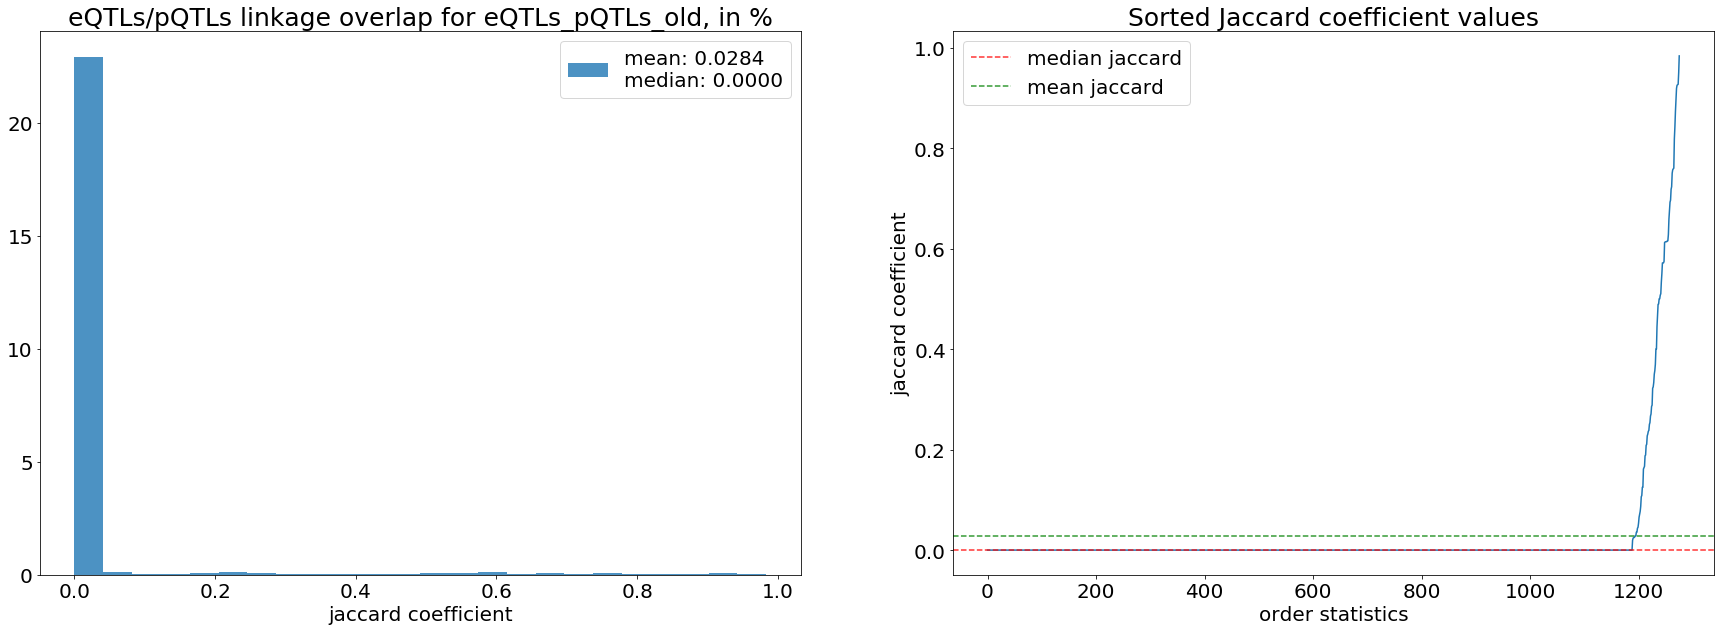

CPU times: user 4.86 s, sys: 24 ms, total: 4.88 s
Wall time: 4.94 s


In [83]:
%%time

reload(qtls)
gene_pool = np.intersect1d(expression_df["eQTLs_old"]["gene"], expression_df["pQTLs"]["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(qtls_df["eQTLs_old"], [gene_name])
    linked_pQTLs = qtls.linked_markers(qtls_df["pQTLs"], [gene_name])
    linkage_overlap_data.append(qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))

qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs_old")


In [10]:
%%time

""" Using simple PPIN-based test to assess whether interacting genes really have better eQTL/pQTL intersection 
    TODO: вычислять доверительные интервалы
"""

def eQTL_pQTL_similarity_ppin_test(qtl_type2graph, interactome_graph):
    scores = []
    for marker in np.intersect1d(qtl_type2graph["eQTLs"].vs.select(part=0)["name"], 
                                 qtl_type2graph["pQTLs"].vs.select(part=0)["name"]):
        linked = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] = set(qtl_type2graph[qtl_type].vs[qtl_type2graph[qtl_type].neighborhood(marker, mode="out")]["name"])
            linked[qtl_type].remove(marker)
        matches = len(linked["eQTLs"] & linked["pQTLs"])
        tests_count = len(linked["eQTLs"]) * len(linked["pQTLs"])
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] &= set(interactome_graph.vs["name"])
        for eQTL_gene in linked["eQTLs"]:
            for pQTL_gene in linked["pQTLs"]:
                if eQTL_gene != pQTL_gene \
                        and interactome_graph.are_connected(eQTL_gene, pQTL_gene): 
                    matches += 1
        scores.append(matches / tests_count)
    return np.mean(scores)

tuples_for_df = []
for q_cutoff in 10. ** np.arange(-5, -1):
    qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_old"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True),
                 "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True)}
    
    real_test_results = eQTL_pQTL_similarity_ppin_test(qtl_graph, interactome_graph)
    randomized_test_results = []
    for i in range(1024):
        with open("./data/randomized_interactome_copies/physical/{}.pkl".format(i), "rb") as pickle_file:
            randomized_interactome_graph = pickle.load(pickle_file)
            randomized_test_results.append(
                eQTL_pQTL_similarity_ppin_test(qtl_graph, randomized_interactome_graph)
            )
    tuples_for_df.append((q_cutoff, real_test_results, np.mean(randomized_test_results)))
    
results_df = pd.DataFrame(tuples_for_df, columns=["q_cutoff", "real_mean", "random_mean"])
results_df.to_csv("./data/interactions/eQTL_pQTL_intersection.csv", sep='\t', index=False)
display(results_df)

        

,q_cutoff,real_mean,random_mean,random_median
0,0.00001,0.037566,0.032253,0.031037
1,0.00010,0.030541,0.028900,0.027287
2,0.00100,0.038020,0.029751,0.028188
3,0.01000,0.027084,0.023223,0.022694


CPU times: user 26min 13s, sys: 1.25 s, total: 26min 14s
Wall time: 26min 21s


In [68]:
%%time

""" TODO: доверительные интервалы """

gene_pool = np.intersect1d(expression_df["eQTLs_old"]["gene"].values, expression_df["pQTLs"]["gene"].values)
for q_cutoff in 10. ** np.arange(-5, -1):
    print("q-value threshold: {}".format(q_cutoff))
    for modules_type in ["thecellmap", "kegg_modules", "kegg_pathways", "geneontology"]:
        qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_old"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True),
                     "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs"].query("q_value <= {}".format(q_cutoff))[["SNP", "gene"]].values, directed=True)}
        with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
            modules_dict = pickle.load(pickle_file)
        module_genes_union = np.intersect1d(np.unique(np.hstack(modules_dict.values())), gene_pool)
        module_qtls = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            genes_with_linkages = np.intersect1d(module_genes_union, qtl_graph[qtl_type].vs.select(part=1)["name"])
            induced_subgraph = qtl_graph[qtl_type].subgraph(np.unique(np.hstack(qtl_graph[qtl_type].neighborhood(genes_with_linkages))))
            module_qtls[qtl_type] = [(marker, modules_type) for marker in induced_subgraph.vs.select(part=0)["name"]]
            
        randomized_J_scores = []
        for i in range(1024):
            randomized_modules = [np.random.RandomState().choice(gene_pool, len(module_genes)) for module_genes in modules_dict.values()]
            randomized_module_genes_union = np.unique(np.hstack(randomized_modules))
            randomized_module_qtls = {}
            for qtl_type in ["eQTLs", "pQTLs"]:
                genes_with_linkages = np.intersect1d(randomized_module_genes_union, qtl_graph[qtl_type].vs.select(part=1)["name"])
                induced_subgraph = qtl_graph[qtl_type].subgraph(np.unique(np.hstack(qtl_graph[qtl_type].neighborhood(genes_with_linkages))))
                randomized_module_qtls[qtl_type] = [(marker, modules_type) for marker in induced_subgraph.vs.select(part=0)["name"]]
            randomized_J_scores.append(qtls.jaccard(set(randomized_module_qtls["eQTLs"]), set(randomized_module_qtls["pQTLs"])))
        print("{}\tJ: {:.4}\trJ: {:.4}".format(
            modules_type, 
            qtls.jaccard(set(module_qtls["eQTLs"]), set(module_qtls["pQTLs"])),
            np.mean(randomized_J_scores)
        ))
    print("\n")

q-value threshold: 1e-05


thecellmap	J: 0.2638	rJ: 0.2044


kegg_modules	J: 0.3941	rJ: 0.21


kegg_pathways	J: 0.3736	rJ: 0.1924


geneontology	J: 0.1954	rJ: 0.1916


q-value threshold: 0.0001


thecellmap	J: 0.2617	rJ: 0.2339


kegg_modules	J: 0.3454	rJ: 0.2385


kegg_pathways	J: 0.3814	rJ: 0.2298


geneontology	J: 0.237	rJ: 0.2301


q-value threshold: 0.001


thecellmap	J: 0.3116	rJ: 0.2699


kegg_modules	J: 0.2909	rJ: 0.2763


kegg_pathways	J: 0.3397	rJ: 0.2639


geneontology	J: 0.2655	rJ: 0.2634


q-value threshold: 0.01


thecellmap	J: 0.3154	rJ: 0.324


kegg_modules	J: 0.2753	rJ: 0.3243


kegg_pathways	J: 0.3996	rJ: 0.3426


geneontology	J: 0.3491	rJ: 0.3466


CPU times: user 5min 53s, sys: 3min 8s, total: 9min 2s
Wall time: 9min 2s


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Module processing

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

In [12]:
modules_type = "thecellmap"
with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
    modules_dict = pickle.load(pickle_file)
fdr_cutoffs = np.logspace(-5, -2, 10)

In [13]:
"""Basic information about the functional modules: numbers of vertices and edges for pseudo- and simple subgraphs spanned by modules' genes"""
%%time

for simplify_flag in [False, True]:
    modules_stats = networks.basic_module_info(
         interactome_graph=interactome_graph, 
         modules_dict=modules_dict, 
         modules_type=modules_type,
         simplify=simplify_flag)
    modules_stats.to_csv("./results/{}/".format(modules_type) 
              + ("simplified" if simplify_flag else "raw") 
              + "_module_stats.csv", sep='\t', index=False)
    display(modules_stats.sort_values(by="genes_count", ascending=False))

,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,149,2478
12,"Glycosylation, protein folding|targeting, cell...",160,140,549
5,"Respiration, oxidative phosphorylation, mitoch...",138,135,318
15,Transcription & chromatin organization,110,85,1575
3,Cell polarity & morphogenesis,102,64,966
14,mRNA & tRNA processing,96,84,1126
4,Vesicle traffic,95,84,770
7,DNA replication & repair,95,75,926
0,rDNA & ncDNA processing,90,76,1055
13,Ribosome biogenesis,74,70,65


,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,145,667
12,"Glycosylation, protein folding|targeting, cell...",160,96,185
5,"Respiration, oxidative phosphorylation, mitoch...",138,88,165
15,Transcription & chromatin organization,110,81,303
3,Cell polarity & morphogenesis,102,60,225
14,mRNA & tRNA processing,96,80,456
4,Vesicle traffic,95,73,169
7,DNA replication & repair,95,71,183
0,rDNA & ncDNA processing,90,68,424
13,Ribosome biogenesis,74,35,45


CPU times: user 8.65 s, sys: 16 ms, total: 8.66 s
Wall time: 9.33 s


In [9]:
gene_pool = np.intersect1d(expression_df["eQTLs_interpolated"]["gene"], expression_df["pQTLs"]["gene"])

In [18]:

%%time
reload(qtls)

def calculate_eqtl_pqtl_intersection(modules_type):
    with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
        modules_dict = pickle.load(pickle_file)
    for eqtls_type in ["old"]:
        print("{}: {}".format(modules_type, eqtls_type))
        pd.DataFrame(
            [
                (q_cutoff, *qtls.qtl_overlap_test(qtls_df["eQTLs_{}".format(eqtls_type)].query("q_value < {}".format(q_cutoff)),
                                                  qtls_df["pQTLs"].query("q_value < {}".format(q_cutoff)),
                                                  gene_pool, modules_dict))
                for q_cutoff in 10.**np.arange(-8, -1)
            ],
            columns = ["q_value_cutoff", "real_modules", "random_modules"],
            dtype=np.float32
        ).to_csv("./results/{}/eQTL_pQTL_intersection_{}.csv".format(modules_type, eqtls_type), sep='\t', index=False)
        
module_types = ["geneontology"]        
joblib.Parallel(n_jobs=len(modules_type))(
    joblib.delayed(calculate_eqtl_pqtl_intersection)(modules_type) 
    for modules_type in module_types
)

CPU times: user 2.1 s, sys: 180 ms, total: 2.28 s
Wall time: 13min 5s


In [6]:
""" The same information, only visualized. """

%%time

intersection_j, randomized_intersection_j = qtls.qtl_overlap_by_module_test(qtls_df["eQTLs_old"], qtls_df["pQTLs"], 
                                                                            gene_pool, modules_dict)

qtls.qtl_overlap_hist(intersection_j, modules_type)
qtls.qtl_overlap_hist(randomized_intersection_j, modules_type + "_randomized")

random samples generated:   0%|          | 0/108 [00:00<?, ?it/s]

random samples generated:   1%|          | 1/108 [00:00<00:31,  3.38it/s]

random samples generated:   2%|▏         | 2/108 [00:00<00:30,  3.53it/s]

random samples generated:   3%|▎         | 3/108 [00:00<00:29,  3.53it/s]

random samples generated:   4%|▎         | 4/108 [00:01<00:29,  3.49it/s]

random samples generated:   5%|▍         | 5/108 [00:01<00:30,  3.34it/s]

random samples generated:   6%|▌         | 6/108 [00:01<00:31,  3.25it/s]

random samples generated:   6%|▋         | 7/108 [00:02<00:30,  3.28it/s]

random samples generated:   7%|▋         | 8/108 [00:02<00:32,  3.11it/s]

random samples generated:   8%|▊         | 9/108 [00:02<00:31,  3.14it/s]

random samples generated:   9%|▉         | 10/108 [00:03<00:30,  3.17it/s]

random samples generated:  10%|█         | 11/108 [00:03<00:30,  3.20it/s]

random samples generated:  11%|█         | 12/108 [00:03<00:30,  3.10it/s]

random samples generated:  12%|█▏        | 13/108 [00:04<00:30,  3.10it/s]

random samples generated:  13%|█▎        | 14/108 [00:04<00:30,  3.11it/s]

random samples generated:  14%|█▍        | 15/108 [00:04<00:29,  3.12it/s]

random samples generated:  15%|█▍        | 16/108 [00:05<00:29,  3.10it/s]

random samples generated:  16%|█▌        | 17/108 [00:05<00:29,  3.07it/s]

random samples generated:  17%|█▋        | 18/108 [00:05<00:28,  3.10it/s]

random samples generated:  18%|█▊        | 19/108 [00:06<00:28,  3.12it/s]

random samples generated:  19%|█▊        | 20/108 [00:06<00:27,  3.15it/s]

random samples generated:  19%|█▉        | 21/108 [00:06<00:27,  3.15it/s]

random samples generated:  20%|██        | 22/108 [00:06<00:27,  3.16it/s]

random samples generated:  21%|██▏       | 23/108 [00:07<00:26,  3.17it/s]

random samples generated:  22%|██▏       | 24/108 [00:07<00:27,  3.09it/s]

random samples generated:  23%|██▎       | 25/108 [00:08<00:27,  3.07it/s]

random samples generated:  24%|██▍       | 26/108 [00:08<00:26,  3.06it/s]

random samples generated:  25%|██▌       | 27/108 [00:08<00:26,  3.05it/s]

random samples generated:  26%|██▌       | 28/108 [00:09<00:26,  3.05it/s]

random samples generated:  27%|██▋       | 29/108 [00:09<00:25,  3.04it/s]

random samples generated:  28%|██▊       | 30/108 [00:09<00:25,  3.06it/s]

random samples generated:  29%|██▊       | 31/108 [00:10<00:25,  3.05it/s]

random samples generated:  30%|██▉       | 32/108 [00:10<00:24,  3.05it/s]

random samples generated:  31%|███       | 33/108 [00:10<00:24,  3.06it/s]

random samples generated:  31%|███▏      | 34/108 [00:11<00:24,  3.05it/s]

random samples generated:  32%|███▏      | 35/108 [00:11<00:23,  3.06it/s]

random samples generated:  33%|███▎      | 36/108 [00:11<00:23,  3.04it/s]

random samples generated:  34%|███▍      | 37/108 [00:12<00:23,  3.02it/s]

random samples generated:  35%|███▌      | 38/108 [00:12<00:23,  3.01it/s]

random samples generated:  36%|███▌      | 39/108 [00:12<00:22,  3.02it/s]

random samples generated:  37%|███▋      | 40/108 [00:13<00:22,  3.03it/s]

random samples generated:  38%|███▊      | 41/108 [00:13<00:22,  3.03it/s]

random samples generated:  39%|███▉      | 42/108 [00:13<00:21,  3.04it/s]

random samples generated:  40%|███▉      | 43/108 [00:14<00:21,  3.04it/s]

random samples generated:  41%|████      | 44/108 [00:14<00:21,  3.05it/s]

random samples generated:  42%|████▏     | 45/108 [00:14<00:20,  3.05it/s]

random samples generated:  43%|████▎     | 46/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▎     | 47/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▍     | 48/108 [00:15<00:19,  3.03it/s]

random samples generated:  45%|████▌     | 49/108 [00:16<00:19,  3.04it/s]

random samples generated:  46%|████▋     | 50/108 [00:16<00:19,  3.05it/s]

random samples generated:  47%|████▋     | 51/108 [00:16<00:18,  3.05it/s]

random samples generated:  48%|████▊     | 52/108 [00:16<00:18,  3.06it/s]

random samples generated:  49%|████▉     | 53/108 [00:17<00:17,  3.06it/s]

random samples generated:  50%|█████     | 54/108 [00:17<00:17,  3.07it/s]

random samples generated:  51%|█████     | 55/108 [00:18<00:17,  3.05it/s]

random samples generated:  52%|█████▏    | 56/108 [00:18<00:17,  3.05it/s]

random samples generated:  53%|█████▎    | 57/108 [00:18<00:16,  3.04it/s]

random samples generated:  54%|█████▎    | 58/108 [00:19<00:16,  3.04it/s]

random samples generated:  55%|█████▍    | 59/108 [00:19<00:16,  3.05it/s]

random samples generated:  56%|█████▌    | 60/108 [00:19<00:15,  3.03it/s]

random samples generated:  56%|█████▋    | 61/108 [00:20<00:15,  3.04it/s]

random samples generated:  57%|█████▋    | 62/108 [00:20<00:15,  3.04it/s]

random samples generated:  58%|█████▊    | 63/108 [00:20<00:14,  3.04it/s]

random samples generated:  59%|█████▉    | 64/108 [00:21<00:14,  3.03it/s]

random samples generated:  60%|██████    | 65/108 [00:21<00:14,  3.03it/s]

random samples generated:  61%|██████    | 66/108 [00:21<00:13,  3.04it/s]

random samples generated:  62%|██████▏   | 67/108 [00:22<00:13,  3.04it/s]

random samples generated:  63%|██████▎   | 68/108 [00:22<00:13,  3.04it/s]

random samples generated:  64%|██████▍   | 69/108 [00:22<00:12,  3.02it/s]

random samples generated:  65%|██████▍   | 70/108 [00:23<00:12,  3.02it/s]

random samples generated:  66%|██████▌   | 71/108 [00:23<00:12,  3.02it/s]

random samples generated:  67%|██████▋   | 72/108 [00:23<00:11,  3.03it/s]

random samples generated:  68%|██████▊   | 73/108 [00:24<00:11,  3.03it/s]

random samples generated:  69%|██████▊   | 74/108 [00:24<00:11,  3.04it/s]

random samples generated:  69%|██████▉   | 75/108 [00:24<00:10,  3.03it/s]

random samples generated:  70%|███████   | 76/108 [00:25<00:10,  3.03it/s]

random samples generated:  71%|███████▏  | 77/108 [00:25<00:10,  3.04it/s]

random samples generated:  72%|███████▏  | 78/108 [00:25<00:09,  3.03it/s]

random samples generated:  73%|███████▎  | 79/108 [00:26<00:09,  3.03it/s]

random samples generated:  74%|███████▍  | 80/108 [00:26<00:09,  3.04it/s]

random samples generated:  75%|███████▌  | 81/108 [00:26<00:08,  3.03it/s]

random samples generated:  76%|███████▌  | 82/108 [00:26<00:08,  3.04it/s]

random samples generated:  77%|███████▋  | 83/108 [00:27<00:08,  3.03it/s]

random samples generated:  78%|███████▊  | 84/108 [00:27<00:07,  3.03it/s]

random samples generated:  79%|███████▊  | 85/108 [00:28<00:07,  3.03it/s]

random samples generated:  80%|███████▉  | 86/108 [00:28<00:07,  3.02it/s]

random samples generated:  81%|████████  | 87/108 [00:28<00:06,  3.01it/s]

random samples generated:  81%|████████▏ | 88/108 [00:29<00:06,  3.00it/s]

random samples generated:  82%|████████▏ | 89/108 [00:29<00:06,  3.01it/s]

random samples generated:  83%|████████▎ | 90/108 [00:29<00:05,  3.01it/s]

random samples generated:  84%|████████▍ | 91/108 [00:30<00:05,  3.00it/s]

random samples generated:  85%|████████▌ | 92/108 [00:30<00:05,  3.01it/s]

random samples generated:  86%|████████▌ | 93/108 [00:30<00:04,  3.00it/s]

random samples generated:  87%|████████▋ | 94/108 [00:31<00:04,  3.00it/s]

random samples generated:  88%|████████▊ | 95/108 [00:31<00:04,  3.00it/s]

random samples generated:  89%|████████▉ | 96/108 [00:31<00:03,  3.00it/s]

random samples generated:  90%|████████▉ | 97/108 [00:32<00:03,  2.99it/s]

random samples generated:  91%|█████████ | 98/108 [00:32<00:03,  2.99it/s]

random samples generated:  92%|█████████▏| 99/108 [00:33<00:03,  2.99it/s]

random samples generated:  93%|█████████▎| 100/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▎| 101/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▍| 102/108 [00:34<00:02,  2.99it/s]

random samples generated:  95%|█████████▌| 103/108 [00:34<00:01,  2.98it/s]

random samples generated:  96%|█████████▋| 104/108 [00:34<00:01,  2.99it/s]

random samples generated:  97%|█████████▋| 105/108 [00:35<00:01,  2.99it/s]

random samples generated:  98%|█████████▊| 106/108 [00:35<00:00,  2.98it/s]

random samples generated:  99%|█████████▉| 107/108 [00:35<00:00,  2.98it/s]

random samples generated: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]

CPU times: user 39.8 s, sys: 184 ms, total: 40 s
Wall time: 39.8 s


In [146]:
"""
OBSERVATION: gene pool tends to be biased towards high eQTL/pQTL overlap ration.
Reasons and interpretations of such behaviour remain unclear.    
"""

sample_size = 10
def randomize_and_overlap(sample_size, iter_num=200):
    jaccard_coeffs = []
    for i in range(iter_num):
        gene_sample = np.random.RandomState().choice(gene_pool, sample_size, replace=False)
        linked_eQTLs = set(qtls.linked_markers(qtls_df["eQTLs_old"], gene_sample))
        linked_pQTLs = set(qtls.linked_markers(qtls_df["pQTLs"], gene_sample))
        jaccard_coeffs.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
    return np.mean(jaccard_coeffs)

display(
    pd.DataFrame(
        [
            (q_cutoff, randomize_and_overlap(sample_size))
            for q_cutoff in 10.**np.arange(-8, -1)
        ],
        columns = ["q_value_cutoff", "random_samples_of_size_{}".format(sample_size)],
        dtype=np.float32
    )
)

,q_value_cutoff,random_samples_of_size_10
0,1.000000e-08,0.137914
1,1.000000e-07,0.159089
2,1.000000e-06,0.160416
3,1.000000e-05,0.135067
4,1.000000e-04,0.171282
5,1.000000e-03,0.156258
6,1.000000e-02,0.153712


In [5]:
""" Helper cell. Used to visualize results of full-graph test and PPIN test. """

%%time
reload(qtls)
for expression_df, qtl_df, qtl_type in [(expression_df["eQTLs_old"], qtls_df["eQTLs_old"], "eQTLs"),
                                        (expression_df["pQTLs"], qtls_df["pQTLs"], "pQTLs")]:
    qtls.plot_analysis_results(
        expression_df=expression_df,
        interactions_type="physical",
        interactome_graph=interactome_graph,
        modules_dict=modules_dict,
        modules_type=modules_type,
        qtl_df=qtl_df,
        qtl_type=qtl_type
    )
    


subdirectories processed:   0%|          | 0/18 [00:00<?, ?it/s]

subdirectories processed:   6%|▌         | 1/18 [00:00<00:07,  2.28it/s]

subdirectories processed:  11%|█         | 2/18 [00:00<00:07,  2.22it/s]

subdirectories processed:  17%|█▋        | 3/18 [00:01<00:07,  2.14it/s]

subdirectories processed:  33%|███▎      | 6/18 [00:01<00:03,  3.41it/s]

subdirectories processed:  39%|███▉      | 7/18 [00:02<00:03,  3.30it/s]

subdirectories processed:  56%|█████▌    | 10/18 [00:02<00:01,  4.04it/s]

subdirectories processed:  67%|██████▋   | 12/18 [00:02<00:01,  4.23it/s]

subdirectories processed:  89%|████████▉ | 16/18 [00:03<00:00,  5.00it/s]

subdirectories processed:  94%|█████████▍| 17/18 [00:03<00:00,  4.77it/s]

subdirectories processed: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:03,  2.69it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:02,  2.71it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:02,  2.71it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.65it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.62it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.60it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:03,  2.57it/s]

vignettes plotted:  20%|██        | 2/10 [00:00<00:02,  2.93it/s]

vignettes plotted:  30%|███       | 3/10 [00:00<00:02,  3.09it/s]

vignettes plotted:  40%|████      | 4/10 [00:01<00:01,  3.17it/s]

vignettes plotted:  50%|█████     | 5/10 [00:01<00:01,  3.22it/s]

vignettes plotted:  60%|██████    | 6/10 [00:01<00:01,  3.26it/s]

vignettes plotted:  70%|███████   | 7/10 [00:02<00:00,  3.28it/s]

vignettes plotted:  80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

vignettes plotted: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


subdirectories processed:   0%|          | 0/28 [00:00<?, ?it/s]

subdirectories processed:   4%|▎         | 1/28 [00:00<00:11,  2.35it/s]

subdirectories processed:  14%|█▍        | 4/28 [00:00<00:05,  4.77it/s]

subdirectories processed:  18%|█▊        | 5/28 [00:01<00:05,  3.92it/s]

subdirectories processed:  36%|███▌      | 10/28 [00:01<00:03,  5.89it/s]

subdirectories processed:  39%|███▉      | 11/28 [00:02<00:03,  5.21it/s]

subdirectories processed:  54%|█████▎    | 15/28 [00:02<00:02,  5.89it/s]

subdirectories processed:  61%|██████    | 17/28 [00:02<00:01,  5.69it/s]

subdirectories processed:  79%|███████▊  | 22/28 [00:03<00:00,  6.42it/s]

subdirectories processed:  89%|████████▉ | 25/28 [00:03<00:00,  6.43it/s]

subdirectories processed:  93%|█████████▎| 26/28 [00:04<00:00,  5.95it/s]

subdirectories processed: 100%|██████████| 28/28 [00:04<00:00,  6.41it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:04,  2.24it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:03,  2.29it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:03,  2.31it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.35it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:02<00:02,  2.35it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.32it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:03<00:01,  2.31it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:04,  1.91it/s]

vignettes plotted:  20%|██        | 2/10 [00:01<00:04,  1.92it/s]

vignettes plotted:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

vignettes plotted:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

vignettes plotted:  50%|█████     | 5/10 [00:02<00:02,  1.89it/s]

vignettes plotted:  60%|██████    | 6/10 [00:03<00:02,  1.89it/s]

vignettes plotted:  70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

vignettes plotted:  80%|████████  | 8/10 [00:04<00:01,  1.87it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

vignettes plotted: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

CPU times: user 38.8 s, sys: 580 ms, total: 39.4 s
Wall time: 25 s


In [126]:
""" INVESTIGATION: how precisely can pQTLs be predicted from eQTLs given PPIN? """

%%time

reload(qtls)
print(modules_type)

predictions_dict = {}
for module_name, module_genes in tqdm(modules_dict.items()):
    predictions_dict[module_name] = qtls.PqtlPredictor(
        eqtls_df=qtls_df["eQTLs_old"], pqtls_df=qtls_df["pQTLs"],
        pqtls_expression_df=expression_df["pQTLs"], pqtls_genotypes_df=genotypes_df["pQTLs"],
        module_name=module_name, module_genes=module_genes,
        interactome_graph=interactome_graph
    ).predict()

display(pd.DataFrame(
    ((key, *values) for key, values in predictions_dict.items()),
    columns=["module_name", "common_pQTLs", "overlap_ratio", "old_pQTLs", "predicted_pQTLs", "delta"]
).sort_values(by="overlap_ratio", ascending=False))

thecellmap
Ribosome biogenesis


/home/vvi/Science/eQTL_analysis/src/qtls.py:796: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  columns=pqtls_expression_df.columns[1:]
/home/vvi/Science/eQTL_analysis/src/qtls.py:800: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  columns=pqtls_genotypes_df.columns[1:]


CPU times: user 2min 56s, sys: 20.3 s, total: 3min 16s
Wall time: 3min 22s


## GeneOntology

In [5]:
""" GO terms covering 10-150 genes are extracted and used to generate functional modules."""

from goatools import obo_parser

# building the GeneOntology DAG
obodag = obo_parser.GODag(
    "./data/geneontology/go-basic.obo",
    optional_attrs=["relationship"]
)
from Bio.UniProt.GOA import gafiterator

# how many of them are present in actual yeast genome?
yeast_gaf = './data/geneontology/goa_yeast.gaf'
goid2genes = collections.defaultdict(list)
with open(yeast_gaf) as handle:
    for rec in gafiterator(handle):
        go_term = obodag[rec["GO_ID"]]
        for par in go_term.parents:
            goid2genes[par.id].append(rec["DB_Object_Symbol"])
            
for key, val in goid2genes.items():
    goid2genes[key] = np.unique(val)

physically_interacting_genes = set(interactome_graphs_dict["physical"].vs["name"])
geneontology_modules_dict = {
    obodag[go_id].name.replace('/', '|') : genes 
    for go_id, genes in tqdm(goid2genes.items()) 
    if 10 <= len(interactome_graphs_dict["physical"].subgraph(
            set(genes) & physically_interacting_genes
        ).simplify().vs.select(_degree_gt=0)) <= 150
}

with open("./results/geneontology/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(geneontology_modules_dict, pickle_file)
# with open("./results/geneontology/modules_dict.pkl", "rb+") as pickle_file:
#     geneontology_modules_dict = pickle.load(pickle_file)

./data/geneontology/go-basic.obo: fmt(1.2) rel(2018-07-02) 47,231 GO Terms; optional_attrs(relationship)


  0%|          | 0/4136 [00:00<?, ?it/s]

 17%|█▋        | 687/4136 [00:00<00:00, 6862.20it/s]

 29%|██▉       | 1218/4136 [00:00<00:00, 6084.30it/s]

 47%|████▋     | 1960/4136 [00:00<00:00, 6528.53it/s]

 65%|██████▍   | 2682/4136 [00:00<00:00, 6686.99it/s]

 78%|███████▊  | 3226/4136 [00:00<00:00, 6437.86it/s]

 95%|█████████▍| 3915/4136 [00:00<00:00, 6509.87it/s]

100%|██████████| 4136/4136 [00:00<00:00, 6431.32it/s]

## KEGG pathways

In [6]:
""" KEGG pathways are retrieved by querying KEGG database """

%%time 
kegg_pathways_dict = {("-".join(key.split('-')[:-1])):value for key, value in 
                     ontologies.query_KEGG(database="pathway", organism="sce").items()}

with open("./results/kegg_pathways/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_pathways_dict, pickle_file)
# with open("./results/kegg_pathways/modules_dict.pkl", "rb+") as pickle_file:
#     kegg_pathways_dict = pickle.load(pickle_file)

modules retrieved:   0%|          | 0/116 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/116 [00:01<02:12,  1.15s/it]

modules retrieved:   2%|▏         | 2/116 [00:02<02:12,  1.16s/it]

modules retrieved:   3%|▎         | 3/116 [00:07<04:25,  2.35s/it]

modules retrieved:   3%|▎         | 4/116 [00:08<03:47,  2.03s/it]

modules retrieved:   4%|▍         | 5/116 [00:09<03:27,  1.87s/it]

modules retrieved:   5%|▌         | 6/116 [00:10<03:04,  1.68s/it]

modules retrieved:   6%|▌         | 7/116 [00:10<02:48,  1.54s/it]

modules retrieved:   7%|▋         | 8/116 [00:11<02:39,  1.48s/it]

modules retrieved:   8%|▊         | 9/116 [00:12<02:29,  1.39s/it]

modules retrieved:   9%|▊         | 10/116 [00:13<02:20,  1.32s/it]

modules retrieved:   9%|▉         | 11/116 [00:14<02:16,  1.30s/it]

modules retrieved:  10%|█         | 12/116 [00:17<02:29,  1.43s/it]

modules retrieved:  11%|█         | 13/116 [00:18<02:25,  1.41s/it]

modules retrieved:  12%|█▏        | 14/116 [00:19<02:19,  1.37s/it]

modules retrieved:  13%|█▎        | 15/116 [00:20<02:16,  1.35s/it]

modules retrieved:  14%|█▍        | 16/116 [00:21<02:14,  1.35s/it]

modules retrieved:  15%|█▍        | 17/116 [00:22<02:13,  1.35s/it]

modules retrieved:  16%|█▌        | 18/116 [00:24<02:12,  1.36s/it]

modules retrieved:  16%|█▋        | 19/116 [00:25<02:11,  1.36s/it]

modules retrieved:  17%|█▋        | 20/116 [00:26<02:09,  1.35s/it]

modules retrieved:  18%|█▊        | 21/116 [00:27<02:04,  1.31s/it]

modules retrieved:  19%|█▉        | 22/116 [00:28<02:00,  1.29s/it]

modules retrieved:  20%|█▉        | 23/116 [00:29<01:57,  1.26s/it]

modules retrieved:  21%|██        | 24/116 [00:31<02:00,  1.31s/it]

modules retrieved:  22%|██▏       | 25/116 [00:32<01:57,  1.30s/it]

modules retrieved:  22%|██▏       | 26/116 [00:33<01:55,  1.29s/it]

modules retrieved:  23%|██▎       | 27/116 [00:34<01:52,  1.27s/it]

modules retrieved:  24%|██▍       | 28/116 [00:34<01:49,  1.25s/it]

modules retrieved:  25%|██▌       | 29/116 [00:36<01:48,  1.25s/it]

modules retrieved:  26%|██▌       | 30/116 [00:36<01:45,  1.23s/it]

modules retrieved:  27%|██▋       | 31/116 [00:37<01:43,  1.22s/it]

modules retrieved:  28%|██▊       | 32/116 [00:38<01:40,  1.20s/it]

modules retrieved:  28%|██▊       | 33/116 [00:39<01:38,  1.19s/it]

modules retrieved:  29%|██▉       | 34/116 [00:40<01:36,  1.18s/it]

modules retrieved:  30%|███       | 35/116 [00:40<01:34,  1.17s/it]

modules retrieved:  31%|███       | 36/116 [00:41<01:32,  1.15s/it]

modules retrieved:  32%|███▏      | 37/116 [00:42<01:31,  1.15s/it]

modules retrieved:  33%|███▎      | 38/116 [00:43<01:29,  1.15s/it]

modules retrieved:  34%|███▎      | 39/116 [00:44<01:28,  1.15s/it]

modules retrieved:  34%|███▍      | 40/116 [00:45<01:26,  1.14s/it]

modules retrieved:  35%|███▌      | 41/116 [00:46<01:25,  1.14s/it]

modules retrieved:  36%|███▌      | 42/116 [00:47<01:23,  1.13s/it]

modules retrieved:  37%|███▋      | 43/116 [00:48<01:22,  1.12s/it]

modules retrieved:  38%|███▊      | 44/116 [00:49<01:20,  1.12s/it]

modules retrieved:  39%|███▉      | 45/116 [00:50<01:19,  1.12s/it]

modules retrieved:  40%|███▉      | 46/116 [00:51<01:17,  1.11s/it]

modules retrieved:  41%|████      | 47/116 [00:52<01:16,  1.11s/it]

modules retrieved:  41%|████▏     | 48/116 [00:53<01:15,  1.11s/it]

modules retrieved:  42%|████▏     | 49/116 [00:53<01:13,  1.10s/it]

modules retrieved:  43%|████▎     | 50/116 [00:54<01:12,  1.10s/it]

modules retrieved:  44%|████▍     | 51/116 [00:55<01:10,  1.09s/it]

modules retrieved:  45%|████▍     | 52/116 [00:56<01:09,  1.08s/it]

modules retrieved:  46%|████▌     | 53/116 [00:57<01:07,  1.08s/it]

modules retrieved:  47%|████▋     | 54/116 [00:58<01:06,  1.08s/it]

modules retrieved:  47%|████▋     | 55/116 [00:58<01:05,  1.07s/it]

modules retrieved:  48%|████▊     | 56/116 [00:59<01:03,  1.06s/it]

modules retrieved:  49%|████▉     | 57/116 [01:00<01:02,  1.06s/it]

modules retrieved:  50%|█████     | 58/116 [01:00<01:00,  1.05s/it]

modules retrieved:  51%|█████     | 59/116 [01:02<00:59,  1.05s/it]

modules retrieved:  52%|█████▏    | 60/116 [01:03<00:58,  1.05s/it]

modules retrieved:  53%|█████▎    | 61/116 [01:03<00:57,  1.04s/it]

modules retrieved:  53%|█████▎    | 62/116 [01:04<00:56,  1.05s/it]

modules retrieved:  54%|█████▍    | 63/116 [01:05<00:55,  1.05s/it]

modules retrieved:  55%|█████▌    | 64/116 [01:06<00:54,  1.04s/it]

modules retrieved:  56%|█████▌    | 65/116 [01:07<00:53,  1.04s/it]

modules retrieved:  57%|█████▋    | 66/116 [01:08<00:51,  1.04s/it]

modules retrieved:  58%|█████▊    | 67/116 [01:09<00:50,  1.04s/it]

modules retrieved:  59%|█████▊    | 68/116 [01:10<00:49,  1.03s/it]

modules retrieved:  59%|█████▉    | 69/116 [01:11<00:48,  1.03s/it]

modules retrieved:  60%|██████    | 70/116 [01:12<00:47,  1.03s/it]

modules retrieved:  61%|██████    | 71/116 [01:13<00:46,  1.04s/it]

modules retrieved:  62%|██████▏   | 72/116 [01:14<00:45,  1.04s/it]

modules retrieved:  63%|██████▎   | 73/116 [01:15<00:44,  1.04s/it]

modules retrieved:  64%|██████▍   | 74/116 [01:17<00:44,  1.05s/it]

modules retrieved:  65%|██████▍   | 75/116 [01:18<00:43,  1.05s/it]

modules retrieved:  66%|██████▌   | 76/116 [01:19<00:41,  1.04s/it]

modules retrieved:  66%|██████▋   | 77/116 [01:20<00:40,  1.04s/it]

modules retrieved:  67%|██████▋   | 78/116 [01:20<00:39,  1.04s/it]

modules retrieved:  68%|██████▊   | 79/116 [01:21<00:38,  1.03s/it]

modules retrieved:  69%|██████▉   | 80/116 [01:22<00:37,  1.03s/it]

modules retrieved:  70%|██████▉   | 81/116 [01:22<00:35,  1.02s/it]

modules retrieved:  71%|███████   | 82/116 [01:23<00:34,  1.02s/it]

modules retrieved:  72%|███████▏  | 83/116 [01:24<00:33,  1.02s/it]

modules retrieved:  72%|███████▏  | 84/116 [01:25<00:32,  1.02s/it]

modules retrieved:  73%|███████▎  | 85/116 [01:27<00:31,  1.03s/it]

modules retrieved:  74%|███████▍  | 86/116 [01:28<00:30,  1.03s/it]

modules retrieved:  75%|███████▌  | 87/116 [01:29<00:29,  1.03s/it]

modules retrieved:  76%|███████▌  | 88/116 [01:30<00:28,  1.03s/it]

modules retrieved:  77%|███████▋  | 89/116 [01:31<00:27,  1.03s/it]

modules retrieved:  78%|███████▊  | 90/116 [01:32<00:26,  1.03s/it]

modules retrieved:  78%|███████▊  | 91/116 [01:33<00:25,  1.02s/it]

modules retrieved:  79%|███████▉  | 92/116 [01:34<00:24,  1.02s/it]

modules retrieved:  80%|████████  | 93/116 [01:35<00:23,  1.03s/it]

modules retrieved:  81%|████████  | 94/116 [01:36<00:22,  1.03s/it]

modules retrieved:  82%|████████▏ | 95/116 [01:38<00:21,  1.04s/it]

modules retrieved:  83%|████████▎ | 96/116 [01:39<00:20,  1.03s/it]

modules retrieved:  84%|████████▎ | 97/116 [01:39<00:19,  1.03s/it]

modules retrieved:  84%|████████▍ | 98/116 [01:40<00:18,  1.03s/it]

modules retrieved:  85%|████████▌ | 99/116 [01:41<00:17,  1.02s/it]

modules retrieved:  86%|████████▌ | 100/116 [01:42<00:16,  1.02s/it]

modules retrieved:  87%|████████▋ | 101/116 [01:43<00:15,  1.02s/it]

modules retrieved:  88%|████████▊ | 102/116 [01:44<00:14,  1.03s/it]

modules retrieved:  89%|████████▉ | 103/116 [01:46<00:13,  1.03s/it]

modules retrieved:  90%|████████▉ | 104/116 [01:47<00:12,  1.03s/it]

modules retrieved:  91%|█████████ | 105/116 [01:47<00:11,  1.03s/it]

modules retrieved:  91%|█████████▏| 106/116 [01:49<00:10,  1.03s/it]

modules retrieved:  92%|█████████▏| 107/116 [01:50<00:09,  1.03s/it]

modules retrieved:  93%|█████████▎| 108/116 [01:50<00:08,  1.03s/it]

modules retrieved:  94%|█████████▍| 109/116 [01:51<00:07,  1.03s/it]

modules retrieved:  95%|█████████▍| 110/116 [01:52<00:06,  1.03s/it]

modules retrieved:  96%|█████████▌| 111/116 [01:53<00:05,  1.03s/it]

modules retrieved:  97%|█████████▋| 112/116 [01:54<00:04,  1.02s/it]

modules retrieved:  97%|█████████▋| 113/116 [01:55<00:03,  1.02s/it]

modules retrieved:  98%|█████████▊| 114/116 [01:56<00:02,  1.02s/it]

modules retrieved:  99%|█████████▉| 115/116 [01:57<00:01,  1.02s/it]

modules retrieved: 100%|██████████| 116/116 [01:58<00:00,  1.02s/it]

CPU times: user 7.33 s, sys: 308 ms, total: 7.64 s
Wall time: 2min


## KEGG modules

In [7]:
""" Same for KEGG modules. """

%%time
reload(ontologies)

kegg_modules_dict = {key.replace('=>', 'to'):value for key, value in 
                     ontologies.query_KEGG(database="module", organism="sce").items()}

with open("./results/kegg_modules/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_modules_dict, pickle_file)


modules retrieved:   0%|          | 0/108 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/108 [00:00<01:18,  1.36it/s]

modules retrieved:   2%|▏         | 2/108 [00:02<02:22,  1.35s/it]

modules retrieved:   3%|▎         | 3/108 [00:03<01:59,  1.14s/it]

modules retrieved:   4%|▎         | 4/108 [00:04<01:48,  1.05s/it]

modules retrieved:   5%|▍         | 5/108 [00:04<01:40,  1.02it/s]

modules retrieved:   6%|▌         | 6/108 [00:05<01:34,  1.08it/s]

modules retrieved:   6%|▋         | 7/108 [00:06<01:29,  1.12it/s]

modules retrieved:   7%|▋         | 8/108 [00:06<01:26,  1.16it/s]

modules retrieved:   8%|▊         | 9/108 [00:07<01:23,  1.19it/s]

modules retrieved:   9%|▉         | 10/108 [00:08<01:21,  1.20it/s]

modules retrieved:  10%|█         | 11/108 [00:09<01:19,  1.22it/s]

modules retrieved:  11%|█         | 12/108 [00:09<01:17,  1.24it/s]

modules retrieved:  12%|█▏        | 13/108 [00:10<01:15,  1.26it/s]

modules retrieved:  13%|█▎        | 14/108 [00:10<01:13,  1.28it/s]

modules retrieved:  14%|█▍        | 15/108 [00:11<01:13,  1.27it/s]

modules retrieved:  15%|█▍        | 16/108 [00:12<01:11,  1.28it/s]

modules retrieved:  16%|█▌        | 17/108 [00:13<01:11,  1.26it/s]

modules retrieved:  17%|█▋        | 18/108 [00:14<01:10,  1.28it/s]

modules retrieved:  18%|█▊        | 19/108 [00:14<01:09,  1.28it/s]

modules retrieved:  19%|█▊        | 20/108 [00:15<01:07,  1.29it/s]

modules retrieved:  19%|█▉        | 21/108 [00:16<01:06,  1.30it/s]

modules retrieved:  20%|██        | 22/108 [00:16<01:05,  1.31it/s]

modules retrieved:  21%|██▏       | 23/108 [00:17<01:04,  1.32it/s]

modules retrieved:  22%|██▏       | 24/108 [00:18<01:03,  1.32it/s]

modules retrieved:  23%|██▎       | 25/108 [00:18<01:02,  1.33it/s]

modules retrieved:  24%|██▍       | 26/108 [00:19<01:01,  1.33it/s]

modules retrieved:  25%|██▌       | 27/108 [00:20<01:00,  1.34it/s]

modules retrieved:  26%|██▌       | 28/108 [00:20<00:59,  1.34it/s]

modules retrieved:  27%|██▋       | 29/108 [00:21<00:59,  1.32it/s]

modules retrieved:  28%|██▊       | 30/108 [00:22<00:59,  1.31it/s]

modules retrieved:  29%|██▊       | 31/108 [00:24<00:59,  1.29it/s]

modules retrieved:  30%|██▉       | 32/108 [00:27<01:05,  1.15it/s]

modules retrieved:  31%|███       | 33/108 [00:28<01:04,  1.16it/s]

modules retrieved:  31%|███▏      | 34/108 [00:29<01:03,  1.17it/s]

modules retrieved:  32%|███▏      | 35/108 [00:29<01:02,  1.17it/s]

modules retrieved:  33%|███▎      | 36/108 [00:30<01:00,  1.18it/s]

modules retrieved:  34%|███▍      | 37/108 [00:31<00:59,  1.19it/s]

modules retrieved:  35%|███▌      | 38/108 [00:31<00:58,  1.19it/s]

modules retrieved:  36%|███▌      | 39/108 [00:32<00:57,  1.20it/s]

modules retrieved:  37%|███▋      | 40/108 [00:33<00:56,  1.20it/s]

modules retrieved:  38%|███▊      | 41/108 [00:33<00:55,  1.21it/s]

modules retrieved:  39%|███▉      | 42/108 [00:34<00:54,  1.21it/s]

modules retrieved:  40%|███▉      | 43/108 [00:35<00:53,  1.22it/s]

modules retrieved:  41%|████      | 44/108 [00:36<00:52,  1.22it/s]

modules retrieved:  42%|████▏     | 45/108 [00:36<00:51,  1.22it/s]

modules retrieved:  43%|████▎     | 46/108 [00:37<00:50,  1.22it/s]

modules retrieved:  44%|████▎     | 47/108 [00:38<00:49,  1.23it/s]

modules retrieved:  44%|████▍     | 48/108 [00:39<00:48,  1.23it/s]

modules retrieved:  45%|████▌     | 49/108 [00:39<00:47,  1.23it/s]

modules retrieved:  46%|████▋     | 50/108 [00:40<00:46,  1.24it/s]

modules retrieved:  47%|████▋     | 51/108 [00:41<00:46,  1.24it/s]

modules retrieved:  48%|████▊     | 52/108 [00:41<00:45,  1.24it/s]

modules retrieved:  49%|████▉     | 53/108 [00:42<00:44,  1.24it/s]

modules retrieved:  50%|█████     | 54/108 [00:43<00:43,  1.25it/s]

modules retrieved:  51%|█████     | 55/108 [00:44<00:43,  1.23it/s]

modules retrieved:  52%|█████▏    | 56/108 [00:46<00:43,  1.19it/s]

modules retrieved:  53%|█████▎    | 57/108 [00:47<00:42,  1.19it/s]

modules retrieved:  54%|█████▎    | 58/108 [00:48<00:41,  1.20it/s]

modules retrieved:  55%|█████▍    | 59/108 [00:49<00:40,  1.20it/s]

modules retrieved:  56%|█████▌    | 60/108 [00:49<00:39,  1.20it/s]

modules retrieved:  56%|█████▋    | 61/108 [00:50<00:38,  1.21it/s]

modules retrieved:  57%|█████▋    | 62/108 [00:51<00:38,  1.21it/s]

modules retrieved:  58%|█████▊    | 63/108 [00:51<00:37,  1.21it/s]

modules retrieved:  59%|█████▉    | 64/108 [00:52<00:36,  1.21it/s]

modules retrieved:  60%|██████    | 65/108 [00:53<00:35,  1.22it/s]

modules retrieved:  61%|██████    | 66/108 [00:54<00:34,  1.22it/s]

modules retrieved:  62%|██████▏   | 67/108 [00:54<00:33,  1.22it/s]

modules retrieved:  63%|██████▎   | 68/108 [00:55<00:32,  1.23it/s]

modules retrieved:  64%|██████▍   | 69/108 [00:56<00:31,  1.23it/s]

modules retrieved:  65%|██████▍   | 70/108 [00:56<00:30,  1.23it/s]

modules retrieved:  66%|██████▌   | 71/108 [00:57<00:30,  1.23it/s]

modules retrieved:  67%|██████▋   | 72/108 [00:58<00:29,  1.23it/s]

modules retrieved:  68%|██████▊   | 73/108 [00:59<00:28,  1.23it/s]

modules retrieved:  69%|██████▊   | 74/108 [01:00<00:27,  1.23it/s]

modules retrieved:  69%|██████▉   | 75/108 [01:00<00:26,  1.23it/s]

modules retrieved:  70%|███████   | 76/108 [01:01<00:25,  1.24it/s]

modules retrieved:  71%|███████▏  | 77/108 [01:02<00:25,  1.24it/s]

modules retrieved:  72%|███████▏  | 78/108 [01:02<00:24,  1.24it/s]

modules retrieved:  73%|███████▎  | 79/108 [01:03<00:23,  1.24it/s]

modules retrieved:  74%|███████▍  | 80/108 [01:04<00:22,  1.24it/s]

modules retrieved:  75%|███████▌  | 81/108 [01:05<00:21,  1.24it/s]

modules retrieved:  76%|███████▌  | 82/108 [01:05<00:20,  1.25it/s]

modules retrieved:  77%|███████▋  | 83/108 [01:06<00:20,  1.25it/s]

modules retrieved:  78%|███████▊  | 84/108 [01:07<00:19,  1.25it/s]

modules retrieved:  79%|███████▊  | 85/108 [01:07<00:18,  1.25it/s]

modules retrieved:  80%|███████▉  | 86/108 [01:08<00:17,  1.26it/s]

modules retrieved:  81%|████████  | 87/108 [01:09<00:16,  1.26it/s]

modules retrieved:  81%|████████▏ | 88/108 [01:09<00:15,  1.26it/s]

modules retrieved:  82%|████████▏ | 89/108 [01:10<00:15,  1.26it/s]

modules retrieved:  83%|████████▎ | 90/108 [01:11<00:14,  1.26it/s]

modules retrieved:  84%|████████▍ | 91/108 [01:11<00:13,  1.26it/s]

modules retrieved:  85%|████████▌ | 92/108 [01:12<00:12,  1.27it/s]

modules retrieved:  86%|████████▌ | 93/108 [01:13<00:11,  1.27it/s]

modules retrieved:  87%|████████▋ | 94/108 [01:14<00:11,  1.27it/s]

modules retrieved:  88%|████████▊ | 95/108 [01:14<00:10,  1.27it/s]

modules retrieved:  89%|████████▉ | 96/108 [01:15<00:09,  1.27it/s]

modules retrieved:  90%|████████▉ | 97/108 [01:16<00:08,  1.28it/s]

modules retrieved:  91%|█████████ | 98/108 [01:16<00:07,  1.28it/s]

modules retrieved:  92%|█████████▏| 99/108 [01:17<00:07,  1.28it/s]

modules retrieved:  93%|█████████▎| 100/108 [01:18<00:06,  1.28it/s]

modules retrieved:  94%|█████████▎| 101/108 [01:18<00:05,  1.28it/s]

modules retrieved:  94%|█████████▍| 102/108 [01:19<00:04,  1.28it/s]

modules retrieved:  95%|█████████▌| 103/108 [01:20<00:03,  1.28it/s]

modules retrieved:  96%|█████████▋| 104/108 [01:21<00:03,  1.28it/s]

modules retrieved:  97%|█████████▋| 105/108 [01:21<00:02,  1.28it/s]

modules retrieved:  98%|█████████▊| 106/108 [01:22<00:01,  1.29it/s]

modules retrieved:  99%|█████████▉| 107/108 [01:23<00:00,  1.29it/s]

modules retrieved: 100%|██████████| 108/108 [01:23<00:00,  1.29it/s]

CPU times: user 3.08 s, sys: 148 ms, total: 3.22 s
Wall time: 1min 25s


## Analyzing new data: interpolation of genotypes

In [64]:
""" The total number of genes with linkages is calculated here. """

has_linkages = collections.defaultdict(collections.Counter)
for qtl_type, qtl_df in [("eQTLs", qtls_df["eQTLs_old"]), ("pQTLs", qtls_df["pQTLs"])]:
    for gene_name in tqdm(expression_df["eQTLs_old"]["gene"] if qtl_type == "eQTLs" else expression_df["pQTLs"]["gene"]):
        has_linkages[qtl_type][len(qtls.linked_markers(qtl_df, [gene_name])) > 0] += 1
has_linkages

  0%|          | 0/6580 [00:00<?, ?it/s]

  1%|          | 55/6580 [00:00<00:12, 543.64it/s]

  2%|▏         | 123/6580 [00:00<00:11, 577.13it/s]

  3%|▎         | 205/6580 [00:00<00:10, 632.47it/s]

  4%|▍         | 267/6580 [00:00<00:10, 628.60it/s]

  5%|▌         | 330/6580 [00:00<00:09, 625.97it/s]

  6%|▌         | 397/6580 [00:00<00:09, 636.80it/s]

  7%|▋         | 456/6580 [00:00<00:10, 570.52it/s]

  8%|▊         | 523/6580 [00:00<00:10, 595.13it/s]

  9%|▉         | 594/6580 [00:00<00:09, 624.91it/s]

 10%|█         | 659/6580 [00:01<00:09, 631.15it/s]

 11%|█         | 722/6580 [00:01<00:10, 566.20it/s]

 12%|█▏        | 780/6580 [00:01<00:11, 518.85it/s]

 13%|█▎        | 846/6580 [00:01<00:10, 552.68it/s]

 14%|█▍        | 925/6580 [00:01<00:09, 607.19it/s]

 15%|█▌        | 1013/6580 [00:01<00:08, 668.94it/s]

 17%|█▋        | 1092/6580 [00:01<00:07, 701.14it/s]

 18%|█▊        | 1181/6580 [00:01<00:07, 746.58it/s]

 19%|█▉        | 1267/6580 [00:01<00:06, 774.69it/s]

 21%|██        | 1351/6580 [00:02<00:06, 791.21it/s]

 22%|██▏       | 1437/6580 [00:02<00:06, 809.97it/s]

 23%|██▎       | 1520/6580 [00:02<00:06, 801.97it/s]

 24%|██▍       | 1606/6580 [00:02<00:06, 817.49it/s]

 26%|██▌       | 1693/6580 [00:02<00:05, 831.77it/s]

 27%|██▋       | 1777/6580 [00:02<00:05, 827.50it/s]

 28%|██▊       | 1865/6580 [00:02<00:05, 841.80it/s]

 30%|██▉       | 1950/6580 [00:02<00:05, 839.32it/s]

 31%|███       | 2045/6580 [00:02<00:05, 868.23it/s]

 32%|███▏      | 2133/6580 [00:02<00:05, 863.84it/s]

 34%|███▎      | 2220/6580 [00:03<00:05, 839.90it/s]

 35%|███▌      | 2305/6580 [00:03<00:05, 804.71it/s]

 36%|███▋      | 2387/6580 [00:03<00:05, 781.20it/s]

 38%|███▊      | 2476/6580 [00:03<00:05, 810.30it/s]

 39%|███▉      | 2563/6580 [00:03<00:04, 825.54it/s]

 40%|████      | 2656/6580 [00:03<00:04, 853.88it/s]

 42%|████▏     | 2751/6580 [00:03<00:04, 878.14it/s]

 43%|████▎     | 2840/6580 [00:03<00:04, 878.51it/s]

 45%|████▍     | 2933/6580 [00:03<00:04, 892.47it/s]

 46%|████▌     | 3023/6580 [00:03<00:04, 874.17it/s]

 47%|████▋     | 3115/6580 [00:04<00:03, 884.95it/s]

 49%|████▉     | 3208/6580 [00:04<00:03, 893.19it/s]

 50%|█████     | 3299/6580 [00:04<00:03, 896.58it/s]

 52%|█████▏    | 3389/6580 [00:04<00:03, 885.90it/s]

 53%|█████▎    | 3478/6580 [00:04<00:03, 877.39it/s]

 54%|█████▍    | 3573/6580 [00:04<00:03, 897.03it/s]

 56%|█████▌    | 3664/6580 [00:04<00:03, 898.37it/s]

 57%|█████▋    | 3754/6580 [00:04<00:03, 893.23it/s]

 58%|█████▊    | 3845/6580 [00:04<00:03, 895.52it/s]

 60%|█████▉    | 3935/6580 [00:04<00:02, 890.85it/s]

 61%|██████    | 4029/6580 [00:05<00:02, 902.25it/s]

 63%|██████▎   | 4120/6580 [00:05<00:02, 890.71it/s]

 64%|██████▍   | 4214/6580 [00:05<00:02, 904.81it/s]

 65%|██████▌   | 4306/6580 [00:05<00:02, 906.82it/s]

 67%|██████▋   | 4397/6580 [00:05<00:02, 890.17it/s]

 68%|██████▊   | 4495/6580 [00:05<00:02, 914.53it/s]

 70%|██████▉   | 4587/6580 [00:05<00:02, 904.61it/s]

 71%|███████   | 4680/6580 [00:05<00:02, 910.08it/s]

 73%|███████▎  | 4772/6580 [00:05<00:01, 905.36it/s]

 74%|███████▍  | 4863/6580 [00:06<00:01, 894.56it/s]

 75%|███████▌  | 4961/6580 [00:06<00:01, 917.13it/s]

 77%|███████▋  | 5053/6580 [00:06<00:01, 914.23it/s]

 78%|███████▊  | 5145/6580 [00:06<00:01, 915.21it/s]

 80%|███████▉  | 5237/6580 [00:06<00:01, 916.01it/s]

 81%|████████  | 5329/6580 [00:06<00:01, 861.18it/s]

 82%|████████▏ | 5416/6580 [00:06<00:01, 837.61it/s]

 84%|████████▎ | 5503/6580 [00:06<00:01, 846.88it/s]

 85%|████████▌ | 5595/6580 [00:06<00:01, 866.79it/s]

 86%|████████▋ | 5683/6580 [00:06<00:01, 865.01it/s]

 88%|████████▊ | 5781/6580 [00:07<00:00, 896.03it/s]

 89%|████████▉ | 5876/6580 [00:07<00:00, 910.57it/s]

 91%|█████████ | 5968/6580 [00:07<00:00, 900.12it/s]

 92%|█████████▏| 6059/6580 [00:07<00:00, 901.03it/s]

 93%|█████████▎| 6150/6580 [00:07<00:00, 897.15it/s]

 95%|█████████▍| 6246/6580 [00:07<00:00, 914.12it/s]

 96%|█████████▋| 6344/6580 [00:07<00:00, 930.45it/s]

 98%|█████████▊| 6438/6580 [00:07<00:00, 922.54it/s]

 99%|█████████▉| 6531/6580 [00:07<00:00, 909.88it/s]

100%|██████████| 6580/6580 [00:07<00:00, 828.96it/s]


  0%|          | 0/1311 [00:00<?, ?it/s]

 12%|█▏        | 160/1311 [00:00<00:00, 1599.08it/s]

 25%|██▌       | 332/1311 [00:00<00:00, 1631.82it/s]

 37%|███▋      | 482/1311 [00:00<00:00, 1587.99it/s]

 50%|████▉     | 649/1311 [00:00<00:00, 1609.43it/s]

 61%|██████▏   | 806/1311 [00:00<00:00, 1597.18it/s]

 75%|███████▍  | 978/1311 [00:00<00:00, 1631.72it/s]

 88%|████████▊ | 1152/1311 [00:00<00:00, 1662.38it/s]

100%|██████████| 1311/1311 [00:00<00:00, 1636.73it/s]

defaultdict(collections.Counter,
            {'eQTLs': Counter({False: 3884, True: 2696}),
             'pQTLs': Counter({False: 652, True: 659})})

In [57]:
%%time

""" 
Full genome scan was used in the recent paper by Krulyak's lab. Using their eQTLs is ok whenever it doesn't require simultaneous analysis of pQTLs.
To make use of all datasets that we have, we decided to interpolate inheritance patterns of the old markers by the new ones.
The algorithm is simple: just choose the label of the nearest new marker.   
"""

old_gen_df = pd.read_table("./data/eQTLs/genotypes_2011.csv")[["SNP", "chromosome", "position"]]
new_gen_df = pd.read_table("./data/eQTLs/genotypes_2018_filtered.csv")

 # Chromosomes are enumerated in roman numerals in the new data 
roman2arabic = {"I":1, "II":2, "III":3, "IV":4, "V":5, "VI":6, "VII":7, "VIII":8, "IX":9, "X":10, "XI":11, "XII":12, "XIII":13, "XIV":14, "XV":15, "XVI":16}
arabic2roman = {val:key for key, val in roman2arabic.items()}

# Binary search 
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    shift = idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx]))
    return array[idx - shift]

# Markers get grouped by chromosome. Their genetic coordinates are sorted inside each group.
# After that, the groups are merged into one big list, that is stored on disk.
old_chr2markpos = {n : old_gen_df.groupby(by="chromosome").get_group(n).sort_values(by="position") for n in range(1, 17)}
new_chr2markpos = {n : new_gen_df.groupby(by="chromosome").get_group(n).sort_values(by="position") for n in range(1, 17)}
short2full = {colname.split("_")[0] : colname for colname in new_gen_df["SNP"]}


# For each of the old markers find the nearest new marker. 
old_markers2new_markers = {}
# Remember the distance between them to analyze the distribution later.
min_distances = []
for n in range(1, 17):
    for _, row in old_chr2markpos[n].iterrows():
        nearest_position = find_nearest(new_chr2markpos[n]["position"].values, int(row["position"]))
        old_markers2new_markers[row["SNP"]] = "chr{}:{}".format(arabic2roman[n], nearest_position)
        min_distances.append(abs(int(row["position"]) - nearest_position))
# Calculate how often each of new markers turned out to be the nearest one.
occurences = collections.Counter(old_markers2new_markers.values())
print("{}".format(occurences.most_common(10))) 

[('chrXV:9917175', 309), ('chrXI:6467627', 284), ('chrVII:3718760', 253), ('chrXII:7147844', 233), ('chrX:5764181', 208), ('chrXIII:8198821', 203), ('chrIV:1352268', 188), ('chrV:2868159', 145), ('chrVIII:4789628', 140), ('chrIX:5329884', 124)]
CPU times: user 443 ms, sys: 4.05 ms, total: 447 ms
Wall time: 440 ms


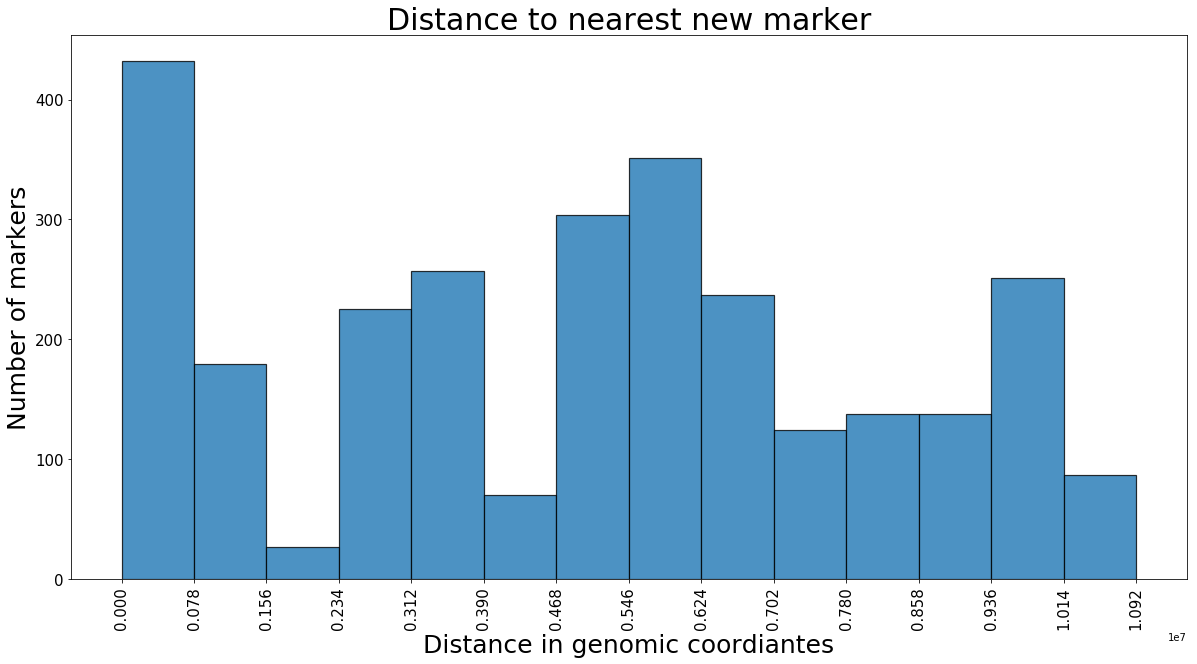

5250077.5


In [61]:
""" How close are old markers to new ones, on average and in general? """

plt.figure(figsize=(20, 10))
counts, bins, patches = plt.hist(min_distances, alpha=0.8, bins=util.bincount_scott(min_distances), edgecolor="black", linewidth=1.2)
plt.title("Distance to nearest new marker", fontsize=30)
plt.xticks(bins, fontsize=15, rotation="vertical")
plt.xlabel("Distance in genomic coordiantes", fontsize=25)
plt.yticks(fontsize=15)
plt.ylabel("Number of markers", fontsize=25)
plt.savefig("./img/distance_to_new_markers.png", dpi=300)
plt.show()

print(np.median(min_distances))

# pd.DataFrame(list(zip(np.round(bins), counts)), columns=["bin_left_border", "num_markers"]).to_csv("./img/distance_to_new_markers.csv", sep='\t', index=False)

In [9]:
""" Dump the interpolated genotypes on disc. """

%%time

predicted_rows = []
for old_marker, nearest_new in old_markers2new_markers.items():
    predicted_rows.append(np.hstack((old_marker, new_gen_df[short2full[nearest_new]].values + 1)))
predicted_df = pd.DataFrame(predicted_rows, columns=np.hstack(("SNP", new_gen_df["strain"])))
predicted_df.to_csv("./data/eQTLs/interpolated_genotypes.csv", sep='\t', index=False)


CPU times: user 4.38 s, sys: 80 ms, total: 4.46 s
Wall time: 4.58 s


## Analyzing new data: eQTLs

In [4]:
""" How many eQTLs are in both real and interpolated data? """

len(np.intersect1d(
    list(map(tuple, qtls_df["eQTLs_interpolated"][["SNP", "gene"]].values)), 
    list(map(tuple, qtls_df["eQTLs_old"][["SNP", "gene"]].values))
))

3672

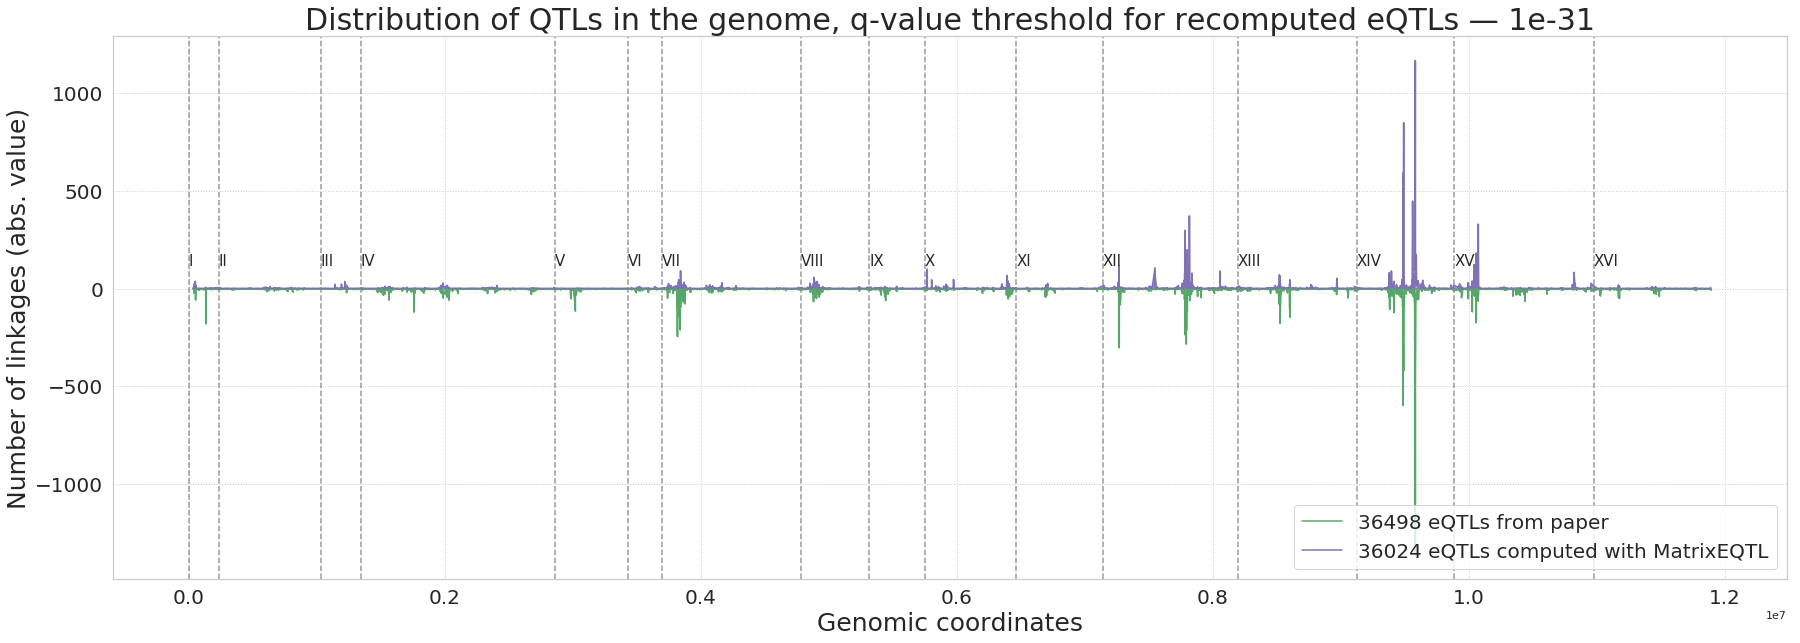

CPU times: user 2.46 s, sys: 64 ms, total: 2.53 s
Wall time: 2.52 s


In [31]:
%%time
""" Plot the distributions of each QTL dataset"""
reload(qtls)

sns.set(style="whitegrid")

roman2arabic = {"I":1, "II":2, "III":3, "IV":4, "V":5, "VI":6, "VII":7, "VIII":8, "IX":9, "X":10, "XI":11, "XII":12, "XIII":13, "XIV":14, "XV":15, "XVI":16}
arabic2roman = {val:key for key, val in roman2arabic.items()}

q_value_threshold = 1e-3
with open("./data/genotypes/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/genotypes/chromosome_endpoints.pkl", "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)

old_eQTL_markers, old_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_old"])
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_interpolated"].query("q_value <= {}".format(q_value_threshold)))
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))
new_eQTL_markers, new_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_new"])
pQTL_markers, pQTL_y = qtls.linkages2gencoords(qtls_df["pQTLs"])
# recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(qtls_df["recomputed_new_eQTLs"][qtls_df["recomputed_new_eQTLs"]["q.value"] <= 1e-32])
recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))

old_eQTL_x = list(map(marker2location.get, old_eQTL_markers))
# interpolated_eQTL_x = list(map(marker2location.get, interpolated_eQTL_markers))
new_eQTL_x = list(map(marker2location.get, new_eQTL_markers))
pQTL_x = list(map(marker2location.get, pQTL_markers))
recomputed_new_eQTL_x = list(map(marker2location.get, recomputed_new_eQTL_markers)) 

colors_dict = dict(zip(["old_eQTLs", "interpolated_eQTLs", "new_eQTLs", "pQTLs", "recomputed_new_eQTLs"], plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]))

plt.figure(figsize=(30, 10))
plt.title("Distribution of QTLs in the genome, q-value threshold for recomputed eQTLs — 1e-31".format(q_value_threshold * 100.), fontsize=30)
for n in range(1, 17):
    plt.axvline(x=chromosome_endpoints[n-1], linestyle='--', color='grey', alpha=0.8)
    plt.text(chromosome_endpoints[n-1], 120, arabic2roman[n], fontsize=15)
# plt.plot(old_eQTL_x, old_eQTL_y, label="old_eQTLs", color=colors_dict["old_eQTLs"])
# plt.fill_between(old_eQTL_x, 0, old_eQTL_y, alpha=0.5, color=colors_dict["old_eQTLs"])
# chunks = np.linspace(0, chromosome_endpoints[16], 100)
# vals = np.zeros(len(chunks))
# for i in range(len(chunks) - 1):
#     vals[i] = sum((chunks[i] < val < chunks[i + 1] for val in interpolated_eQTL_x))
# plt.step(chunks, -vals, label="markers in chunk", color=plt.rcParams["axes.prop_cycle"].by_key()["color"][0])
# plt.plot(interpolated_eQTL_x, interpolated_eQTL_y, label="interpolated_eQTLs", alpha=0.7, color=colors_dict["interpolated_eQTLs"])
# plt.fill_between(interpolated_eQTL_x, 0, interpolated_eQTL_y, alpha=0.5, color=colors_dict["interpolated_eQTLs"])
plt.plot(new_eQTL_x, -new_eQTL_y, label="36498 eQTLs from paper", alpha=1, color=colors_dict["new_eQTLs"])
plt.fill_between(new_eQTL_x, 0, -new_eQTL_y, alpha=0.7, color=colors_dict["new_eQTLs"])
# plt.plot(pQTL_x, pQTL_y, label="pQTLs", alpha=0.7, color=colors_dict["pQTLs"])
# plt.fill_between(pQTL_x, 0, pQTL_y, alpha=0.5, color=colors_dict["pQTLs"])
plt.plot(recomputed_new_eQTL_x, recomputed_new_eQTL_y, label="36024 eQTLs computed with MatrixEQTL", alpha=1, color=colors_dict["recomputed_new_eQTLs"])
plt.fill_between(recomputed_new_eQTL_x, 0, recomputed_new_eQTL_y, alpha=0.7, color=colors_dict["recomputed_new_eQTLs"])
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=4)
plt.grid(linestyle="dotted")
plt.savefig("./img/qtl_distributions/qtls_combined.png", dpi=300)
plt.show()


In [157]:
for module_name, module_genes in tqdm(modules_dict.items()):
    module_graph = interactome_graph.subgraph(
        np.intersect1d(module_genes, interactome_graph.vs["name"])
    ).simplify()
    module_graph.vs.select(_degree=0).delete()
    if module_graph.vcount() > 0:
        qtls.plot_module_graph(
            destdir="./results/{}/new_eQTLs/".format(modules_type), 
            module_graph=module_graph, 
            qtl_df=qtls_df["eQTLs_new"], 
            filename=module_name
        )

NameError: name 'modules_dict' is not defined

## ModuleQTLs: concept introduction and rationale

In [33]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_pred_df = pd.read_table("./archive/{}/eQTLs_old/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    interpolated_pred_df = pd.read_table("./archive/{}/eQTLs_interpolated/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: predicting pQTLs via eQTLs & PPIN".format(modules_type), fontsize=25)
    plt.plot(old_pred_df["overlap_ratio"].values, label="old_eQTLs")
    plt.fill_between(range(len(old_pred_df["overlap_ratio"].values)), 0, old_pred_df["overlap_ratio"].values, alpha=0.3)
    plt.plot(-interpolated_pred_df["overlap_ratio"].values, label="interpolated_eQTLs")
    plt.fill_between(range(len(interpolated_pred_df["overlap_ratio"].values)), -interpolated_pred_df["overlap_ratio"].values, 0, alpha=0.3)
    plt.xlabel("Number of functional module in sorted order", fontsize=15)
    plt.ylabel("Percentage of pQTLs predicted correctly", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/pQTL_prediction/{}_pQTLs_prediction_old_interpolated.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


In [35]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_intersection_df = pd.read_table("./archive/{}/eQTLs_old/eQTL_pQTL_intersection.csv".format(modules_type))
    interpolated_intersection_df = pd.read_table("./archive/{}/eQTLs_interpolated/eQTL_pQTL_intersection.csv".format(modules_type))
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: eQTL/pQTL intersection".format(modules_type), fontsize=25)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["real_modules"].values, label="old eQTLs, real modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["real_modules"].values, alpha=0.3)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["random_modules"].values, label="old eQTLs, random modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["random_modules"].values, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["real_modules"].values, label="interpolated eQTLs, real modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["real_modules"].values, 0, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["random_modules"].values, label="interpolated eQTLs, random modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["random_modules"].values, 0, alpha=0.3)
    plt.xscale('log')
    plt.xlabel("q-value threshold", fontsize=15)
    plt.ylabel("Jaccard coefficient", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/eQTL_pQTL_intersection/{}.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


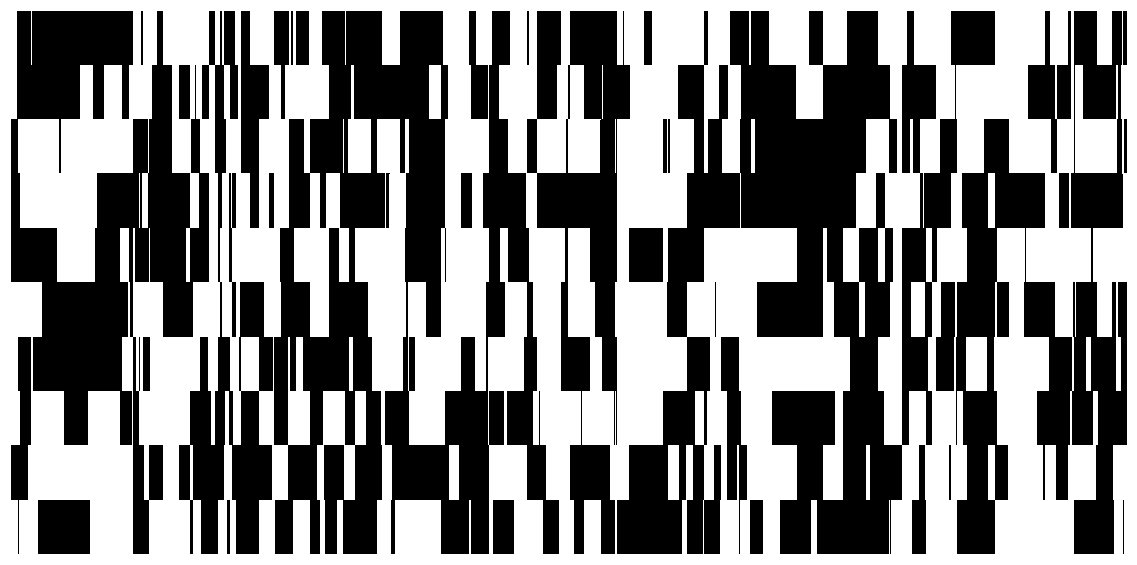

In [5]:
import seaborn as sns

plt.figure(figsize=(20, 10))
frame_start = np.random.RandomState().choice(range(1, genotypes_df["eQTLs_new"].shape[1] // 2))
frame_end = frame_start + 10
genotype_rows = genotypes_df["eQTLs_new"].iloc[:, frame_start:frame_end].values.T
genotype_rows[genotype_rows == 2] = 1
# genotype_rows += stats.uniform().rvs(size=genotype_rows.shape)
sns.heatmap(genotype_rows, xticklabels=False, yticklabels=False, cbar=False, cmap="Greys");
plt.savefig("./img/inheritance_patterns")
# plt.show()


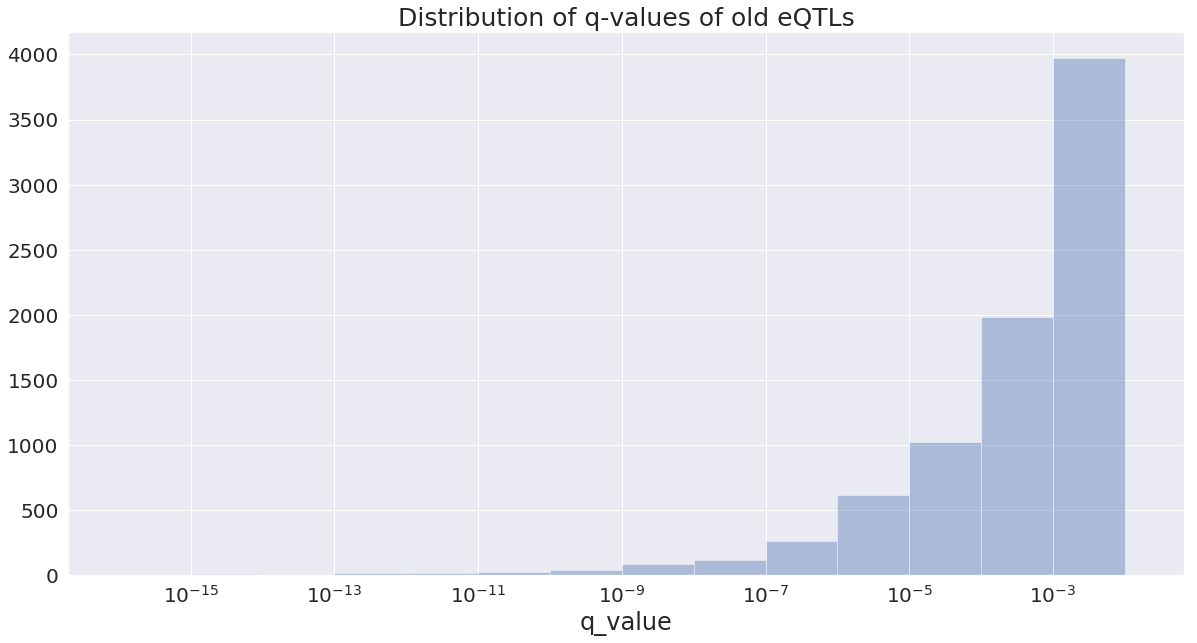

In [28]:
qtls_df["eQTLs_new_generated"] = pd.read_table("./data/eQTLs/new_qtls_from_scratch.csv")
qtls_df["eQTLs_new_generated"].columns = ["SNP", "gene", "p_value", "q_value"] 


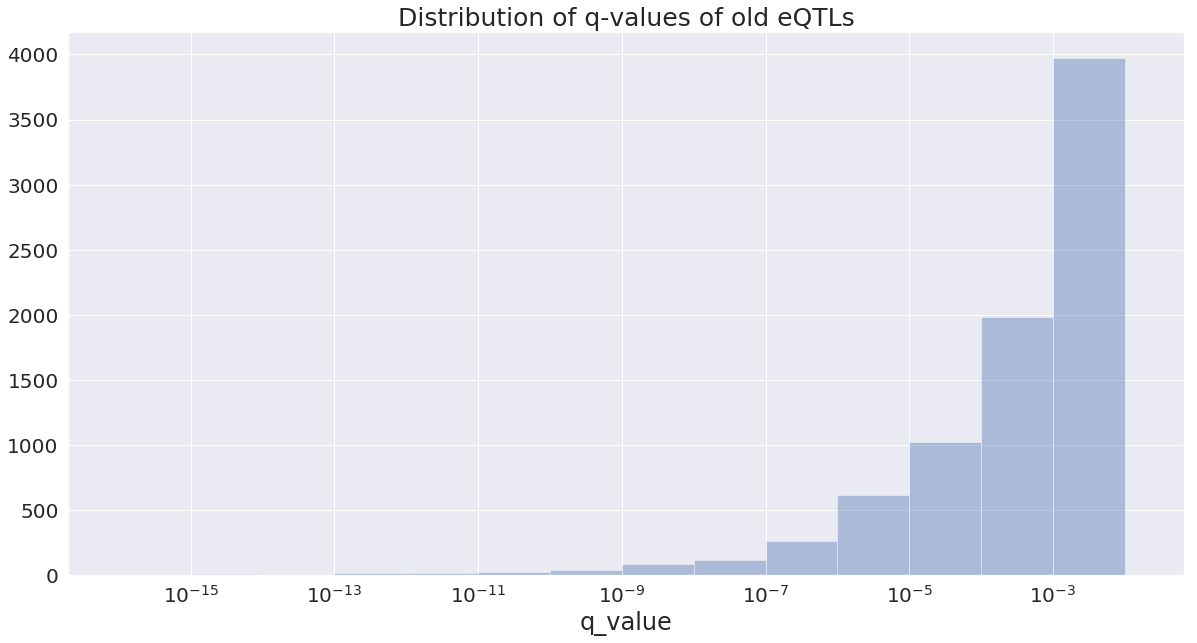

In [70]:
plt.figure(figsize=(20, 10))
plt.title("Distribution of q-values of old eQTLs", fontsize=25)
plt.xscale("log")
sns.set(color_codes=True)
sns.distplot(bins=10.**np.arange(-16, -1), a=qtls_df["pQTLs"]["q_value"], kde=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./img/qtl_computing/pQTLs_old.png", dpi=300)
plt.show()
plt.close()


In [96]:
fdr_cutoffs = np.append(10. ** np.arange(-16, -1), 0.05)
i = 0
partial_leq = np.zeros_like(fdr_cutoffs)
for i, q_thr in enumerate(fdr_cutoffs):
    partial_leq[i] = len(
        set(map(tuple, qtls_df["eQTLs_old"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values)) & 
        set(map(tuple, qtls_df["pQTLs"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values))
    )
partial_leq = np.cumsum(partial_leq)

In [97]:
pd.DataFrame(
    np.column_stack((fdr_cutoffs, partial_leq)),
    columns=["q_value_threshold", "linkages_below"]
)

,q_value_threshold,linkages_below
0,1.000000e-16,0.0
1,1.000000e-15,0.0
2,1.000000e-14,0.0
3,1.000000e-13,0.0
4,1.000000e-12,0.0
5,1.000000e-11,9.0
6,1.000000e-10,33.0
7,1.000000e-09,63.0
8,1.000000e-08,119.0
9,1.000000e-07,190.0


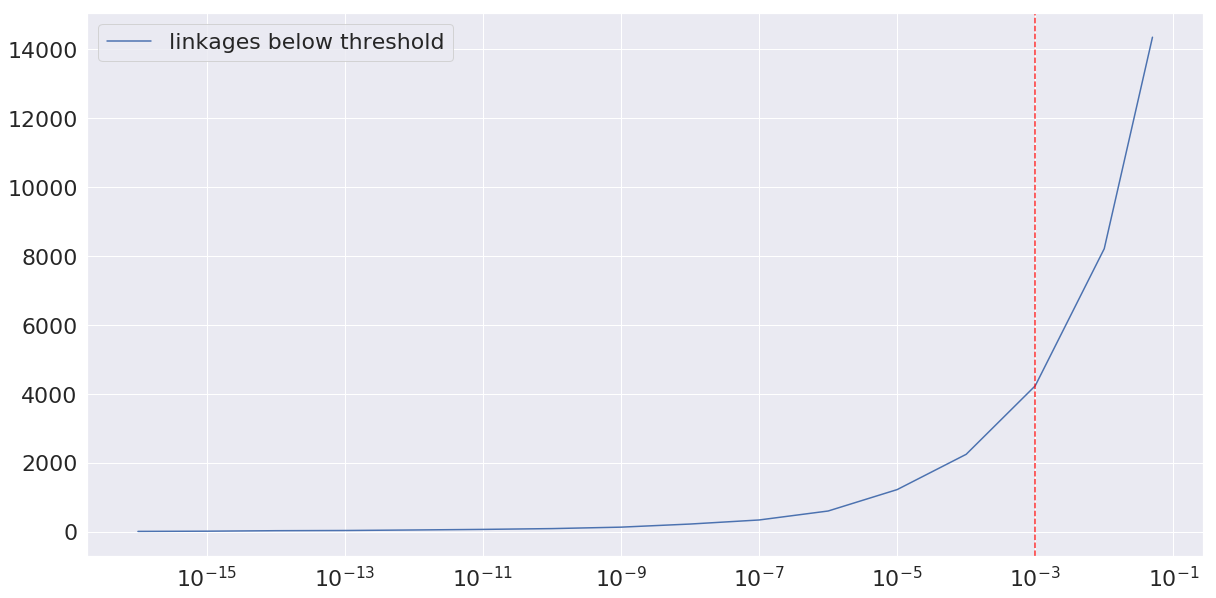

In [75]:
plt.figure(figsize=(20, 10))
plt.xscale("log")
sns.set(font_scale=2)
sns.lineplot(fdr_cutoffs, partial_leq, label="linkages below threshold")
plt.axvline(x=1e-3, linestyle="--", color="red", alpha=0.8)
plt.savefig("./img/qtl_computing/pQTLs_old_lineplot.png", dpi=300)
plt.show()
plt.close()


In [ ]:
""" Generating data for GFLasso """

module_genes = sorted(
    set(modules_dict["Respiration, oxidative phosphorylation, mitochondrial targeting"]) 
    & set(interactome_graph.vs["name"])
    & set(expression_df["eQTLs_old"].dropna()["gene"].values)
)
linked_markers = sorted(qtls_df["eQTLs_old"][qtls_df["eQTLs_old"]["gene"].isin(module_genes)]["SNP"].values)
genotypes = genotypes_df["eQTLs_old"][genotypes_df["eQTLs_old"]["SNP"].isin(linked_markers)].sort_values(by="SNP")
genotypes.dropna(inplace=True)
for colname in genotypes.columns[1:]:
    genotypes[colname] = genotypes[colname] - 1
expression = expression_df["eQTLs_old"][expression_df["eQTLs_old"]["gene"].isin(module_genes)].dropna().sort_values(by="gene")
genotypes.T.to_csv("./genotypes.csv", sep='\t', index=False)
expression.T.to_csv("./expression.csv", sep='\t', index=False)

incidence_matrix = np.zeros(shape=(len(module_genes), len(module_genes)), dtype=int)
for i in range(incidence_matrix.shape[0]):
    for j in range(incidence_matrix.shape[1]):
        if i != j and interactome_graph.are_connected(module_genes[i], module_genes[j]):
            incidence_matrix[i][j] = 1
np.savetxt(fname="./incidence_matrix.txt", X=incidence_matrix, fmt="%d")

In [5]:
%%time
""" Reproducing QTL mapping technique from https://elifesciences.org/articles/35471 """

from sklearn import preprocessing
import warnings

random.seed(time.time())
chromosome2markers = {i : genotypes_df["eQTLs_old"].groupby("chromosome").get_group(i)["SNP"] for i in range(1, 17)}


def nan_to_zero_then_scale(data, inplace=False, axis=1):
    """
    :param data: numpy ndarray; numerical at best, but type-casting is taken care of
    :param axis: integer; axis to scale along   
    :param inplace: boolean; whether to create a copy or to modify the matrix in-place
    :return: numerical numpy ndarray of the same shape with zero mean and unit variance along specified axis
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return preprocessing.scale(
            np.nan_to_num(data.astype(np.float32), copy=not inplace),
            axis=axis, copy=not inplace
        )


def linkage_LOD_scores(genotypes_matrix, expression_matrix, inplace=False):
    """
    LOD_score(gene, marker) = -n_strains * log(1 - r^2) / (2 log(10)),
    where r is the Pearson correlation coefficient between vectors of
    gene's expression values and marker's inheritance patterns among strains.
    Exact formula for LOD score was taken from this paper: https://elifesciences.org/articles/35471  
    
    :param genotypes_matrix: numerical matrix, dimensions = n_markers x n_strains; 
                             we used -1 for BY allele and 1 for RM allele, but this choice 
                             of numerical representation is rather arbitrary  
    :param expression_matrix: numerical matrix, dimensions = n_genes x n_strains
    :param inplace_flag: boolean flag, introduces side effects, but saves memory by pre-processing matrices in-place  
    :return: numerical n_genes x n_markers matrix; (i, j)-th entry is a LOD-score of (gene_i, marker_j) linkage.
    
    """
    # if samples X and Y are centered and scaled, their Pearson's r-coefficient
    # is simply (their dot product) / (samples'_size - 1).
    # Matrix multiplication can be used to speed up the computation of Pearson's r-coefficients
    # between rows of genotypes_matrix and rows of expression matrix.
    n_strains = genotypes_matrix.shape[1]
    pearsonr = np.matmul(
        nan_to_zero_then_scale(expression_matrix, inplace),
        nan_to_zero_then_scale(genotypes_matrix, inplace).T
    ) / (n_strains - 1)
    return -n_strains * np.log(1 - pearsonr ** 2) / (2 * np.log(10))


""" Finding peak LOD-score-per-chromosome markers for each gene as in https://elifesciences.org/articles/35471 """


def preprocessing_candidate_linkages(expression_df, genotypes_df, output_dict=None):
    """
    Pretty useless function, will be removed soon.
    :param expression_df:  
    :param genotypes_df: 
    :param output_dict: 
    :return: dict: str —> list; mapping between genes and markers with peak LOD-scores for those genes   
    """
    
    """ 
        Нужно выбрасывать маркеры, которые уже входят в модель!
        Хотя они, по идее, не должны снова обнаруживаться, но кто знает...
        Эту функцию нужно либо убрать совсем, либо разбить на несколько... 
        В текущем виде её сложно переиспользовать.  
    """
    
    gene2peak_LOD_markers = collections.defaultdict(list) if output_dict is None else output_dict
    expression_matrix = expression_df.values[:, 1:].astype(np.float32)
    genotypes_matrix = genotypes_df.values[:, 1:-2].astype(np.float32) - 1
    
    LOD_scores = linkage_LOD_scores(genotypes_matrix, expression_matrix, inplace=True)
    peak_LOD_marker_ids = np.argmax(LOD_scores, axis=1)
    peak_LOD_values = np.max(LOD_scores, axis=1)

    candidate_linkages_df = pd.DataFrame(
        [(genotypes_df["SNP"].values[peak_LOD_marker_ids[i]], gene, peak_LOD_values[i])
         for i, gene in enumerate(expression_df["gene"])],
        columns=["SNP", "gene", "LOD"]
    )

    for marker, gene in candidate_linkages_df.query("LOD >= 3.5")[["SNP", "gene"]].values:
        if marker not in gene2peak_LOD_markers[gene]:
            gene2peak_LOD_markers[gene].append(marker)
    return gene2peak_LOD_markers


import sklearn.linear_model
def compute_residual_expression(expression_dataframe, genotypes_dataframe, gene2peak_LOD_markers):
    """
    Fits a linear model: E = QG + R, 
        where E stands for expression profile of a particular gene, 
        G — for markers (one or several) with peak LOD-scores for that gene,
        Q — for coefficients of the linear model,
        R — for residual expression of that gene
    :param expression_dataframe: pandas dataframe; columns — "["gene"] + phenotypes"
    :param genotypes_dataframe: pandas dataframe; columns — "["SNP"] + phenotypes + ["chromosome", "position"]"
                                -1 stands for BY allele, 1 — for RM allele, 0 — for NaN 
    :param gene2peak_LOD_markers: dict: str —> list; mapping between genes and markers with peak LOD-scores for those genes.   
                                    Inheritance patterns of those markers are predictors in linear model. 
    :return: pandas dataframe; residual expression values for genes in initial expression dataframe
    """
    expression_matrix = np.nan_to_num(expression_dataframe.values[:, 1:].astype(np.float32))
    genotypes_matrix = np.nan_to_num(genotypes_dataframe.values[:, 1:-2].astype(np.float32) - 1)
    
    n_models_unchanged = 0
    residual_expression = []
    for gene in expression_dataframe["gene"]:
        y = expression_matrix[expression_dataframe["gene"] == gene].T
        large_effect_markers = gene2peak_LOD_markers[gene]
        if len(large_effect_markers) == 0:
            # If no marker has a significant effect on expression of a particular gene,
            # then its expression profile remains untouched.
            n_models_unchanged += 1
            residual_expression.append(y.T)
        else:
            # Otherwise a linear model gets fitted.
            lm = sklearn.linear_model.LinearRegression()
            X = genotypes_matrix[genotypes_dataframe["SNP"].isin(large_effect_markers)].T
            lm.fit(X, y)
            # New expression profile is a vector of residuals in the language of linear models.
            residual_expression.append(np.ravel(y - lm.predict(X)))
    # Dataframe with residual expression values is later used instead of the original dataframe 
    residual_expression_dataframe = pd.DataFrame(
        np.column_stack(
            (expression_dataframe["gene"], 
             np.vstack(residual_expression))
        ), 
        columns=expression_dataframe.columns
    )
    print("No markers added to the model for {} genes out of {}".format(
        n_models_unchanged, expression_dataframe.shape[0])
    )
    return residual_expression_dataframe

CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
Wall time: 17.1 ms


In [36]:
chromosome_dataframe = genotypes_dataframe.groupby("chromosome").get_group(2)
gene2peak_LOD_markers = preprocessing_candidate_linkages(expression_dataframe, chromosome_dataframe)
residual_expression_dataframe = compute_residual_expression(expression_dataframe, chromosome_dataframe, gene2peak_LOD_markers)


No markers added to the model for 5470 genes out of (6159, 113)


Expression matrices differ in 77168 entries


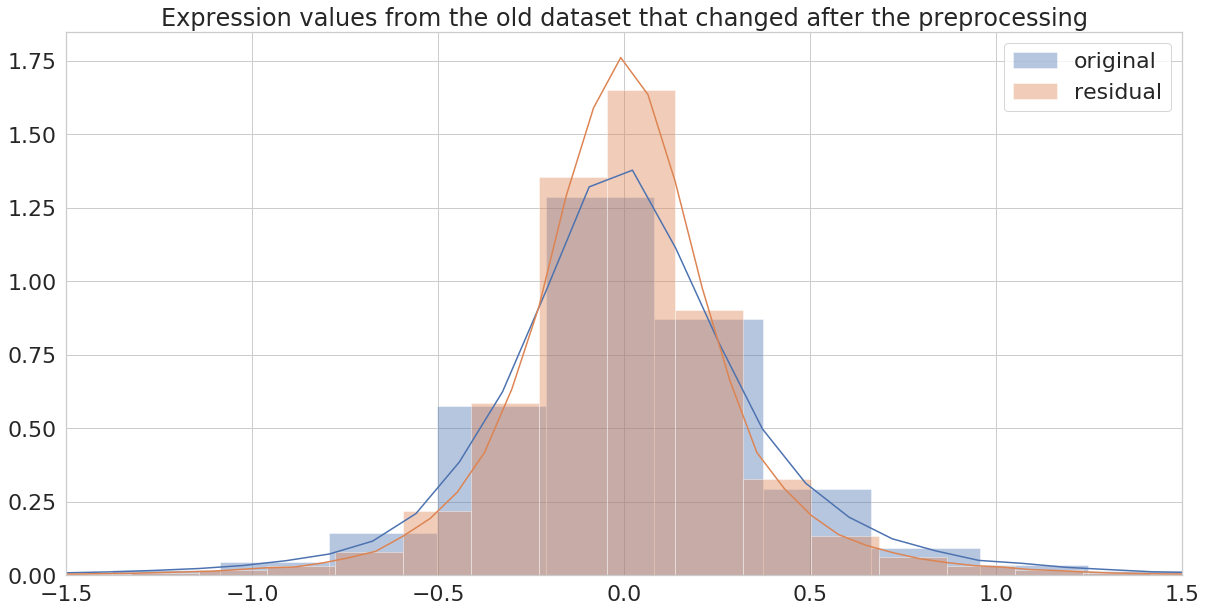

In [68]:
residual_expression_mx = np.nan_to_num(residual_expression_dataframe.values[:, 1:].astype(np.float32))
expression_mx = np.nan_to_num(expression_dataframe.values[:, 1:].astype(np.float32))

sns.set(style="whitegrid", font_scale=2)
# fig, axes = plt.subplots(1, 2, figsize=(30, 10))
plt.figure(figsize=(20, 10))
plt.title("Expression values from the old dataset that changed after the preprocessing")
discrepancy_mask = residual_expression_mx != expression_mx
# residual_expression_mx[np.logical_not(discrepancy_mask)] = 0
# expression_mx[np.logical_not(discrepancy_mask)] = 0
print("Expression matrices differ in {} entries".format(np.sum(discrepancy_mask)))
# plt.xscale("log")
# plt.xlabel("number of measurements")
# plt.ylabel("expression value")
plt.xlim((-1.5, 1.5))
sns.distplot(expression_mx[discrepancy_mask], label="original")
sns.distplot(residual_expression_mx[discrepancy_mask], label="residual")
# plt.axhline(y=0, color="red", linestyle="--", alpha=0.5)
# plt.scatter(range(np.sum(discrepancy_mask)), residual_expression_mx[discrepancy_mask], label="residual", alpha=0.5)
# plt.scatter(range(np.sum(discrepancy_mask)), expression_mx[discrepancy_mask], label="initial", alpha=0.5)
plt.legend()

# sns.heatmap(residual_expression_mx, ax=axes[0], cmap="Accent")
# sns.heatmap(expression_mx, ax=axes[1], cmap="Accent")
plt.show()
plt.close()


In [62]:
print(np.mean(expression_mx), np.mean(residual_expression_mx))

0.0035883358 0.0022206435


In [30]:
%%time
""" Mapping eQTLs as in https://elifesciences.org/articles/35471 """


def map_qtls(expression_dataframe, genotypes_dataframe):
    qtl_list = []
    for chromosome_id in trange(1, 17)):
        chromosome_dataframe = genotypes_dataframe.groupby("cМы просто были заняты холодосомhromosome").get_group(chromosome_id)
        # Find background QTLs (as described in the preprocessing step) and adjust expression values
        # to cancel out their effect by adding those QTLs to linear model for expression of a gene they
        # influence, fitting it and using residuals instead of original expression data.
        
        """ THIS PART IS DAMAGED """
        
        gene2peak_LOD_markers = collections.defaultdict(list)
        residual_expression_dataframe = expression_dataframe
        
        # preprocessing_iterations = 0
        # for i in range(preprocessing_iterations):
        #     # On each iteration at most one marker is added to linear model.
        #     # In the paper the process was iterated three times.
        #     gene2peak_LOD_markers = preprocessing_candidate_linkages( 
        #         residual_expression_dataframe, chromosome_dataframe, gene2peak_LOD_markers
        #     )
        #     residual_expression_dataframe = residual_expression(
        #         residual_expression_dataframe, chromosome_dataframe, gene2peak_LOD_markers
        #     )
        

        iter_count = 0
        finding_linkages = True
        # gene2peak_LOD_markers = collections.defaultdict(list)
        while(finding_linkages):
            print("Iteration {}:".format(iter_count))
            genotypes_matrix = nan_to_zero_then_scale(chromosome_dataframe.values[:, 1:-2].astype(np.float32) - 1)
            expression_matrix = nan_to_zero_then_scale(residual_expression_dataframe.values[:, 1:].astype(np.float32))

            LOD_scores = linkage_LOD_scores(genotypes_matrix, expression_matrix)
            peak_LOD_marker_ids = np.argmax(LOD_scores, axis=1)
            peak_LOD_values = np.max(LOD_scores, axis=1)

            # All (marker, gene) pairs with the highest LOD score per gene are initially considered to be QTLs 
            candidate_linkages_dataframe = pd.DataFrame(
                [(chromosome_dataframe["SNP"].values[peak_LOD_marker_ids[i]], gene, peak_LOD_values[i])
                 for i, gene in enumerate(residual_expression_dataframe["gene"])],
                columns=["SNP", "gene", "LOD"]
            )
            
            # print("Before: linkages — {}, min — {}, max — {}, mean — {}".format(
            #     candidate_linkages_dataframe.shape[0],
            #     candidate_linkages_dataframe["LOD"].min(), 
            #     candidate_linkages_dataframe["LOD"].max(),
            #     candidate_linkages_dataframe["LOD"].mean()
            # ))
            
            # Then LOD-score significance threshold is derived using permutations test.
            # There are 151 threshold candidates at the moment, ranging from 1.5 to 9 with step value of 0.05.
            # There are 1000 randomization iterations for each threshold.  
            # Phenotypes are permuted on each iteration, while the genotypes remain the same.
            # Then LOD-scores are calculated. Markers with peak LOD-per-gene with LOD-scores higher than current threshold get counted. 
            # Average of those counts is an expected number of linkages with LOD-scores above current threshold.
            # The lowest LOD-score threshold, such that the ratio of expected number of linkages above that threshold
            # to the observed number of such linkages is less than 0.05, is taken as a significance threshold.

            LOD_thresholds = np.arange(1.5, 9.05, 0.05)
            significance_threshold = np.nan
            n_permutations = 100
            
            print(len(gene2peak_LOD_markers.keys()))
            print(residual_expression_dataframe.shape, chromosome_dataframe.shape)
            
            for fdr_cutoff in LOD_thresholds:
                observed = candidate_linkages_dataframe.query("LOD >= {}".format(fdr_cutoff)).shape[0]
                if observed == 0:
                    break
                random_linkages_in_total = 0
                for _ in range(n_permutations):
                    column_permutation = np.random.permutation(range(expression_matrix.shape[1]))
                    permuted_expression_matrix = expression_matrix[:, column_permutation]
                    permuted_LOD_scores = linkage_LOD_scores(genotypes_matrix, permuted_expression_matrix)
                    permuted_peak_LOD_values = np.max(permuted_LOD_scores, axis=1)
                    random_linkages_in_total += np.count_nonzero(permuted_peak_LOD_values >= fdr_cutoff)
                expected = random_linkages_in_total / n_permutations
                if expected >= observed:
                    break
                print("{:.3}: {} <> {}\t{}".format(fdr_cutoff, expected, observed, expected / observed))
                if expected / observed < 0.05:
                    significance_threshold = fdr_cutoff
                    break
            if np.isnan(significance_threshold):
                finding_linkages = False
                print("{}: Such a pity...".format(chromosome_id))
            else:
                candidate_linkages_dataframe = candidate_linkages_dataframe.query("LOD >= {}".format(significance_threshold))
                # print("After: linkages — {}, min — {}, max — {}, mean — {}".format(
                #     candidate_linkages_dataframe.shape[0],
                #     candidate_linkages_dataframe["LOD"].min(), 
                #     candidate_linkages_dataframe["LOD"].max(),
                #     candidate_linkages_dataframe["LOD"].mean()
                # ))
                qtl_list.extend(candidate_linkages_dataframe[["SNP", "gene"]].values)
                print("Chromosome: {}\tratio: {:.2}\t linkages: {}".format(
                    chromosome_id,
                    significance_threshold,
                    candidate_linkages_dataframe.shape[0])
                )
                for marker, gene in candidate_linkages_dataframe[["SNP", "gene"]].values:
                    if marker not in gene2peak_LOD_markers[gene]:
                        gene2peak_LOD_markers[gene].append(marker)
                       
                residual_expression_dataframe = compute_residual_expression(
                    residual_expression_dataframe, chromosome_dataframe, gene2peak_LOD_markers
                )
                residual_expression_dataframe = residual_expression_dataframe[
                    residual_expression_dataframe["gene"].isin(
                       [gene_name for gene_name, large_effect_markers in gene2peak_LOD_markers.items() 
                        if len(large_effect_markers) != 0]
                    ) 
                ]
                
                # sns.set(style="whitegrid", font_scale=2)
                # plt.figure(figsize=(20, 10))
                # plt.title("Expression values from the old dataset that changed after linear model fitting")
                # discrepancy_mask = nan_to_zero_then_scale(residual_expression_dataframe.values[:, 1:].astype(np.float32)) != expression_matrix
                # print("Expression matrices differ in {} entries".format(np.sum(discrepancy_mask)))
                # plt.xlim((-3, 3))
                # sns.distplot(expression_mx, label="original")
                # sns.distplot(nan_to_zero_then_scale(residual_expression_dataframe.values[:, 1:].astype(np.float32)), label="residual")
                # plt.legend()
                # plt.show()
                # plt.close()
            iter_count += 1
    unique_qtls_list = list(set(map(tuple, qtl_list)))
    return np.asarray(unique_qtls_list, dtype=np.str)

# expression_dataframe = expression_df["eQTLs_old"].drop(["BY", "RM"], axis=1)
expression_dataframe = expression_df["eQTLs_new"]
# gene_occurences = collections.Counter(expression_dataframe["gene"].values)
# expression_dataframe = expression_dataframe[[
#     gene_occurences[gene] == 1 for gene in expression_dataframe["gene"]
# ]]
genotypes_dataframe = pd.read_table("./data/eQTLs/genotypes_2018_filtered.csv")
# genotypes_dataframe = genotypes_df["eQTLs_old"].drop(["BY", "RM"], axis=1)
qtl_list = map_qtls(expression_dataframe, genotypes_dataframe) 

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 0:


0
(5720, 1013) (193, 1015)


1.5: 681.88 <> 1643	0.4150213024954352


1.55: 590.08 <> 1537	0.38391672088484063


1.6: 575.58 <> 1444	0.398601108033241


1.65: 469.72 <> 1358	0.34589101620029455


1.7: 421.33 <> 1262	0.3338589540412044


1.75: 422.66 <> 1190	0.3551764705882353


1.8: 331.59 <> 1134	0.2924074074074074


1.85: 291.54 <> 1070	0.2724672897196262


1.9: 295.39 <> 1015	0.2910246305418719


1.95: 260.67 <> 959	0.27181438998957247


2.0: 246.22 <> 905	0.2720662983425414


2.05: 214.17 <> 859	0.24932479627473805


2.1: 249.04 <> 812	0.3066995073891626


2.15: 173.45 <> 781	0.22208706786171573


2.2: 170.23 <> 741	0.22973009446693657


2.25: 122.38 <> 705	0.17358865248226948


2.3: 137.61 <> 672	0.20477678571428573


2.35: 95.49 <> 645	0.14804651162790697


2.4: 70.0 <> 613	0.11419249592169657


2.45: 101.65 <> 572	0.17770979020979022


2.5: 63.62 <> 549	0.11588342440801457


2.55: 73.65 <> 529	0.1392249527410208


2.6: 60.08 <> 511	0.11757338551859099


2.65: 54.01 <> 497	0.10867203219315895


2.7: 71.38 <> 478	0.1493305439330544


2.75: 40.8 <> 460	0.08869565217391304


2.8: 39.11 <> 441	0.08868480725623583


2.85: 37.9 <> 430	0.08813953488372092


2.9: 26.32 <> 414	0.06357487922705314


2.95: 22.2 <> 401	0.05536159600997506


3.0: 31.92 <> 388	0.08226804123711341


3.05: 26.85 <> 377	0.07122015915119363


3.1: 17.42 <> 364	0.04785714285714286
Chromosome: 1	ratio: 3.1	 linkages: 364


No markers added to the model for 5356 genes out of 5720
Iteration 1:
5720
(364, 1013) (193, 1015)


  6%|▋         | 1/16 [06:10<1:32:36, 370.46s/it]

1: Such a pity...
Iteration 0:


0
(5720, 1013) (943, 1015)


1.5: 1795.01 <> 1988	0.9029225352112676


1.55: 1686.01 <> 1885	0.8944350132625994


1.6: 1431.4 <> 1791	0.7992183137911781


1.65: 1304.24 <> 1692	0.7708274231678487


1.7: 1179.47 <> 1613	0.7312275263484191


1.75: 1006.32 <> 1520	0.6620526315789474


1.8: 915.63 <> 1444	0.6340927977839335


1.85: 937.83 <> 1364	0.687558651026393


1.9: 827.28 <> 1295	0.6388262548262548


1.95: 725.82 <> 1233	0.5886618004866181


2.0: 621.14 <> 1178	0.5272835314091681


2.05: 546.14 <> 1105	0.4942443438914027


2.1: 514.1 <> 1051	0.4891531874405328


2.15: 458.11 <> 999	0.4585685685685686


2.2: 485.9 <> 949	0.5120126448893572


2.25: 444.74 <> 914	0.48658643326039386


2.3: 403.11 <> 868	0.4644124423963134


2.35: 303.21 <> 831	0.3648736462093863


2.4: 321.36 <> 799	0.4022027534418023


2.45: 280.38 <> 768	0.365078125


2.5: 237.5 <> 740	0.32094594594594594


2.55: 213.59 <> 708	0.30168079096045197


2.6: 232.08 <> 679	0.3417967599410899


2.65: 160.21 <> 655	0.24459541984732824


2.7: 183.13 <> 640	0.286140625


2.75: 120.16 <> 621	0.19349436392914654


2.8: 101.97 <> 596	0.17109060402684564


2.85: 94.95 <> 580	0.16370689655172413


2.9: 110.24 <> 563	0.1958081705150977


2.95: 81.75 <> 542	0.15083025830258304


3.0: 94.61 <> 519	0.18229287090558766


3.05: 57.34 <> 505	0.11354455445544555


3.1: 46.41 <> 494	0.09394736842105263


3.15: 48.06 <> 482	0.09970954356846473


3.2: 57.41 <> 476	0.12060924369747898


3.25: 45.43 <> 460	0.09876086956521739


3.3: 52.47 <> 445	0.11791011235955055


3.35: 27.75 <> 431	0.06438515081206496


3.4: 41.15 <> 414	0.09939613526570049


3.45: 23.26 <> 407	0.057149877149877154


3.5: 20.73 <> 397	0.05221662468513854


3.55: 23.89 <> 387	0.0617312661498708


3.6: 22.61 <> 383	0.059033942558746735


3.65: 18.95 <> 381	0.049737532808398946
Chromosome: 2	ratio: 3.7	 linkages: 381


No markers added to the model for 5339 genes out of 5720
Iteration 1:
5720
(381, 1013) (943, 1015)


1.5: 118.09 <> 164	0.7200609756097561


1.55: 109.36 <> 158	0.6921518987341773


1.6: 89.29 <> 149	0.599261744966443


1.65: 86.23 <> 142	0.6072535211267606


1.7: 81.43 <> 139	0.5858273381294965


1.75: 75.09 <> 133	0.5645864661654135


1.8: 69.55 <> 128	0.543359375


1.85: 58.22 <> 119	0.4892436974789916


1.9: 54.44 <> 109	0.49944954128440366


1.95: 48.03 <> 103	0.4663106796116505


2.0: 46.59 <> 98	0.47540816326530616


2.05: 41.01 <> 91	0.45065934065934066


2.1: 38.48 <> 86	0.44744186046511625


2.15: 33.81 <> 82	0.41231707317073174


2.2: 28.04 <> 79	0.3549367088607595


2.25: 28.93 <> 77	0.3757142857142857


2.3: 23.35 <> 70	0.3335714285714286


2.35: 21.79 <> 69	0.31579710144927536


2.4: 17.84 <> 66	0.2703030303030303


2.45: 18.83 <> 62	0.3037096774193548


2.5: 15.47 <> 59	0.2622033898305085


2.55: 13.66 <> 59	0.23152542372881357


2.6: 12.23 <> 58	0.21086206896551724


2.65: 12.1 <> 54	0.22407407407407406


2.7: 10.74 <> 52	0.20653846153846153


2.75: 9.02 <> 49	0.1840816326530612


2.8: 9.53 <> 44	0.21659090909090908


2.85: 8.16 <> 40	0.20400000000000001


2.9: 5.78 <> 37	0.15621621621621623


2.95: 5.62 <> 36	0.15611111111111112


3.0: 5.24 <> 36	0.14555555555555555


3.05: 4.23 <> 35	0.12085714285714287


3.1: 4.74 <> 31	0.15290322580645163


3.15: 3.67 <> 27	0.13592592592592592


3.2: 3.31 <> 24	0.13791666666666666


3.25: 2.59 <> 22	0.11772727272727272


3.3: 2.81 <> 22	0.12772727272727272


3.35: 2.83 <> 18	0.15722222222222224


3.4: 2.54 <> 18	0.1411111111111111


3.45: 1.83 <> 18	0.10166666666666667


3.5: 1.51 <> 17	0.0888235294117647


3.55: 1.5 <> 17	0.08823529411764706


3.6: 1.79 <> 15	0.11933333333333333


3.65: 1.43 <> 14	0.10214285714285713


3.7: 1.0 <> 14	0.07142857142857142


3.75: 1.14 <> 14	0.08142857142857142


3.8: 0.88 <> 14	0.06285714285714286


3.85: 0.76 <> 13	0.05846153846153846


3.9: 0.81 <> 12	0.0675


3.95: 0.6 <> 10	0.06


4.0: 0.49 <> 9	0.05444444444444444


4.05: 0.44 <> 8	0.055


4.1: 0.57 <> 8	0.07125


4.15: 0.4 <> 8	0.05


4.2: 0.27 <> 8	0.03375
Chromosome: 2	ratio: 4.2	 linkages: 8


No markers added to the model for 0 genes out of 381
Iteration 2:
5720
(381, 1013) (943, 1015)


1.5: 111.73 <> 160	0.6983125


1.55: 110.2 <> 154	0.7155844155844157


1.6: 102.34 <> 145	0.7057931034482758


1.65: 90.32 <> 138	0.6544927536231884


1.7: 79.02 <> 135	0.5853333333333333


1.75: 74.28 <> 127	0.5848818897637795


1.8: 71.7 <> 121	0.5925619834710744


1.85: 57.69 <> 112	0.5150892857142857


1.9: 53.83 <> 102	0.5277450980392157


1.95: 48.53 <> 96	0.5055208333333333


2.0: 44.98 <> 91	0.4942857142857143


2.05: 38.99 <> 84	0.46416666666666667


2.1: 35.35 <> 79	0.44746835443037974


2.15: 29.92 <> 75	0.39893333333333336


2.2: 27.32 <> 72	0.3794444444444445


2.25: 28.98 <> 70	0.414


2.3: 23.21 <> 63	0.3684126984126984


2.35: 20.29 <> 62	0.32725806451612904


2.4: 17.14 <> 59	0.2905084745762712


2.45: 19.85 <> 55	0.36090909090909096


2.5: 16.95 <> 52	0.32596153846153847


2.55: 14.92 <> 52	0.28692307692307695


2.6: 11.74 <> 51	0.23019607843137255


2.65: 11.72 <> 47	0.2493617021276596


2.7: 9.39 <> 45	0.20866666666666667


2.75: 8.39 <> 42	0.19976190476190478


2.8: 8.34 <> 37	0.2254054054054054


2.85: 6.05 <> 33	0.18333333333333332


2.9: 6.67 <> 30	0.22233333333333333


2.95: 6.1 <> 29	0.21034482758620687


3.0: 4.4 <> 29	0.1517241379310345


3.05: 3.96 <> 28	0.14142857142857143


3.1: 4.73 <> 24	0.19708333333333336


3.15: 3.33 <> 20	0.1665


3.2: 3.11 <> 17	0.18294117647058822


3.25: 3.23 <> 15	0.21533333333333332


3.3: 2.42 <> 15	0.16133333333333333


3.35: 1.94 <> 11	0.17636363636363636


3.4: 2.82 <> 11	0.25636363636363635


3.45: 1.89 <> 11	0.17181818181818181


3.5: 1.49 <> 10	0.149


3.55: 1.59 <> 10	0.159


3.6: 1.4 <> 8	0.175


3.65: 1.54 <> 7	0.22


3.7: 1.29 <> 7	0.1842857142857143


3.75: 0.77 <> 6	0.12833333333333333


3.8: 0.99 <> 6	0.165


3.85: 0.75 <> 5	0.15


3.9: 0.76 <> 4	0.19


3.95: 0.71 <> 2	0.355


 12%|█▎        | 2/16 [22:24<2:36:49, 672.07s/it]

4.0: 0.67 <> 1	0.67
2: Such a pity...
Iteration 0:


0
(5720, 1013) (240, 1015)


1.5: 866.57 <> 2166	0.400078485687904


1.55: 892.47 <> 2035	0.43856019656019657


1.6: 747.67 <> 1926	0.38819833852544133


1.65: 718.19 <> 1819	0.3948268279274327


1.7: 688.35 <> 1723	0.3995066744051074


1.75: 554.71 <> 1635	0.33927217125382264


1.8: 510.97 <> 1540	0.3317987012987013


1.85: 455.71 <> 1455	0.31320274914089347


1.9: 397.79 <> 1388	0.2865922190201729


1.95: 305.17 <> 1320	0.23118939393939394


2.0: 327.22 <> 1253	0.2611492418196329


2.05: 274.75 <> 1167	0.23543273350471294


2.1: 239.03 <> 1106	0.21612115732368897


2.15: 225.69 <> 1045	0.2159712918660287


2.2: 199.74 <> 984	0.2029878048780488


2.25: 165.8 <> 923	0.17963163596966414


2.3: 181.43 <> 874	0.20758581235697943


2.35: 156.24 <> 825	0.1893818181818182


2.4: 140.93 <> 789	0.17861850443599495


2.45: 119.45 <> 747	0.15990629183400268


2.5: 116.7 <> 706	0.1652974504249292


2.55: 112.36 <> 669	0.16795216741405083


2.6: 89.97 <> 625	0.143952


2.65: 80.88 <> 590	0.13708474576271185


2.7: 67.98 <> 550	0.1236


2.75: 76.67 <> 509	0.1506286836935167


2.8: 59.2 <> 483	0.1225672877846791


2.85: 40.27 <> 450	0.0894888888888889


2.9: 35.33 <> 420	0.08411904761904762


2.95: 51.73 <> 394	0.13129441624365482


3.0: 31.7 <> 371	0.08544474393530997


3.05: 34.15 <> 356	0.09592696629213483


3.1: 29.05 <> 341	0.08519061583577713


3.15: 18.55 <> 324	0.05725308641975309


3.2: 17.74 <> 303	0.05854785478547854


3.25: 18.42 <> 291	0.06329896907216495


3.3: 16.56 <> 277	0.059783393501805046


3.35: 18.47 <> 266	0.0694360902255639


3.4: 11.82 <> 253	0.04671936758893281
Chromosome: 3	ratio: 3.4	 linkages: 253


No markers added to the model for 5467 genes out of 5720
Iteration 1:
5720
(253, 1013) (240, 1015)


1.5: 39.87 <> 40	0.9967499999999999


1.55: 36.91 <> 37	0.9975675675675675


 19%|█▉        | 3/16 [29:25<2:07:31, 588.56s/it]

3: Such a pity...
Iteration 0:


0
(5720, 1013) (1227, 1015)


1.5: 2620.62 <> 3881	0.6752434939448595


1.55: 2442.6 <> 3731	0.6546770302867864


1.6: 2388.07 <> 3613	0.6609659562690285


1.65: 2042.92 <> 3463	0.5899278082587353


1.7: 1816.31 <> 3295	0.5512321699544764


1.75: 1809.88 <> 3143	0.5758447343302577


1.8: 1610.96 <> 2999	0.5371657219073025


1.85: 1499.71 <> 2882	0.5203712699514227


1.9: 1270.47 <> 2753	0.4614856520159826


1.95: 1144.51 <> 2626	0.43583777608530083


2.0: 1086.13 <> 2503	0.4339312824610468


2.05: 904.7 <> 2398	0.3772727272727273


2.1: 904.77 <> 2309	0.39184495452576873


2.15: 816.92 <> 2194	0.3723427529626253


2.2: 671.1 <> 2101	0.31941932413136603


2.25: 654.81 <> 2004	0.326751497005988


2.3: 621.2 <> 1930	0.3218652849740933


2.35: 519.7 <> 1843	0.2819858925664677


2.4: 501.15 <> 1751	0.2862078812107367


2.45: 345.73 <> 1660	0.20827108433734942


2.5: 416.17 <> 1603	0.2596194635059264


2.55: 306.18 <> 1548	0.19779069767441862


2.6: 328.51 <> 1483	0.22151719487525287


2.65: 307.02 <> 1424	0.21560393258426966


2.7: 269.43 <> 1354	0.19898818316100444


2.75: 202.27 <> 1307	0.15475899005355778


2.8: 222.64 <> 1252	0.17782747603833865


2.85: 184.21 <> 1200	0.15350833333333333


2.9: 163.64 <> 1160	0.14106896551724138


2.95: 124.37 <> 1119	0.11114387846291332


3.0: 114.88 <> 1079	0.10646895273401297


3.05: 118.38 <> 1041	0.11371757925072046


3.1: 105.54 <> 1007	0.10480635551142006


3.15: 102.09 <> 970	0.10524742268041237


3.2: 76.25 <> 944	0.08077330508474577


3.25: 66.5 <> 924	0.07196969696969698


3.3: 47.75 <> 898	0.05317371937639198


3.35: 53.5 <> 873	0.06128293241695303


3.4: 51.26 <> 856	0.059883177570093454


3.45: 56.0 <> 829	0.06755126658624849


3.5: 44.06 <> 805	0.05473291925465839


3.55: 46.78 <> 788	0.05936548223350254


3.6: 43.84 <> 761	0.0576084099868594


3.65: 26.19 <> 745	0.035154362416107386
Chromosome: 4	ratio: 3.7	 linkages: 745


No markers added to the model for 4975 genes out of 5720
Iteration 1:
5720
(745, 1013) (1227, 1015)


1.5: 346.61 <> 560	0.6189464285714286


1.55: 322.14 <> 533	0.604390243902439


1.6: 288.39 <> 510	0.5654705882352941


1.65: 264.69 <> 489	0.5412883435582823


1.7: 247.54 <> 468	0.528931623931624


1.75: 223.07 <> 445	0.5012808988764045


1.8: 220.52 <> 436	0.5057798165137615


1.85: 191.79 <> 416	0.4610336538461538


1.9: 164.48 <> 400	0.41119999999999995


1.95: 154.12 <> 380	0.40557894736842104


2.0: 147.33 <> 367	0.4014441416893733


2.05: 126.79 <> 356	0.3561516853932584


2.1: 109.06 <> 343	0.31795918367346937


2.15: 103.51 <> 333	0.31084084084084085


2.2: 89.28 <> 318	0.2807547169811321


2.25: 85.43 <> 310	0.2755806451612903


2.3: 79.08 <> 296	0.26716216216216215


2.35: 68.92 <> 283	0.24353356890459366


2.4: 62.81 <> 269	0.23349442379182156


2.45: 56.11 <> 253	0.2217786561264822


2.5: 53.75 <> 236	0.2277542372881356


2.55: 45.53 <> 226	0.20146017699115046


2.6: 37.46 <> 219	0.1710502283105023


2.65: 36.16 <> 208	0.17384615384615382


2.7: 34.34 <> 198	0.17343434343434344


2.75: 29.54 <> 191	0.15465968586387435


2.8: 24.9 <> 179	0.13910614525139664


2.85: 26.46 <> 171	0.15473684210526317


2.9: 24.65 <> 165	0.14939393939393938


2.95: 18.6 <> 153	0.1215686274509804


3.0: 17.62 <> 145	0.12151724137931035


3.05: 16.72 <> 140	0.11942857142857143


3.1: 11.92 <> 137	0.08700729927007299


3.15: 13.61 <> 132	0.1031060606060606


3.2: 11.09 <> 123	0.09016260162601626


3.25: 8.61 <> 120	0.07175


3.3: 8.28 <> 114	0.07263157894736842


3.35: 8.86 <> 109	0.08128440366972477


3.4: 6.14 <> 102	0.06019607843137255


3.45: 6.29 <> 96	0.06552083333333333


3.5: 6.38 <> 90	0.07088888888888889


3.55: 5.76 <> 86	0.0669767441860465


3.6: 3.86 <> 84	0.04595238095238095
Chromosome: 4	ratio: 3.6	 linkages: 84


No markers added to the model for 0 genes out of 745
Iteration 2:
5720
(745, 1013) (1227, 1015)


1.5: 336.35 <> 547	0.6148994515539306


1.55: 312.24 <> 519	0.6016184971098266


1.6: 295.72 <> 493	0.5998377281947262


1.65: 268.17 <> 469	0.5717910447761194


1.7: 250.95 <> 445	0.5639325842696629


1.75: 220.66 <> 420	0.5253809523809524


1.8: 204.04 <> 408	0.5000980392156863


1.85: 177.17 <> 383	0.4625848563968668


1.9: 173.39 <> 362	0.4789779005524861


1.95: 149.42 <> 341	0.4381818181818182


2.0: 131.64 <> 327	0.4025688073394495


2.05: 126.79 <> 314	0.40378980891719746


2.1: 115.55 <> 299	0.38645484949832776


2.15: 112.96 <> 289	0.39086505190311416


2.2: 89.1 <> 272	0.3275735294117647


2.25: 81.68 <> 262	0.3117557251908397


2.3: 74.32 <> 246	0.30211382113821134


2.35: 69.28 <> 233	0.29733905579399145


2.4: 58.96 <> 216	0.27296296296296296


2.45: 54.93 <> 197	0.27883248730964466


2.5: 53.74 <> 178	0.30191011235955056


2.55: 41.91 <> 166	0.25246987951807226


2.6: 40.3 <> 158	0.2550632911392405


2.65: 36.0 <> 146	0.2465753424657534


2.7: 34.26 <> 133	0.257593984962406


2.75: 28.49 <> 124	0.229758064516129


2.8: 24.51 <> 112	0.21883928571428574


2.85: 21.74 <> 101	0.21524752475247524


2.9: 21.41 <> 94	0.22776595744680853


2.95: 17.99 <> 82	0.219390243902439


3.0: 17.13 <> 73	0.23465753424657532


3.05: 14.18 <> 66	0.21484848484848484


3.1: 12.5 <> 61	0.20491803278688525


3.15: 12.13 <> 55	0.22054545454545457


3.2: 12.72 <> 46	0.2765217391304348


3.25: 9.01 <> 43	0.20953488372093024


3.3: 9.77 <> 37	0.264054054054054


3.35: 7.75 <> 32	0.2421875


3.4: 7.65 <> 25	0.306


3.45: 6.56 <> 19	0.3452631578947368


3.5: 6.28 <> 13	0.48307692307692307


3.55: 4.95 <> 7	0.7071428571428572


3.6: 4.86 <> 5	0.9720000000000001


 25%|██▌       | 4/16 [49:03<2:27:09, 735.79s/it]

4: Such a pity...
Iteration 0:


0
(5720, 1013) (529, 1015)


1.5: 1331.05 <> 1717	0.7752184041933605


1.55: 1228.64 <> 1576	0.7795939086294417


1.6: 1117.33 <> 1449	0.7711042097998619


1.65: 997.92 <> 1337	0.7463874345549738


1.7: 859.88 <> 1250	0.687904


1.75: 902.39 <> 1135	0.795057268722467


1.8: 687.1 <> 1056	0.6506628787878788


1.85: 599.93 <> 981	0.6115494393476044


1.9: 632.46 <> 901	0.701953385127636


1.95: 610.83 <> 839	0.7280452920143028


2.0: 484.43 <> 787	0.6155400254129606


2.05: 496.69 <> 733	0.677612551159618


2.1: 446.48 <> 681	0.6556240822320117


2.15: 278.17 <> 630	0.44153968253968257


2.2: 287.18 <> 572	0.502062937062937


2.25: 296.96 <> 535	0.5550654205607476


2.3: 243.89 <> 494	0.49370445344129554


2.35: 225.98 <> 461	0.49019522776572666


2.4: 239.31 <> 439	0.545125284738041


2.45: 251.01 <> 417	0.6019424460431655


2.5: 152.34 <> 393	0.38763358778625956


2.55: 144.3 <> 369	0.39105691056910574


2.6: 171.51 <> 347	0.4942651296829971


2.65: 120.06 <> 334	0.35946107784431136


2.7: 138.79 <> 306	0.45356209150326793


2.75: 102.23 <> 295	0.3465423728813559


2.8: 107.62 <> 268	0.4015671641791045


2.85: 75.38 <> 256	0.294453125


2.9: 86.41 <> 241	0.35854771784232364


2.95: 62.34 <> 229	0.2722270742358079


3.0: 56.34 <> 215	0.262046511627907


3.05: 44.88 <> 208	0.21576923076923077


3.1: 40.83 <> 203	0.20113300492610836


3.15: 37.83 <> 198	0.19106060606060604


3.2: 37.85 <> 187	0.20240641711229948


3.25: 31.41 <> 182	0.17258241758241757


3.3: 27.96 <> 172	0.16255813953488374


3.35: 28.33 <> 169	0.16763313609467453


3.4: 23.76 <> 163	0.14576687116564419


3.45: 23.59 <> 157	0.15025477707006368


3.5: 21.05 <> 156	0.13493589743589743


3.55: 16.18 <> 152	0.10644736842105262


3.6: 14.89 <> 149	0.09993288590604027


3.65: 17.38 <> 145	0.11986206896551724


3.7: 12.98 <> 141	0.09205673758865249


3.75: 9.11 <> 138	0.06601449275362319


3.8: 13.73 <> 137	0.10021897810218978


3.85: 17.2 <> 132	0.1303030303030303


3.9: 6.61 <> 129	0.051240310077519384


3.95: 10.04 <> 127	0.07905511811023622


4.0: 5.27 <> 125	0.042159999999999996
Chromosome: 5	ratio: 4.0	 linkages: 125


No markers added to the model for 5595 genes out of 5720
Iteration 1:
5720
(125, 1013) (529, 1015)


 31%|███▏      | 5/16 [1:00:48<2:13:46, 729.72s/it]

5: Such a pity...
Iteration 0:


0
(5720, 1013) (353, 1015)


1.5: 841.19 <> 1804	0.4662915742793792


1.55: 779.46 <> 1671	0.46646319569120287


1.6: 745.68 <> 1551	0.48077369439071566


1.65: 641.02 <> 1446	0.4433056708160443


1.7: 568.41 <> 1341	0.42387024608501117


1.75: 616.5 <> 1247	0.49438652766639934


1.8: 427.77 <> 1152	0.371328125


1.85: 388.03 <> 1077	0.3602878365831012


1.9: 340.51 <> 992	0.3432560483870968


1.95: 347.78 <> 918	0.3788453159041394


2.0: 300.15 <> 863	0.34779837775202777


2.05: 271.57 <> 808	0.33610148514851484


2.1: 287.91 <> 755	0.3813377483443709


2.15: 204.41 <> 702	0.2911823361823362


2.2: 188.08 <> 660	0.284969696969697


2.25: 205.0 <> 607	0.33772652388797364


2.3: 172.26 <> 577	0.2985441941074523


2.35: 175.9 <> 540	0.3257407407407408


2.4: 117.43 <> 506	0.23207509881422927


2.45: 93.88 <> 472	0.19889830508474576


2.5: 82.62 <> 444	0.1860810810810811


2.55: 111.12 <> 424	0.26207547169811324


2.6: 67.85 <> 402	0.16878109452736317


2.65: 111.46 <> 384	0.29026041666666663


2.7: 54.48 <> 367	0.14844686648501362


2.75: 57.3 <> 349	0.16418338108882521


2.8: 55.25 <> 336	0.1644345238095238


2.85: 45.24 <> 315	0.14361904761904762


2.9: 35.74 <> 299	0.11953177257525084


2.95: 28.8 <> 283	0.10176678445229682


3.0: 38.41 <> 270	0.14225925925925925


3.05: 30.32 <> 260	0.11661538461538462


3.1: 24.01 <> 249	0.09642570281124499


3.15: 26.29 <> 234	0.11235042735042734


3.2: 13.7 <> 221	0.06199095022624434


3.25: 16.39 <> 213	0.07694835680751173


3.3: 19.32 <> 203	0.09517241379310346


3.35: 17.24 <> 197	0.08751269035532994


3.4: 17.54 <> 191	0.09183246073298429


3.45: 14.28 <> 184	0.0776086956521739


3.5: 18.6 <> 180	0.10333333333333335


3.55: 9.58 <> 171	0.056023391812865496


3.6: 6.46 <> 165	0.03915151515151515
Chromosome: 6	ratio: 3.6	 linkages: 165


No markers added to the model for 5555 genes out of 5720
Iteration 1:
5720
(165, 1013) (353, 1015)


1.5: 24.46 <> 29	0.8434482758620689


1.55: 23.42 <> 27	0.8674074074074075


1.6: 22.98 <> 25	0.9192


1.65: 17.9 <> 25	0.716


1.7: 15.73 <> 24	0.6554166666666666


1.75: 15.83 <> 24	0.6595833333333333


1.8: 12.47 <> 21	0.5938095238095238


1.85: 11.76 <> 20	0.588


1.9: 12.33 <> 18	0.685


1.95: 9.59 <> 18	0.5327777777777778


2.0: 8.2 <> 16	0.5125


2.05: 9.13 <> 15	0.6086666666666667


2.1: 6.21 <> 14	0.44357142857142856


2.15: 5.9 <> 13	0.4538461538461539


2.2: 6.06 <> 11	0.5509090909090909


2.25: 4.55 <> 10	0.45499999999999996


2.3: 3.69 <> 9	0.41


2.35: 3.42 <> 9	0.38


2.4: 4.74 <> 9	0.5266666666666667


2.45: 3.32 <> 9	0.3688888888888889


2.5: 2.66 <> 8	0.3325


2.55: 2.6 <> 8	0.325


2.6: 2.42 <> 8	0.3025


2.65: 2.47 <> 8	0.30875


2.7: 1.57 <> 8	0.19625


2.75: 1.69 <> 8	0.21125


2.8: 1.82 <> 7	0.26


2.85: 1.79 <> 6	0.29833333333333334


2.9: 1.2 <> 6	0.19999999999999998


2.95: 0.78 <> 6	0.13


3.0: 0.97 <> 5	0.194


3.05: 0.62 <> 5	0.124


3.1: 0.67 <> 4	0.1675


3.15: 0.71 <> 4	0.1775


3.2: 0.52 <> 4	0.13


3.25: 0.58 <> 4	0.145


3.3: 0.6 <> 3	0.19999999999999998


3.35: 0.57 <> 3	0.18999999999999997


3.4: 0.3 <> 3	0.09999999999999999


3.45: 0.37 <> 3	0.12333333333333334


3.5: 0.3 <> 2	0.15


3.55: 0.3 <> 2	0.15


3.6: 0.23 <> 1	0.23


3.65: 0.26 <> 1	0.26


3.7: 0.22 <> 1	0.22


3.75: 0.26 <> 1	0.26


3.8: 0.16 <> 1	0.16


3.85: 0.25 <> 1	0.25


3.9: 0.13 <> 1	0.13


 38%|███▊      | 6/16 [1:10:05<1:56:49, 700.98s/it]

3.95: 0.08 <> 1	0.08
6: Such a pity...
Iteration 0:


0
(5720, 1013) (1065, 1015)


1.5: 2172.68 <> 4468	0.48627573858549683


1.55: 1963.77 <> 4342	0.452273146015661


1.6: 1785.14 <> 4206	0.42442700903471237


1.65: 1624.84 <> 4072	0.39902750491159134


1.7: 1414.83 <> 3930	0.36000763358778626


1.75: 1261.37 <> 3808	0.33124212184873947


1.8: 1294.07 <> 3678	0.3518406742794997


1.85: 1169.09 <> 3548	0.3295067643742954


1.9: 955.64 <> 3421	0.279345220695703


1.95: 919.31 <> 3291	0.2793406259495594


2.0: 879.03 <> 3163	0.2779102118242175


2.05: 783.91 <> 3050	0.2570196721311475


2.1: 668.43 <> 2940	0.22735714285714284


2.15: 695.42 <> 2844	0.24452180028129394


2.2: 571.97 <> 2737	0.2089769820971867


2.25: 493.64 <> 2665	0.18523076923076923


2.3: 475.66 <> 2575	0.18472233009708738


2.35: 390.02 <> 2486	0.15688656476267096


2.4: 382.1 <> 2403	0.15900957136912194


2.45: 313.82 <> 2324	0.13503442340791738


2.5: 300.15 <> 2256	0.13304521276595743


2.55: 270.84 <> 2177	0.12440973817179604


2.6: 271.32 <> 2109	0.12864864864864864


2.65: 214.0 <> 2059	0.1039339485186984


2.7: 185.47 <> 1998	0.09282782782782782


2.75: 157.2 <> 1940	0.08103092783505154


2.8: 150.88 <> 1878	0.08034078807241746


2.85: 139.32 <> 1815	0.07676033057851239


2.9: 116.26 <> 1762	0.06598183881952327


2.95: 112.59 <> 1699	0.06626839317245439


3.0: 92.95 <> 1651	0.0562992125984252


3.05: 84.0 <> 1602	0.052434456928838954


3.1: 73.01 <> 1552	0.04704252577319588
Chromosome: 7	ratio: 3.1	 linkages: 1552


No markers added to the model for 4168 genes out of 5720
Iteration 1:


5720
(1552, 1013) (1065, 1015)


1.5: 574.34 <> 1090	0.5269174311926605


1.55: 532.84 <> 1048	0.5084351145038168


1.6: 482.34 <> 1000	0.48234


1.65: 444.64 <> 951	0.46754994742376443


1.7: 405.08 <> 917	0.44174482006543075


1.75: 376.5 <> 874	0.43077803203661325


1.8: 346.45 <> 821	0.4219853836784409


1.85: 324.61 <> 778	0.41723650385604116


1.9: 277.39 <> 733	0.37843110504774896


1.95: 239.59 <> 694	0.34523054755043225


2.0: 232.6 <> 661	0.3518910741301059


2.05: 224.45 <> 638	0.3518025078369906


2.1: 188.74 <> 600	0.31456666666666666


2.15: 169.19 <> 571	0.2963047285464098


2.2: 147.12 <> 540	0.27244444444444443


2.25: 139.41 <> 507	0.2749704142011834


2.3: 127.07 <> 477	0.2663941299790356


2.35: 122.05 <> 456	0.26765350877192984


2.4: 102.56 <> 430	0.23851162790697675


2.45: 96.83 <> 405	0.23908641975308642


2.5: 86.12 <> 382	0.2254450261780105


2.55: 77.25 <> 363	0.2128099173553719


2.6: 61.87 <> 346	0.1788150289017341


2.65: 58.91 <> 331	0.17797583081570997


2.7: 53.81 <> 312	0.17246794871794874


2.75: 43.43 <> 293	0.14822525597269626


2.8: 46.07 <> 282	0.16336879432624113


2.85: 43.64 <> 267	0.16344569288389513


2.9: 34.98 <> 250	0.13992


2.95: 29.33 <> 232	0.12642241379310343


3.0: 24.39 <> 217	0.1123963133640553


3.05: 28.56 <> 206	0.13864077669902913


3.1: 24.91 <> 187	0.13320855614973262


3.15: 21.65 <> 178	0.12162921348314606


3.2: 18.91 <> 169	0.11189349112426035


3.25: 16.88 <> 163	0.10355828220858895


3.3: 15.65 <> 155	0.10096774193548387


3.35: 14.75 <> 145	0.10172413793103448


3.4: 9.79 <> 137	0.07145985401459853


3.45: 10.37 <> 131	0.07916030534351144


3.5: 9.34 <> 120	0.07783333333333334


3.55: 8.35 <> 113	0.07389380530973451


3.6: 6.86 <> 107	0.06411214953271029


3.65: 6.24 <> 102	0.0611764705882353


3.7: 6.85 <> 95	0.07210526315789473


3.75: 4.91 <> 92	0.05336956521739131


3.8: 5.42 <> 86	0.06302325581395349


3.85: 4.22 <> 82	0.05146341463414634


3.9: 4.11 <> 77	0.05337662337662338


3.95: 2.59 <> 72	0.03597222222222222
Chromosome: 7	ratio: 4.0	 linkages: 72


No markers added to the model for 0 genes out of 1552
Iteration 2:
5720
(1552, 1013) (1065, 1015)


1.5: 582.87 <> 1057	0.551438032166509


1.55: 547.64 <> 1013	0.5406120434353405


1.6: 488.32 <> 965	0.5060310880829015


1.65: 459.43 <> 915	0.5021092896174864


1.7: 412.92 <> 881	0.468694665153235


1.75: 369.69 <> 835	0.4427425149700599


1.8: 344.3 <> 782	0.4402813299232737


1.85: 298.76 <> 738	0.4048238482384824


1.9: 289.3 <> 692	0.4180635838150289


1.95: 256.24 <> 652	0.3930061349693252


2.0: 233.47 <> 617	0.37839546191247975


2.05: 196.33 <> 592	0.33163851351351353


2.1: 184.84 <> 549	0.3366848816029144


2.15: 178.73 <> 515	0.34704854368932037


2.2: 149.42 <> 482	0.31


2.25: 134.41 <> 449	0.29935412026726055


2.3: 131.46 <> 419	0.31374701670644395


2.35: 123.8 <> 396	0.31262626262626264


2.4: 101.43 <> 369	0.2748780487804878


2.45: 92.25 <> 342	0.26973684210526316


2.5: 81.19 <> 317	0.2561198738170347


2.55: 78.59 <> 297	0.26461279461279463


2.6: 73.51 <> 280	0.2625357142857143


2.65: 71.55 <> 265	0.26999999999999996


2.7: 52.55 <> 246	0.21361788617886177


2.75: 52.09 <> 227	0.22947136563876652


2.8: 42.52 <> 216	0.19685185185185186


2.85: 31.48 <> 201	0.15661691542288558


2.9: 35.09 <> 184	0.19070652173913044


2.95: 30.23 <> 166	0.18210843373493976


3.0: 29.09 <> 150	0.19393333333333332


3.05: 24.22 <> 139	0.17424460431654676


3.1: 22.08 <> 120	0.184


3.15: 18.46 <> 111	0.1663063063063063


3.2: 16.91 <> 102	0.16578431372549018


3.25: 16.2 <> 96	0.16874999999999998


3.3: 15.7 <> 87	0.18045977011494252


3.35: 17.43 <> 77	0.22636363636363635


3.4: 9.9 <> 69	0.14347826086956522


3.45: 8.27 <> 63	0.13126984126984126


3.5: 9.87 <> 51	0.19352941176470587


3.55: 8.65 <> 43	0.20116279069767443


3.6: 7.35 <> 37	0.19864864864864865


3.65: 6.88 <> 32	0.215


3.7: 6.13 <> 25	0.2452


3.75: 5.53 <> 22	0.2513636363636364


3.8: 4.93 <> 16	0.308125


3.85: 3.9 <> 12	0.325


3.9: 3.19 <> 7	0.4557142857142857


 44%|████▍     | 7/16 [1:30:24<1:56:13, 774.88s/it]

7: Such a pity...
Iteration 0:


0
(5720, 1013) (422, 1015)


1.5: 1339.22 <> 2471	0.5419749089437474


1.55: 1258.69 <> 2380	0.5288613445378152


1.6: 1038.98 <> 2292	0.45330715532286214


1.65: 919.18 <> 2221	0.4138586222422332


1.7: 972.53 <> 2128	0.457015977443609


1.75: 845.49 <> 2050	0.4124341463414634


1.8: 694.9 <> 1967	0.3532791052364006


1.85: 726.73 <> 1907	0.38108547456738334


1.9: 575.73 <> 1831	0.3144347351174222


1.95: 525.05 <> 1765	0.29747875354107645


2.0: 502.78 <> 1697	0.29627578078962874


2.05: 446.56 <> 1639	0.2724588163514338


2.1: 349.53 <> 1590	0.21983018867924525


2.15: 341.12 <> 1539	0.22165042235217675


2.2: 283.31 <> 1491	0.19001341381623071


2.25: 260.1 <> 1432	0.18163407821229052


2.3: 263.2 <> 1383	0.1903109182935647


2.35: 207.61 <> 1345	0.15435687732342007


2.4: 227.95 <> 1310	0.17400763358778626


2.45: 180.11 <> 1261	0.14283108643933387


2.5: 165.06 <> 1220	0.13529508196721313


2.55: 163.54 <> 1183	0.13824175824175824


2.6: 134.52 <> 1141	0.11789658194566172


2.65: 137.37 <> 1109	0.12386834986474302


2.7: 107.45 <> 1082	0.09930683918669131


2.75: 82.21 <> 1056	0.07785037878787879


2.8: 80.95 <> 1031	0.07851600387972842


2.85: 76.73 <> 1011	0.07589515331355094


2.9: 66.81 <> 984	0.06789634146341464


2.95: 46.37 <> 949	0.048861959957850365
Chromosome: 8	ratio: 3.0	 linkages: 949


No markers added to the model for 4771 genes out of 5720
Iteration 1:
5720
(949, 1013) (422, 1015)


1.5: 235.69 <> 281	0.8387544483985765


1.55: 189.84 <> 262	0.7245801526717557


1.6: 174.47 <> 246	0.7092276422764228


1.65: 165.65 <> 231	0.7170995670995671


1.7: 143.59 <> 214	0.670981308411215


1.75: 143.26 <> 196	0.7309183673469387


1.8: 114.79 <> 182	0.6307142857142858


1.85: 100.07 <> 172	0.5818023255813953


1.9: 96.95 <> 165	0.5875757575757576


1.95: 86.71 <> 157	0.5522929936305732


2.0: 78.0 <> 149	0.5234899328859061


2.05: 75.34 <> 141	0.5343262411347518


2.1: 62.6 <> 136	0.46029411764705885


2.15: 54.11 <> 126	0.42944444444444446


2.2: 54.61 <> 116	0.4707758620689655


2.25: 46.75 <> 109	0.4288990825688073


2.3: 40.39 <> 106	0.3810377358490566


2.35: 36.16 <> 100	0.3616


2.4: 31.86 <> 99	0.32181818181818184


2.45: 31.71 <> 90	0.35233333333333333


2.5: 31.75 <> 85	0.3735294117647059


2.55: 21.09 <> 75	0.2812


2.6: 22.04 <> 71	0.3104225352112676


2.65: 21.13 <> 62	0.3408064516129032


2.7: 18.89 <> 57	0.3314035087719298


2.75: 16.28 <> 52	0.3130769230769231


2.8: 13.04 <> 50	0.2608


2.85: 12.56 <> 45	0.27911111111111114


2.9: 9.02 <> 43	0.20976744186046511


2.95: 11.4 <> 39	0.2923076923076923


3.0: 9.34 <> 39	0.23948717948717949


3.05: 8.89 <> 38	0.23394736842105265


3.1: 7.65 <> 36	0.21250000000000002


3.15: 8.39 <> 36	0.23305555555555557


3.2: 5.18 <> 36	0.14388888888888887


3.25: 3.16 <> 36	0.08777777777777779


3.3: 4.95 <> 35	0.14142857142857143


3.35: 3.43 <> 33	0.10393939393939394


3.4: 2.94 <> 30	0.098


3.45: 2.8 <> 30	0.09333333333333332


3.5: 2.31 <> 28	0.0825


3.55: 2.84 <> 25	0.11359999999999999


3.6: 2.23 <> 25	0.0892


3.65: 1.43 <> 23	0.06217391304347826


3.7: 2.65 <> 23	0.11521739130434783


3.75: 1.82 <> 23	0.0791304347826087


3.8: 1.06 <> 22	0.04818181818181819
Chromosome: 8	ratio: 3.8	 linkages: 22


No markers added to the model for 0 genes out of 949
Iteration 2:
5720
(949, 1013) (422, 1015)


1.5: 222.58 <> 263	0.8463117870722434


1.55: 200.71 <> 244	0.8225819672131148


1.6: 168.48 <> 228	0.7389473684210526


1.65: 159.23 <> 213	0.7475586854460093


1.7: 140.19 <> 195	0.7189230769230769


1.75: 141.56 <> 177	0.799774011299435


1.8: 117.7 <> 163	0.7220858895705522


1.85: 95.65 <> 153	0.6251633986928105


1.9: 95.57 <> 146	0.6545890410958903


1.95: 95.23 <> 138	0.6900724637681159


2.0: 82.95 <> 129	0.6430232558139535


2.05: 72.43 <> 121	0.5985950413223141


2.1: 66.89 <> 115	0.5816521739130435


2.15: 60.57 <> 105	0.5768571428571428


2.2: 48.28 <> 95	0.5082105263157894


2.25: 42.02 <> 88	0.47750000000000004


2.3: 41.69 <> 85	0.4904705882352941


2.35: 34.08 <> 79	0.43139240506329113


2.4: 34.57 <> 78	0.4432051282051282


2.45: 31.97 <> 69	0.4633333333333333


2.5: 27.76 <> 64	0.43375


2.55: 22.58 <> 54	0.4181481481481481


2.6: 21.68 <> 50	0.4336


2.65: 19.25 <> 41	0.4695121951219512


2.7: 16.04 <> 36	0.44555555555555554


2.75: 15.1 <> 31	0.48709677419354835


2.8: 13.14 <> 29	0.4531034482758621


2.85: 14.06 <> 23	0.611304347826087


2.9: 11.83 <> 21	0.5633333333333334


2.95: 8.34 <> 17	0.49058823529411766


3.0: 7.68 <> 17	0.4517647058823529


3.05: 9.45 <> 16	0.590625


3.1: 8.29 <> 14	0.5921428571428571


3.15: 7.53 <> 14	0.5378571428571429


3.2: 5.81 <> 14	0.415


3.25: 5.63 <> 14	0.40214285714285714


3.3: 4.28 <> 13	0.32923076923076927


3.35: 4.02 <> 11	0.3654545454545454


3.4: 4.85 <> 8	0.60625


3.45: 3.42 <> 8	0.4275


3.5: 3.49 <> 6	0.5816666666666667


3.55: 2.47 <> 3	0.8233333333333334


3.6: 2.35 <> 3	0.7833333333333333


 50%|█████     | 8/16 [1:40:35<1:40:35, 754.42s/it]

8: Such a pity...
Iteration 0:


0
(5720, 1013) (494, 1015)


1.5: 1187.08 <> 1582	0.7503666245259165


1.55: 999.41 <> 1466	0.6817257844474761


1.6: 856.23 <> 1368	0.6258991228070175


1.65: 835.33 <> 1265	0.6603399209486166


1.7: 750.74 <> 1191	0.6303442485306465


1.75: 664.38 <> 1121	0.5926672613737735


1.8: 641.42 <> 1050	0.6108761904761905


1.85: 518.78 <> 985	0.5266802030456853


1.9: 503.54 <> 918	0.5485185185185185


1.95: 446.79 <> 880	0.5077159090909091


2.0: 382.26 <> 848	0.45077830188679247


2.05: 323.8 <> 800	0.40475


2.1: 266.65 <> 754	0.3536472148541114


2.15: 307.79 <> 719	0.4280806675938804


2.2: 302.71 <> 686	0.441268221574344


2.25: 219.34 <> 651	0.3369278033794163


2.3: 228.16 <> 627	0.36389154704944177


2.35: 181.21 <> 603	0.300514096185738


2.4: 149.83 <> 585	0.25611965811965814


2.45: 145.3 <> 560	0.25946428571428576


2.5: 134.08 <> 542	0.24738007380073804


2.55: 149.27 <> 515	0.28984466019417476


2.6: 137.25 <> 500	0.2745


2.65: 121.73 <> 479	0.254133611691023


2.7: 101.12 <> 465	0.21746236559139787


2.75: 101.73 <> 453	0.22456953642384106


2.8: 79.05 <> 426	0.18556338028169014


2.85: 56.75 <> 415	0.13674698795180723


2.9: 66.05 <> 401	0.164713216957606


2.95: 51.52 <> 385	0.13381818181818184


3.0: 55.52 <> 370	0.15005405405405406


3.05: 30.79 <> 358	0.08600558659217877


3.1: 30.69 <> 346	0.08869942196531792


3.15: 32.67 <> 339	0.09637168141592921


3.2: 32.91 <> 331	0.09942598187311177


3.25: 20.32 <> 324	0.06271604938271605


3.3: 31.95 <> 315	0.10142857142857142


3.35: 17.26 <> 307	0.05622149837133551


3.4: 17.77 <> 299	0.0594314381270903


3.45: 12.09 <> 286	0.042272727272727274
Chromosome: 9	ratio: 3.5	 linkages: 286


No markers added to the model for 5434 genes out of 5720
Iteration 1:
5720
(286, 1013) (494, 1015)


1.5: 53.54 <> 63	0.8498412698412698


1.55: 50.48 <> 61	0.8275409836065574


1.6: 44.96 <> 52	0.8646153846153847


1.65: 41.13 <> 50	0.8226


1.7: 37.86 <> 45	0.8413333333333333


1.75: 34.74 <> 44	0.7895454545454546


1.8: 28.3 <> 41	0.6902439024390244


1.85: 30.96 <> 35	0.8845714285714286


1.9: 27.73 <> 32	0.8665625


1.95: 21.18 <> 31	0.6832258064516129


2.0: 21.47 <> 28	0.7667857142857143


2.05: 17.45 <> 27	0.6462962962962963


2.1: 18.84 <> 25	0.7536


2.15: 15.7 <> 23	0.6826086956521739


2.2: 12.5 <> 21	0.5952380952380952


2.25: 10.57 <> 19	0.5563157894736842


2.3: 10.68 <> 16	0.6675


2.35: 8.97 <> 15	0.5980000000000001


2.4: 7.36 <> 14	0.5257142857142857


2.45: 8.28 <> 14	0.5914285714285714


2.5: 8.5 <> 14	0.6071428571428571


2.55: 5.53 <> 12	0.4608333333333334


2.6: 6.26 <> 12	0.5216666666666666


2.65: 5.0 <> 11	0.45454545454545453


2.7: 4.98 <> 11	0.45272727272727276


2.75: 3.24 <> 10	0.324


2.8: 4.02 <> 10	0.40199999999999997


2.85: 2.66 <> 10	0.266


2.9: 3.13 <> 10	0.313


2.95: 2.98 <> 9	0.33111111111111113


3.0: 2.17 <> 9	0.2411111111111111


3.05: 2.29 <> 9	0.2544444444444445


3.1: 1.92 <> 9	0.21333333333333332


3.15: 1.38 <> 9	0.15333333333333332


3.2: 1.53 <> 9	0.17


3.25: 1.47 <> 9	0.16333333333333333


3.3: 1.58 <> 9	0.17555555555555558


3.35: 1.16 <> 9	0.1288888888888889


3.4: 0.78 <> 9	0.08666666666666667


3.45: 0.76 <> 8	0.095


3.5: 1.06 <> 6	0.17666666666666667


3.55: 0.8 <> 5	0.16


3.6: 0.51 <> 5	0.10200000000000001


3.65: 0.73 <> 5	0.146


3.7: 0.58 <> 5	0.11599999999999999


3.75: 0.56 <> 5	0.11200000000000002


3.8: 0.51 <> 5	0.10200000000000001


3.85: 0.47 <> 5	0.094


3.9: 0.28 <> 5	0.05600000000000001


3.95: 0.52 <> 5	0.10400000000000001


4.0: 0.26 <> 5	0.052000000000000005


4.05: 0.21 <> 4	0.0525


4.1: 0.14 <> 4	0.035
Chromosome: 9	ratio: 4.1	 linkages: 4


No markers added to the model for 0 genes out of 286
Iteration 2:
5720
(286, 1013) (494, 1015)


1.5: 54.01 <> 61	0.8854098360655738


1.55: 52.41 <> 59	0.8883050847457626


1.6: 48.7 <> 50	0.9740000000000001


1.65: 42.75 <> 48	0.890625


1.7: 37.77 <> 43	0.8783720930232559


1.75: 34.31 <> 42	0.8169047619047619


1.8: 32.84 <> 39	0.8420512820512821


1.85: 27.59 <> 33	0.8360606060606061


1.9: 23.91 <> 30	0.797


1.95: 22.53 <> 29	0.776896551724138


2.0: 20.57 <> 25	0.8228


2.05: 18.16 <> 24	0.7566666666666667


2.1: 19.16 <> 22	0.870909090909091


2.15: 15.67 <> 19	0.8247368421052631


2.2: 13.59 <> 17	0.7994117647058824


2.25: 10.78 <> 15	0.7186666666666667


2.3: 11.33 <> 12	0.9441666666666667


2.35: 10.25 <> 11	0.9318181818181818


2.4: 8.55 <> 10	0.8550000000000001


2.45: 7.16 <> 10	0.716


2.5: 6.48 <> 10	0.648


2.55: 7.09 <> 8	0.88625


2.6: 5.19 <> 8	0.64875


2.65: 5.44 <> 7	0.7771428571428572


2.7: 4.9 <> 7	0.7000000000000001


2.75: 4.18 <> 6	0.6966666666666667


2.8: 3.75 <> 6	0.625


2.85: 3.67 <> 6	0.6116666666666667


2.9: 2.88 <> 6	0.48


2.95: 1.97 <> 5	0.394


3.0: 2.43 <> 5	0.48600000000000004


3.05: 1.91 <> 5	0.382


3.1: 2.06 <> 5	0.41200000000000003


3.15: 1.74 <> 5	0.348


3.2: 1.22 <> 5	0.244


3.25: 1.26 <> 5	0.252


3.3: 1.2 <> 5	0.24


3.35: 1.33 <> 5	0.266


3.4: 0.95 <> 5	0.19


3.45: 0.86 <> 4	0.215


3.5: 0.56 <> 2	0.28


3.55: 0.72 <> 1	0.72


3.6: 0.84 <> 1	0.84


3.65: 0.49 <> 1	0.49


3.7: 0.53 <> 1	0.53


3.75: 0.32 <> 1	0.32


3.8: 0.51 <> 1	0.51


3.85: 0.33 <> 1	0.33


3.9: 0.15 <> 1	0.15


3.95: 0.16 <> 1	0.16


 56%|█████▋    | 9/16 [1:51:30<1:26:43, 743.35s/it]

4.0: 0.28 <> 1	0.28
9: Such a pity...
Iteration 0:


0
(5720, 1013) (813, 1015)


1.5: 1640.73 <> 4148	0.3955472516875603


1.55: 1504.31 <> 4016	0.37457918326693224


1.6: 1422.22 <> 3899	0.36476532444216464


1.65: 1316.95 <> 3793	0.3472053783284999


1.7: 1155.08 <> 3683	0.3136247624219386


1.75: 1014.76 <> 3547	0.28608965322808005


1.8: 926.99 <> 3429	0.27033829104695245


1.85: 832.97 <> 3325	0.2505172932330827


1.9: 742.91 <> 3205	0.2317971918876755


1.95: 700.87 <> 3110	0.22536012861736335


2.0: 592.29 <> 2982	0.19862173038229375


2.05: 624.98 <> 2875	0.21738434782608695


2.1: 552.95 <> 2753	0.200853614239012


2.15: 535.26 <> 2665	0.20084803001876173


2.2: 394.26 <> 2557	0.15418850215095814


2.25: 407.23 <> 2451	0.1661485108119135


2.3: 321.45 <> 2350	0.1367872340425532


2.35: 297.18 <> 2246	0.1323152270703473


2.4: 314.18 <> 2162	0.1453191489361702


2.45: 266.22 <> 2080	0.12799038461538462


2.5: 214.44 <> 1981	0.10824835941443715


2.55: 233.11 <> 1899	0.12275408109531333


2.6: 219.68 <> 1824	0.12043859649122807


2.65: 158.39 <> 1754	0.09030216647662485


2.7: 137.53 <> 1688	0.08147511848341232


2.75: 127.59 <> 1609	0.07929770043505283


2.8: 113.73 <> 1529	0.07438194898626553


2.85: 89.83 <> 1458	0.06161179698216735


2.9: 87.9 <> 1369	0.06420745069393718


2.95: 84.85 <> 1303	0.06511895625479662


3.0: 84.41 <> 1252	0.06742012779552715


3.05: 66.24 <> 1186	0.05585160202360877


3.1: 48.86 <> 1137	0.04297273526824978
Chromosome: 10	ratio: 3.1	 linkages: 1137


No markers added to the model for 4583 genes out of 5720
Iteration 1:
5720
(1137, 1013) (813, 1015)


1.5: 308.12 <> 647	0.4762287480680062


1.55: 325.1 <> 614	0.5294788273615636


1.6: 296.22 <> 587	0.504633730834753


1.65: 236.18 <> 558	0.42326164874551975


1.7: 238.51 <> 527	0.4525806451612903


1.75: 199.79 <> 516	0.3871899224806201


1.8: 191.13 <> 487	0.3924640657084189


1.85: 174.66 <> 461	0.37887201735357917


1.9: 170.58 <> 438	0.38945205479452055


1.95: 142.59 <> 415	0.34359036144578314


2.0: 131.59 <> 396	0.3322979797979798


2.05: 103.62 <> 378	0.27412698412698416


2.1: 110.7 <> 348	0.31810344827586207


2.15: 98.63 <> 329	0.2997872340425532


2.2: 81.04 <> 316	0.25645569620253167


2.25: 65.82 <> 300	0.21939999999999998


2.3: 71.33 <> 287	0.24853658536585366


2.35: 54.96 <> 267	0.20584269662921348


2.4: 65.52 <> 244	0.26852459016393443


2.45: 55.85 <> 231	0.24177489177489178


2.5: 41.4 <> 219	0.18904109589041096


2.55: 39.15 <> 203	0.19285714285714284


2.6: 35.93 <> 192	0.18713541666666667


2.65: 26.19 <> 183	0.14311475409836066


2.7: 23.12 <> 174	0.1328735632183908


2.75: 23.76 <> 168	0.14142857142857143


2.8: 23.41 <> 158	0.14816455696202532


2.85: 23.15 <> 150	0.15433333333333332


2.9: 21.14 <> 142	0.14887323943661973


2.95: 15.56 <> 134	0.11611940298507463


3.0: 19.27 <> 130	0.14823076923076922


3.05: 12.48 <> 125	0.09984


3.1: 12.34 <> 118	0.10457627118644068


3.15: 11.45 <> 107	0.10700934579439252


3.2: 8.28 <> 102	0.0811764705882353


3.25: 6.41 <> 96	0.06677083333333333


3.3: 8.77 <> 83	0.10566265060240963


3.35: 7.0 <> 80	0.0875


3.4: 3.99 <> 79	0.05050632911392405


3.45: 5.31 <> 75	0.07079999999999999


3.5: 4.08 <> 73	0.05589041095890411


3.55: 4.6 <> 68	0.06764705882352941


3.6: 3.48 <> 61	0.057049180327868855


3.65: 2.45 <> 58	0.04224137931034483
Chromosome: 10	ratio: 3.7	 linkages: 58


No markers added to the model for 0 genes out of 1137
Iteration 2:
5720
(1137, 1013) (813, 1015)


1.5: 333.1 <> 612	0.544281045751634


1.55: 312.05 <> 576	0.5417534722222223


1.6: 259.29 <> 545	0.4757614678899083


1.65: 245.92 <> 514	0.47844357976653695


1.7: 223.67 <> 482	0.4640456431535269


1.75: 205.2 <> 470	0.43659574468085105


1.8: 189.01 <> 440	0.4295681818181818


1.85: 177.6 <> 413	0.4300242130750605


1.9: 132.12 <> 390	0.33876923076923077


1.95: 126.27 <> 366	0.345


2.0: 132.31 <> 347	0.3812968299711816


2.05: 110.38 <> 329	0.3355015197568389


2.1: 93.8 <> 299	0.3137123745819398


2.15: 85.23 <> 279	0.30548387096774193


2.2: 88.94 <> 266	0.3343609022556391


2.25: 61.52 <> 250	0.24608000000000002


2.3: 66.76 <> 237	0.2816877637130802


2.35: 61.55 <> 216	0.2849537037037037


2.4: 62.72 <> 193	0.3249740932642487


2.45: 44.45 <> 179	0.24832402234636874


2.5: 45.95 <> 166	0.2768072289156627


2.55: 39.04 <> 150	0.26026666666666665


2.6: 33.93 <> 139	0.24410071942446043


2.65: 28.92 <> 130	0.2224615384615385


2.7: 31.67 <> 121	0.26173553719008263


2.75: 28.04 <> 115	0.24382608695652172


2.8: 23.21 <> 105	0.22104761904761905


2.85: 17.78 <> 96	0.18520833333333334


2.9: 21.69 <> 88	0.24647727272727274


2.95: 15.7 <> 80	0.19624999999999998


3.0: 15.21 <> 76	0.20013157894736844


3.05: 14.13 <> 71	0.19901408450704228


3.1: 11.37 <> 64	0.17765625


3.15: 11.77 <> 53	0.2220754716981132


3.2: 7.13 <> 48	0.14854166666666666


3.25: 7.94 <> 42	0.18904761904761905


3.3: 11.51 <> 29	0.3968965517241379


3.35: 6.76 <> 25	0.2704


3.4: 7.59 <> 24	0.31625


3.45: 4.56 <> 20	0.22799999999999998


3.5: 6.28 <> 18	0.3488888888888889


3.55: 3.99 <> 12	0.3325


3.6: 3.2 <> 5	0.64


 62%|██████▎   | 10/16 [2:05:48<1:15:28, 754.81s/it]

10: Such a pity...
Iteration 0:


0
(5720, 1013) (820, 1015)


1.5: 1609.82 <> 1794	0.8973355629877369


1.55: 1437.62 <> 1687	0.8521754593953763


1.6: 1257.32 <> 1573	0.7993134138588683


1.65: 1204.8 <> 1490	0.8085906040268456


1.7: 1011.05 <> 1401	0.7216630977872948


1.75: 944.81 <> 1334	0.7082533733133433


1.8: 899.44 <> 1257	0.7155449482895784


1.85: 771.51 <> 1203	0.6413216957605985


1.9: 811.67 <> 1153	0.7039635732870771


1.95: 610.73 <> 1102	0.5542014519056262


2.0: 541.11 <> 1067	0.5071321462043111


2.05: 521.84 <> 1008	0.5176984126984128


2.1: 525.01 <> 961	0.5463163371488033


2.15: 444.56 <> 910	0.48852747252747253


2.2: 354.42 <> 868	0.40831797235023043


2.25: 338.92 <> 840	0.4034761904761905


2.3: 332.86 <> 798	0.41711779448621555


2.35: 345.07 <> 774	0.4458268733850129


2.4: 269.56 <> 742	0.36328840970350407


2.45: 203.13 <> 717	0.2833054393305439


2.5: 196.75 <> 691	0.28473227206946455


2.55: 167.47 <> 670	0.24995522388059702


2.6: 179.45 <> 643	0.2790824261275272


2.65: 166.66 <> 620	0.26880645161290323


2.7: 130.41 <> 599	0.21771285475792987


2.75: 104.86 <> 576	0.18204861111111112


2.8: 112.42 <> 558	0.20146953405017923


2.85: 96.65 <> 541	0.17865064695009245


2.9: 85.18 <> 532	0.16011278195488723


2.95: 66.74 <> 513	0.13009746588693957


3.0: 70.04 <> 502	0.13952191235059763


3.05: 51.43 <> 492	0.10453252032520326


3.1: 61.73 <> 475	0.1299578947368421


3.15: 44.05 <> 455	0.0968131868131868


3.2: 59.98 <> 446	0.13448430493273542


3.25: 39.34 <> 429	0.0917016317016317


3.3: 40.76 <> 417	0.09774580335731414


3.35: 23.0 <> 410	0.05609756097560976


3.4: 22.94 <> 400	0.057350000000000005


3.45: 21.82 <> 390	0.055948717948717946


3.5: 17.97 <> 383	0.04691906005221932
Chromosome: 11	ratio: 3.5	 linkages: 383


No markers added to the model for 5337 genes out of 5720
Iteration 1:
5720
(383, 1013) (820, 1015)


 69%|██████▉   | 11/16 [2:16:11<1:01:54, 742.91s/it]

11: Such a pity...
Iteration 0:


0
(5720, 1013) (1196, 1015)


1.5: 2180.34 <> 5419	0.40235098726702345


1.55: 2087.95 <> 5371	0.3887451126419661


1.6: 1976.84 <> 5332	0.3707501875468867


1.65: 1748.1 <> 5281	0.33101685286877486


1.7: 1678.68 <> 5232	0.320848623853211


1.75: 1503.05 <> 5177	0.2903322387483098


1.8: 1333.5 <> 5121	0.260398359695372


1.85: 1186.33 <> 5066	0.2341748914330833


1.9: 1084.5 <> 5011	0.21642386749151865


1.95: 896.53 <> 4942	0.18141036017806556


2.0: 914.33 <> 4877	0.1874779577609186


2.05: 804.03 <> 4801	0.16747136013330555


2.1: 711.72 <> 4735	0.15031045406546992


2.15: 687.57 <> 4659	0.1475788795878944


2.2: 565.56 <> 4566	0.1238633377135348


2.25: 541.25 <> 4490	0.1205456570155902


2.3: 497.3 <> 4422	0.11246042514699231


2.35: 415.86 <> 4351	0.09557802803953115


2.4: 392.19 <> 4285	0.09152625437572928


2.45: 349.96 <> 4214	0.08304698623635501


2.5: 377.85 <> 4157	0.0908948761125812


2.55: 265.33 <> 4085	0.06495226438188494


2.6: 290.01 <> 4039	0.07180242634315424


2.65: 182.13 <> 3984	0.04571536144578313
Chromosome: 12	ratio: 2.7	 linkages: 3984


No markers added to the model for 1736 genes out of 5720
Iteration 1:


5720
(3984, 1013) (1196, 1015)


1.5: 1536.0 <> 3055	0.5027823240589198


1.55: 1449.33 <> 2949	0.49146490335707016


1.6: 1222.9 <> 2850	0.42908771929824563


1.65: 1247.62 <> 2754	0.4530210602759622


1.7: 1190.81 <> 2651	0.44919275745001885


1.75: 956.48 <> 2544	0.3759748427672956


1.8: 895.13 <> 2436	0.36745894909688015


1.85: 873.21 <> 2339	0.37332620778110304


1.9: 729.48 <> 2241	0.32551539491298526


1.95: 709.41 <> 2139	0.3316549789621318


2.0: 640.75 <> 2042	0.3137855044074437


2.05: 523.43 <> 1962	0.2667838939857288


2.1: 492.38 <> 1882	0.26162592986184907


2.15: 467.61 <> 1791	0.26108877721943047


2.2: 408.35 <> 1714	0.23824387397899652


2.25: 387.22 <> 1637	0.2365424557116677


2.3: 335.27 <> 1578	0.21246514575411912


2.35: 345.59 <> 1500	0.2303933333333333


2.4: 300.21 <> 1434	0.20935146443514643


2.45: 245.52 <> 1363	0.18013206162876008


2.5: 213.11 <> 1301	0.16380476556495005


2.55: 184.03 <> 1247	0.14757818765036088


2.6: 174.01 <> 1182	0.1472165820642978


2.65: 155.06 <> 1139	0.1361369622475856


2.7: 145.97 <> 1076	0.13565985130111524


2.75: 119.18 <> 1025	0.11627317073170733


2.8: 122.16 <> 975	0.12529230769230768


2.85: 99.28 <> 934	0.10629550321199144


2.9: 92.81 <> 879	0.1055858930602958


2.95: 88.64 <> 841	0.10539833531510107


3.0: 92.18 <> 806	0.11436724565756824


3.05: 67.9 <> 764	0.08887434554973822


3.1: 59.07 <> 719	0.0821557719054242


3.15: 58.86 <> 681	0.086431718061674


3.2: 39.04 <> 649	0.06015408320493066


3.25: 42.9 <> 630	0.0680952380952381


3.3: 34.5 <> 606	0.05693069306930693


3.35: 41.6 <> 579	0.07184801381692574


3.4: 23.74 <> 558	0.04254480286738351
Chromosome: 12	ratio: 3.4	 linkages: 558


No markers added to the model for 0 genes out of 3984
Iteration 2:


5720
(3984, 1013) (1196, 1015)


1.5: 1611.43 <> 2866	0.5622575017445918


1.55: 1434.22 <> 2746	0.5222942461762564


1.6: 1325.04 <> 2628	0.5042009132420091


1.65: 1265.59 <> 2514	0.5034168655529037


1.7: 1083.18 <> 2398	0.4517014178482069


1.75: 1072.82 <> 2280	0.4705350877192982


1.8: 966.35 <> 2162	0.4469703977798335


1.85: 834.62 <> 2051	0.4069332033154559


1.9: 759.47 <> 1939	0.3916812790097989


1.95: 681.72 <> 1828	0.3729321663019694


2.0: 629.48 <> 1721	0.36576409064497384


2.05: 597.35 <> 1632	0.3660232843137255


2.1: 468.71 <> 1544	0.30356865284974094


2.15: 484.94 <> 1443	0.33606375606375605


2.2: 403.41 <> 1356	0.29750000000000004


2.25: 395.57 <> 1269	0.3117178881008668


2.3: 328.17 <> 1200	0.273475


2.35: 320.22 <> 1111	0.28822682268226824


2.4: 265.71 <> 1039	0.25573628488931666


2.45: 273.92 <> 959	0.2856308654848801


2.5: 211.74 <> 889	0.23817772778402702


2.55: 213.84 <> 831	0.2573285198555957


2.6: 192.26 <> 763	0.2519790301441677


2.65: 165.66 <> 712	0.2326685393258427


2.7: 156.9 <> 642	0.244392523364486


2.75: 134.13 <> 582	0.2304639175257732


2.8: 106.4 <> 527	0.20189753320683113


2.85: 121.33 <> 478	0.2538284518828452


2.9: 81.43 <> 417	0.19527577937649881


2.95: 88.37 <> 378	0.2337830687830688


3.0: 73.91 <> 337	0.21931750741839762


3.05: 66.8 <> 291	0.22955326460481099


3.1: 57.83 <> 242	0.23896694214876033


3.15: 57.15 <> 198	0.28863636363636364


3.2: 38.88 <> 164	0.23707317073170733


3.25: 46.53 <> 143	0.3253846153846154


3.3: 42.71 <> 114	0.37464912280701756


3.35: 38.97 <> 86	0.45313953488372094


3.4: 36.04 <> 56	0.6435714285714286


3.45: 26.48 <> 53	0.499622641509434


3.5: 33.5 <> 50	0.67


3.55: 20.04 <> 47	0.42638297872340425


3.6: 19.36 <> 43	0.4502325581395349


3.65: 13.69 <> 41	0.3339024390243902


3.7: 11.32 <> 37	0.30594594594594593


3.75: 15.58 <> 35	0.4451428571428571


3.8: 16.02 <> 33	0.4854545454545454


3.85: 9.92 <> 32	0.31


3.9: 13.41 <> 28	0.4789285714285714


3.95: 8.68 <> 25	0.3472


4.0: 7.75 <> 24	0.3229166666666667


4.05: 6.57 <> 24	0.27375


4.1: 5.9 <> 24	0.24583333333333335


4.15: 5.05 <> 24	0.21041666666666667


4.2: 4.14 <> 22	0.18818181818181817


4.25: 2.82 <> 22	0.12818181818181817


4.3: 3.74 <> 19	0.1968421052631579


4.35: 1.99 <> 17	0.11705882352941177


4.4: 2.12 <> 16	0.1325


4.45: 2.13 <> 16	0.133125


4.5: 1.83 <> 15	0.12200000000000001


4.55: 2.26 <> 15	0.15066666666666664


4.6: 1.47 <> 14	0.105


4.65: 1.8 <> 13	0.13846153846153847


4.7: 1.72 <> 13	0.1323076923076923


4.75: 1.11 <> 10	0.11100000000000002


4.8: 1.12 <> 10	0.11200000000000002


4.85: 1.55 <> 10	0.155


4.9: 0.68 <> 10	0.068


4.95: 1.35 <> 10	0.135


5.0: 1.11 <> 10	0.11100000000000002


5.05: 0.45 <> 9	0.05


5.1: 1.01 <> 9	0.11222222222222222


5.15: 0.37 <> 7	0.05285714285714286


5.2: 0.73 <> 7	0.10428571428571429


5.25: 0.51 <> 7	0.07285714285714286


5.3: 0.85 <> 7	0.12142857142857143


5.35: 0.25 <> 7	0.03571428571428571
Chromosome: 12	ratio: 5.4	 linkages: 7


No markers added to the model for 0 genes out of 3984
Iteration 3:


5720
(3984, 1013) (1196, 1015)


1.5: 1552.11 <> 2864	0.5419378491620112


1.55: 1492.07 <> 2744	0.5437572886297376


1.6: 1347.63 <> 2626	0.5131873571972583


1.65: 1319.78 <> 2512	0.525390127388535


1.7: 1130.93 <> 2396	0.47200751252086814


1.75: 1098.0 <> 2277	0.48221343873517786


1.8: 935.32 <> 2159	0.43321908290875405


1.85: 776.51 <> 2048	0.3791552734375


1.9: 810.6 <> 1935	0.41891472868217056


1.95: 689.32 <> 1824	0.3779166666666667


2.0: 588.96 <> 1717	0.3430168899242866


2.05: 556.53 <> 1628	0.3418488943488943


2.1: 503.53 <> 1540	0.32696753246753246


2.15: 461.74 <> 1439	0.32087560806115356


2.2: 416.94 <> 1352	0.30838757396449706


2.25: 368.67 <> 1264	0.29166930379746836


2.3: 340.72 <> 1195	0.2851213389121339


2.35: 330.55 <> 1106	0.29886980108499095


2.4: 304.33 <> 1034	0.2943230174081238


2.45: 227.95 <> 954	0.2389412997903564


2.5: 210.93 <> 884	0.2386085972850679


2.55: 206.24 <> 826	0.24968523002421308


2.6: 162.08 <> 758	0.21382585751978894


2.65: 154.93 <> 707	0.21913719943422916


2.7: 165.86 <> 637	0.2603767660910518


2.75: 126.63 <> 577	0.2194627383015598


2.8: 111.21 <> 522	0.21304597701149425


2.85: 100.29 <> 473	0.21202959830866808


2.9: 92.35 <> 411	0.22469586374695863


2.95: 81.78 <> 372	0.21983870967741936


3.0: 86.49 <> 331	0.2612990936555891


3.05: 63.24 <> 285	0.22189473684210528


3.1: 57.1 <> 236	0.2419491525423729


3.15: 52.9 <> 192	0.2755208333333333


3.2: 45.67 <> 158	0.28905063291139244


3.25: 50.58 <> 137	0.3691970802919708


3.3: 44.56 <> 108	0.4125925925925926


3.35: 30.91 <> 80	0.386375


3.4: 34.89 <> 50	0.6978


3.45: 25.54 <> 47	0.5434042553191489


3.5: 24.34 <> 44	0.5531818181818182


3.55: 20.58 <> 41	0.5019512195121951


3.6: 21.7 <> 37	0.5864864864864865


3.65: 19.84 <> 35	0.5668571428571428


3.7: 14.55 <> 31	0.4693548387096774


3.75: 13.41 <> 29	0.46241379310344827


3.8: 9.03 <> 27	0.33444444444444443


3.85: 9.9 <> 26	0.3807692307692308


3.9: 11.71 <> 22	0.5322727272727273


3.95: 8.17 <> 19	0.43


4.0: 7.68 <> 18	0.42666666666666664


4.05: 6.29 <> 18	0.34944444444444445


4.1: 4.57 <> 18	0.2538888888888889


4.15: 5.25 <> 18	0.2916666666666667


4.2: 5.21 <> 16	0.325625


4.25: 2.76 <> 16	0.1725


4.3: 3.97 <> 12	0.33083333333333337


4.35: 3.2 <> 10	0.32


4.4: 3.91 <> 9	0.43444444444444447


4.45: 3.03 <> 9	0.33666666666666667


4.5: 3.38 <> 8	0.4225


4.55: 2.6 <> 8	0.325


4.6: 1.4 <> 7	0.19999999999999998


4.65: 2.57 <> 6	0.4283333333333333


4.7: 2.78 <> 6	0.4633333333333333


4.75: 1.18 <> 3	0.3933333333333333


4.8: 1.31 <> 3	0.4366666666666667


4.85: 2.99 <> 3	0.9966666666666667


4.9: 0.58 <> 3	0.19333333333333333


4.95: 1.17 <> 3	0.38999999999999996


5.0: 1.02 <> 3	0.34


5.05: 0.83 <> 2	0.415


 75%|███████▌  | 12/16 [3:13:29<1:04:29, 967.44s/it]

5.1: 0.4 <> 2	0.2
12: Such a pity...
Iteration 0:


0
(5720, 1013) (853, 1015)


1.5: 1952.95 <> 4223	0.4624556002841582


1.55: 1745.86 <> 4112	0.4245768482490272


1.6: 1593.33 <> 4000	0.3983325


1.65: 1468.83 <> 3901	0.37652653165854905


1.7: 1333.29 <> 3795	0.3513280632411067


1.75: 1255.46 <> 3664	0.34264737991266375


1.8: 1061.19 <> 3559	0.29817083450407417


1.85: 1005.5 <> 3443	0.2920418239907058


1.9: 945.76 <> 3332	0.28384153661464584


1.95: 757.05 <> 3215	0.2354743390357698


2.0: 830.24 <> 3095	0.2682520193861066


2.05: 605.92 <> 2985	0.20298827470686767


2.1: 689.71 <> 2881	0.2393995140576189


2.15: 467.84 <> 2763	0.16932319942091928


2.2: 443.78 <> 2678	0.1657132188200149


2.25: 417.95 <> 2579	0.1620589375727026


2.3: 360.39 <> 2494	0.1445028067361668


2.35: 399.1 <> 2395	0.16663883089770357


2.4: 309.92 <> 2289	0.13539536915683706


2.45: 284.24 <> 2190	0.12978995433789955


2.5: 260.66 <> 2121	0.12289486091466291


2.55: 248.63 <> 2025	0.12278024691358025


2.6: 217.66 <> 1938	0.11231166150670795


2.65: 179.24 <> 1855	0.09662533692722372


2.7: 159.22 <> 1781	0.08939921392476137


2.75: 148.94 <> 1701	0.08756025867136978


2.8: 131.1 <> 1623	0.08077634011090573


2.85: 113.85 <> 1554	0.07326254826254826


2.9: 134.18 <> 1486	0.09029609690444146


2.95: 96.64 <> 1427	0.06772249474421864


3.0: 86.76 <> 1377	0.06300653594771242


3.05: 64.52 <> 1336	0.04829341317365269
Chromosome: 13	ratio: 3.1	 linkages: 1336


No markers added to the model for 4384 genes out of 5720
Iteration 1:
5720
(1336, 1013) (853, 1015)


1.5: 419.65 <> 927	0.4526968716289104


1.55: 412.83 <> 892	0.4628139013452915


1.6: 369.0 <> 852	0.43309859154929575


1.65: 328.77 <> 821	0.4004506699147381


1.7: 309.75 <> 797	0.3886449184441656


1.75: 287.0 <> 765	0.37516339869281046


1.8: 256.8 <> 733	0.3503410641200546


1.85: 223.87 <> 712	0.3144241573033708


1.9: 194.42 <> 674	0.2884569732937685


1.95: 190.75 <> 643	0.29665629860031106


2.0: 171.93 <> 611	0.2813911620294599


2.05: 160.03 <> 584	0.27402397260273975


2.1: 137.74 <> 556	0.2477338129496403


2.15: 139.37 <> 531	0.26246704331450094


2.2: 111.2 <> 514	0.21634241245136188


2.25: 104.65 <> 485	0.21577319587628868


2.3: 95.47 <> 449	0.21262806236080178


2.35: 86.7 <> 425	0.20400000000000001


2.4: 72.28 <> 402	0.17980099502487562


2.45: 67.84 <> 376	0.18042553191489363


2.5: 60.53 <> 348	0.1739367816091954


2.55: 52.18 <> 326	0.16006134969325153


2.6: 54.92 <> 308	0.1783116883116883


2.65: 49.81 <> 290	0.17175862068965517


2.7: 40.07 <> 274	0.14624087591240875


2.75: 37.29 <> 256	0.1456640625


2.8: 30.5 <> 235	0.12978723404255318


2.85: 31.67 <> 216	0.14662037037037037


2.9: 22.4 <> 202	0.11089108910891088


2.95: 25.14 <> 185	0.1358918918918919


3.0: 21.16 <> 179	0.11821229050279329


3.05: 18.22 <> 168	0.10845238095238094


3.1: 15.6 <> 153	0.10196078431372549


3.15: 12.42 <> 140	0.08871428571428572


3.2: 13.97 <> 131	0.1066412213740458


3.25: 11.6 <> 129	0.08992248062015504


3.3: 8.92 <> 122	0.07311475409836066


3.35: 9.32 <> 115	0.08104347826086956


3.4: 8.65 <> 109	0.07935779816513762


3.45: 8.01 <> 101	0.07930693069306931


3.5: 6.33 <> 95	0.06663157894736842


3.55: 5.63 <> 90	0.06255555555555556


3.6: 5.13 <> 84	0.06107142857142857


3.65: 5.16 <> 78	0.06615384615384616


3.7: 3.49 <> 74	0.047162162162162166
Chromosome: 13	ratio: 3.7	 linkages: 74


No markers added to the model for 0 genes out of 1336
Iteration 2:
5720
(1336, 1013) (853, 1015)


1.5: 435.0 <> 900	0.48333333333333334


1.55: 404.62 <> 865	0.46776878612716766


1.6: 372.83 <> 824	0.4524635922330097


1.65: 342.37 <> 789	0.43392902408111533


1.7: 298.86 <> 762	0.3922047244094488


1.75: 278.71 <> 729	0.38231824417009597


1.8: 250.92 <> 696	0.36051724137931035


1.85: 226.67 <> 673	0.3368053491827637


1.9: 224.45 <> 633	0.3545813586097946


1.95: 188.67 <> 601	0.3139267886855241


2.0: 170.28 <> 567	0.3003174603174603


2.05: 155.42 <> 539	0.2883487940630797


2.1: 146.99 <> 510	0.28821568627450983


2.15: 114.99 <> 485	0.23709278350515464


2.2: 118.12 <> 464	0.2545689655172414


2.25: 108.0 <> 435	0.2482758620689655


2.3: 99.21 <> 398	0.2492713567839196


2.35: 82.53 <> 374	0.22066844919786097


2.4: 70.72 <> 351	0.20148148148148148


2.45: 65.28 <> 325	0.20086153846153845


2.5: 55.97 <> 296	0.18908783783783784


2.55: 49.96 <> 272	0.1836764705882353


2.6: 52.07 <> 251	0.20745019920318725


2.65: 42.44 <> 232	0.1829310344827586


2.7: 34.15 <> 216	0.15810185185185185


2.75: 32.94 <> 198	0.16636363636363635


2.8: 35.12 <> 175	0.20068571428571427


2.85: 31.6 <> 154	0.2051948051948052


2.9: 26.03 <> 139	0.18726618705035972


2.95: 23.46 <> 122	0.19229508196721312


3.0: 18.88 <> 116	0.16275862068965516


3.05: 18.09 <> 105	0.1722857142857143


3.1: 14.46 <> 89	0.16247191011235956


3.15: 12.53 <> 76	0.16486842105263158


3.2: 12.31 <> 67	0.1837313432835821


3.25: 11.96 <> 64	0.186875


3.3: 11.31 <> 55	0.20563636363636364


3.35: 9.55 <> 48	0.19895833333333335


3.4: 9.53 <> 42	0.2269047619047619


3.45: 7.36 <> 34	0.21647058823529414


3.5: 6.84 <> 28	0.24428571428571427


3.55: 7.58 <> 22	0.34454545454545454


3.6: 6.45 <> 16	0.403125


3.65: 4.1 <> 10	0.41


3.7: 4.0 <> 6	0.6666666666666666


3.75: 2.83 <> 6	0.4716666666666667


3.8: 3.5 <> 5	0.7


3.85: 3.77 <> 5	0.754


3.9: 2.33 <> 5	0.466


3.95: 1.87 <> 5	0.374


4.0: 1.69 <> 5	0.33799999999999997


4.05: 1.74 <> 5	0.348


4.1: 1.69 <> 5	0.33799999999999997


4.15: 1.91 <> 5	0.382


4.2: 2.22 <> 5	0.44400000000000006


4.25: 0.82 <> 4	0.205


4.3: 0.99 <> 4	0.2475


4.35: 0.86 <> 4	0.215


4.4: 0.59 <> 4	0.1475


4.45: 0.59 <> 4	0.1475


4.5: 0.49 <> 4	0.1225


4.55: 0.76 <> 4	0.19


4.6: 0.67 <> 4	0.1675


4.65: 0.72 <> 4	0.18


4.7: 0.34 <> 4	0.085


4.75: 0.76 <> 3	0.25333333333333335


4.8: 0.53 <> 2	0.265


4.85: 0.23 <> 2	0.115


4.9: 0.32 <> 2	0.16


4.95: 0.23 <> 2	0.115


5.0: 0.3 <> 2	0.15


5.05: 0.17 <> 2	0.085


5.1: 0.25 <> 2	0.125


5.15: 0.12 <> 2	0.06


5.2: 0.09 <> 2	0.045
Chromosome: 13	ratio: 5.2	 linkages: 2


No markers added to the model for 0 genes out of 1336
Iteration 3:
5720
(1336, 1013) (853, 1015)


1.5: 442.75 <> 899	0.4924916573971079


1.55: 421.57 <> 864	0.48792824074074076


1.6: 403.2 <> 823	0.4899149453219927


1.65: 329.3 <> 788	0.4178934010152284


1.7: 309.65 <> 761	0.40689881734559785


1.75: 271.65 <> 728	0.37314560439560435


1.8: 248.54 <> 695	0.3576115107913669


1.85: 240.17 <> 672	0.3573958333333333


1.9: 211.98 <> 632	0.3354113924050633


1.95: 193.66 <> 600	0.32276666666666665


2.0: 160.35 <> 566	0.28330388692579506


2.05: 153.64 <> 538	0.28557620817843865


2.1: 133.04 <> 509	0.26137524557956776


2.15: 116.44 <> 484	0.2405785123966942


2.2: 112.62 <> 463	0.24323974082073435


2.25: 101.72 <> 434	0.23437788018433178


2.3: 87.24 <> 397	0.21974811083123424


2.35: 86.19 <> 373	0.23107238605898123


2.4: 73.3 <> 350	0.2094285714285714


2.45: 67.13 <> 324	0.20719135802469135


2.5: 59.95 <> 295	0.20322033898305086


2.55: 57.54 <> 271	0.21232472324723248


2.6: 49.17 <> 250	0.19668


2.65: 41.59 <> 231	0.18004329004329006


2.7: 32.64 <> 215	0.1518139534883721


2.75: 35.34 <> 197	0.17939086294416245


2.8: 33.15 <> 174	0.19051724137931034


2.85: 31.09 <> 153	0.20320261437908496


2.9: 26.28 <> 138	0.19043478260869567


2.95: 19.12 <> 121	0.15801652892561985


3.0: 20.7 <> 115	0.18


3.05: 15.51 <> 104	0.1491346153846154


3.1: 13.58 <> 88	0.15431818181818183


3.15: 15.8 <> 75	0.21066666666666667


3.2: 14.22 <> 66	0.21545454545454545


3.25: 10.48 <> 63	0.16634920634920636


3.3: 10.22 <> 54	0.18925925925925927


3.35: 9.62 <> 47	0.20468085106382977


3.4: 10.7 <> 41	0.26097560975609757


3.45: 6.94 <> 33	0.21030303030303032


3.5: 7.75 <> 27	0.28703703703703703


3.55: 7.02 <> 20	0.351


3.6: 6.48 <> 14	0.4628571428571429


3.65: 4.71 <> 8	0.58875


3.7: 3.63 <> 4	0.9075


3.75: 3.83 <> 4	0.9575


 81%|████████▏ | 13/16 [3:34:02<49:23, 987.86s/it]  

13: Such a pity...
Iteration 0:


0
(5720, 1013) (597, 1015)


1.5: 1807.15 <> 5218	0.3463300114986585


1.55: 1507.87 <> 5182	0.2909822462369741


1.6: 1423.11 <> 5144	0.27665435458786936


1.65: 1347.69 <> 5115	0.26347800586510267


1.7: 1141.35 <> 5081	0.2246309781539067


1.75: 1004.44 <> 5056	0.19866297468354432


1.8: 941.96 <> 5011	0.1879784474156855


1.85: 768.12 <> 4974	0.1544270205066345


1.9: 782.78 <> 4937	0.1585537775977314


1.95: 672.48 <> 4907	0.13704503770124313


2.0: 625.74 <> 4877	0.1283042854213656


2.05: 572.06 <> 4849	0.11797484017323158


2.1: 486.8 <> 4825	0.10089119170984456


2.15: 458.75 <> 4794	0.09569253233208178


2.2: 393.76 <> 4757	0.08277485810384697


2.25: 332.09 <> 4731	0.07019446205876136


2.3: 380.52 <> 4699	0.0809789316875931


2.35: 269.98 <> 4653	0.05802278100150441


2.4: 259.62 <> 4631	0.05606132584754912


2.45: 186.26 <> 4585	0.04062377317339149
Chromosome: 14	ratio: 2.5	 linkages: 4585


No markers added to the model for 1135 genes out of 5720
Iteration 1:


5720
(4585, 1013) (597, 1015)


1.5: 1360.51 <> 3479	0.39106352400114974


1.55: 1214.97 <> 3405	0.3568193832599119


1.6: 1106.67 <> 3349	0.33044789489399823


1.65: 1012.57 <> 3295	0.30730500758725343


1.7: 924.3 <> 3234	0.28580705009276436


1.75: 791.28 <> 3183	0.2485956644674835


1.8: 788.08 <> 3120	0.2525897435897436


1.85: 675.75 <> 3073	0.2198991213797592


1.9: 619.88 <> 3031	0.20451336192675684


1.95: 512.45 <> 2981	0.17190540087219056


2.0: 500.06 <> 2937	0.1702621722846442


2.05: 416.65 <> 2878	0.14477067407922167


2.1: 430.5 <> 2826	0.15233545647558386


2.15: 409.09 <> 2768	0.14779263005780346


2.2: 331.31 <> 2723	0.12167095115681234


2.25: 282.02 <> 2677	0.10534927157265594


2.3: 271.67 <> 2636	0.10306145675265554


2.35: 215.48 <> 2598	0.08294072363356428


2.4: 200.96 <> 2563	0.07840811548966056


2.45: 214.49 <> 2522	0.0850475812846947


2.5: 180.79 <> 2485	0.07275251509054326


2.55: 163.7 <> 2427	0.06744952616398846


2.6: 128.88 <> 2378	0.054196804037005886


2.65: 125.34 <> 2341	0.05354122170012815


2.7: 109.26 <> 2309	0.04731918579471633
Chromosome: 14	ratio: 2.7	 linkages: 2309


No markers added to the model for 0 genes out of 4585
Iteration 2:


5720
(4585, 1013) (597, 1015)


1.5: 1363.89 <> 2406	0.5668703241895262


1.55: 1202.92 <> 2285	0.5264420131291029


1.6: 1105.45 <> 2183	0.5063902885936784


1.65: 1079.75 <> 2069	0.5218704688255196


1.7: 974.51 <> 1965	0.49593384223918574


1.75: 746.79 <> 1872	0.39892628205128206


1.8: 788.51 <> 1763	0.4472546795235394


1.85: 670.72 <> 1685	0.39805341246290804


1.9: 663.92 <> 1609	0.41262896208825356


1.95: 603.39 <> 1524	0.3959251968503937


2.0: 458.89 <> 1443	0.318011088011088


2.05: 401.16 <> 1359	0.2951876379690949


2.1: 403.98 <> 1275	0.3168470588235294


2.15: 311.36 <> 1191	0.26142737195633925


2.2: 333.45 <> 1122	0.29719251336898395


2.25: 272.36 <> 1055	0.2581611374407583


2.3: 260.24 <> 986	0.2639350912778905


2.35: 238.7 <> 915	0.2608743169398907


2.4: 222.95 <> 858	0.25984848484848483


2.45: 186.91 <> 792	0.23599747474747473


2.5: 171.09 <> 730	0.23436986301369864


2.55: 148.51 <> 656	0.2263871951219512


2.6: 147.22 <> 593	0.24826306913996626


2.65: 126.56 <> 539	0.23480519480519482


2.7: 115.28 <> 486	0.23720164609053498


2.75: 105.69 <> 471	0.22439490445859872


2.8: 97.99 <> 443	0.221196388261851


2.85: 96.44 <> 428	0.2253271028037383


2.9: 58.17 <> 416	0.13983173076923078


2.95: 64.4 <> 408	0.15784313725490198


3.0: 75.47 <> 394	0.19154822335025382


3.05: 53.01 <> 383	0.13840731070496082


3.1: 48.76 <> 370	0.13178378378378378


3.15: 40.62 <> 356	0.11410112359550562


3.2: 45.33 <> 344	0.1317732558139535


3.25: 37.41 <> 333	0.11234234234234233


3.3: 32.12 <> 323	0.09944272445820433


3.35: 27.04 <> 317	0.08529968454258675


3.4: 18.41 <> 312	0.059006410256410256


3.45: 19.41 <> 307	0.06322475570032574


3.5: 14.35 <> 296	0.04847972972972973
Chromosome: 14	ratio: 3.5	 linkages: 296


No markers added to the model for 0 genes out of 4585
Iteration 3:


5720
(4585, 1013) (597, 1015)


1.5: 1312.64 <> 2208	0.5944927536231884


1.55: 1298.26 <> 2082	0.6235638808837656


1.6: 1104.57 <> 1970	0.5606954314720812


1.65: 969.47 <> 1847	0.5248890092041147


1.7: 881.72 <> 1736	0.5079032258064516


1.75: 839.29 <> 1641	0.5114503351614869


1.8: 820.66 <> 1526	0.5377850589777196


1.85: 658.63 <> 1445	0.4557993079584775


1.9: 630.72 <> 1365	0.4620659340659341


1.95: 534.94 <> 1276	0.4192319749216301


2.0: 476.96 <> 1191	0.40047019311502935


2.05: 452.78 <> 1102	0.41087114337568054


2.1: 392.15 <> 1017	0.3855948869223205


2.15: 362.78 <> 930	0.3900860215053763


2.2: 330.75 <> 858	0.38548951048951047


2.25: 290.83 <> 790	0.36813924050632907


2.3: 276.98 <> 718	0.38576601671309196


2.35: 276.11 <> 643	0.4294090202177294


2.4: 182.63 <> 583	0.3132590051457976


2.45: 217.94 <> 516	0.4223643410852713


2.5: 200.05 <> 450	0.4445555555555556


2.55: 163.77 <> 376	0.4355585106382979


2.6: 143.63 <> 311	0.4618327974276527


2.65: 103.76 <> 257	0.4037354085603113


2.7: 148.87 <> 204	0.7297549019607843


2.75: 105.97 <> 187	0.5666844919786096


2.8: 78.62 <> 159	0.4944654088050315


2.85: 77.84 <> 143	0.5443356643356644


2.9: 60.83 <> 130	0.4679230769230769


2.95: 94.08 <> 117	0.8041025641025641


3.0: 59.94 <> 102	0.5876470588235294


3.05: 49.44 <> 90	0.5493333333333333


3.1: 50.37 <> 77	0.6541558441558442


3.15: 42.02 <> 63	0.666984126984127


3.2: 36.56 <> 51	0.7168627450980393


3.25: 26.86 <> 40	0.6715


 88%|████████▊ | 14/16 [4:02:40<34:40, 1040.01s/it]

14: Such a pity...
Iteration 0:


0
(5720, 1013) (1108, 1015)


1.5: 2079.11 <> 4858	0.42797653355290244


1.55: 1819.53 <> 4778	0.38081414817915443


1.6: 1585.75 <> 4694	0.3378248828291436


1.65: 1690.03 <> 4617	0.3660450508988521


1.7: 1357.86 <> 4530	0.2997483443708609


1.75: 1384.98 <> 4426	0.31291911432444647


1.8: 1161.12 <> 4325	0.2684670520231214


1.85: 1154.22 <> 4231	0.27280075632238243


1.9: 993.95 <> 4136	0.24031673114119922


1.95: 849.13 <> 4033	0.21054549962806843


2.0: 861.49 <> 3942	0.21854134956874682


2.05: 769.18 <> 3853	0.1996314560083052


2.1: 656.74 <> 3757	0.17480436518498801


2.15: 614.02 <> 3657	0.16790265244736122


2.2: 505.42 <> 3564	0.14181257014590348


2.25: 484.9 <> 3463	0.14002310135720472


2.3: 445.25 <> 3346	0.13306933652121936


2.35: 426.95 <> 3258	0.13104665438919583


2.4: 318.43 <> 3188	0.09988393977415308


2.45: 337.51 <> 3114	0.10838471419396274


2.5: 321.82 <> 3030	0.1062112211221122


2.55: 264.39 <> 2955	0.0894720812182741


2.6: 262.67 <> 2868	0.09158647140864715


2.65: 256.13 <> 2787	0.09190168640114818


2.7: 208.47 <> 2727	0.07644664466446645


2.75: 167.38 <> 2669	0.06271262645185463


2.8: 156.49 <> 2602	0.06014219830899309


2.85: 143.64 <> 2553	0.0562632197414806


2.9: 100.58 <> 2492	0.04036115569823435
Chromosome: 15	ratio: 2.9	 linkages: 2492


No markers added to the model for 3228 genes out of 5720
Iteration 1:


5720
(2492, 1013) (1108, 1015)


1.5: 894.99 <> 1643	0.5447291539866098


1.55: 861.05 <> 1579	0.5453134895503483


1.6: 760.8 <> 1518	0.5011857707509881


1.65: 712.41 <> 1459	0.4882864976010966


1.7: 618.8 <> 1402	0.44136947218259626


1.75: 605.51 <> 1333	0.45424606151537883


1.8: 538.45 <> 1262	0.4266640253565769


1.85: 446.66 <> 1215	0.36762139917695474


1.9: 445.07 <> 1162	0.38302065404475044


1.95: 389.49 <> 1099	0.35440400363967245


2.0: 382.23 <> 1050	0.3640285714285714


2.05: 310.48 <> 1014	0.30619329388560157


2.1: 325.49 <> 967	0.33659772492244056


2.15: 279.54 <> 920	0.30384782608695654


2.2: 247.62 <> 880	0.28138636363636366


2.25: 217.34 <> 836	0.2599760765550239


2.3: 214.8 <> 787	0.2729351969504447


2.35: 159.66 <> 737	0.2166350067842605


2.4: 147.94 <> 679	0.21787923416789395


2.45: 123.1 <> 632	0.1947784810126582


2.5: 141.52 <> 589	0.2402716468590832


2.55: 116.8 <> 553	0.2112115732368897


2.6: 103.62 <> 514	0.2015953307392996


2.65: 80.6 <> 484	0.1665289256198347


2.7: 86.22 <> 460	0.18743478260869564


2.75: 84.03 <> 430	0.19541860465116279


2.8: 66.14 <> 405	0.16330864197530864


2.85: 61.42 <> 387	0.1587080103359173


2.9: 42.97 <> 366	0.11740437158469945


2.95: 54.79 <> 347	0.15789625360230547


3.0: 48.77 <> 328	0.14868902439024392


3.05: 35.2 <> 304	0.11578947368421054


3.1: 34.67 <> 287	0.120801393728223


3.15: 32.23 <> 269	0.11981412639405203


3.2: 24.23 <> 257	0.09428015564202334


3.25: 22.32 <> 242	0.09223140495867768


3.3: 19.43 <> 231	0.08411255411255411


3.35: 21.42 <> 221	0.09692307692307693


3.4: 21.29 <> 203	0.1048768472906404


3.45: 16.05 <> 188	0.08537234042553192


3.5: 10.06 <> 180	0.05588888888888889


3.55: 7.81 <> 177	0.044124293785310735
Chromosome: 15	ratio: 3.6	 linkages: 177


No markers added to the model for 0 genes out of 2492
Iteration 2:


5720
(2492, 1013) (1108, 1015)


1.5: 902.58 <> 1583	0.570170562223626


1.55: 820.49 <> 1518	0.5405072463768116


1.6: 765.77 <> 1451	0.5277532736044107


1.65: 656.57 <> 1388	0.47303314121037465


1.7: 648.05 <> 1327	0.48835719668425015


1.75: 562.77 <> 1255	0.4484223107569721


1.8: 538.35 <> 1178	0.45700339558573855


1.85: 471.5 <> 1125	0.4191111111111111


1.9: 433.82 <> 1066	0.4069606003752345


1.95: 385.94 <> 998	0.3867134268537074


2.0: 383.94 <> 944	0.40671610169491523


2.05: 325.35 <> 905	0.35950276243093926


2.1: 280.51 <> 855	0.32808187134502925


2.15: 271.78 <> 803	0.3384557907845579


2.2: 239.61 <> 762	0.3144488188976378


2.25: 248.07 <> 712	0.3484129213483146


2.3: 214.89 <> 661	0.3250983358547655


2.35: 175.23 <> 607	0.2886820428336079


2.4: 155.3 <> 547	0.28391224862888487


2.45: 149.35 <> 494	0.30232793522267204


2.5: 132.81 <> 449	0.29579064587973275


2.55: 114.94 <> 410	0.2803414634146341


2.6: 95.54 <> 368	0.2596195652173913


2.65: 100.15 <> 338	0.296301775147929


2.7: 96.34 <> 311	0.30977491961414794


2.75: 69.97 <> 281	0.2490035587188612


2.8: 59.04 <> 254	0.23244094488188977


2.85: 49.68 <> 235	0.21140425531914894


2.9: 52.76 <> 212	0.24886792452830186


2.95: 46.74 <> 193	0.24217616580310883


3.0: 46.4 <> 173	0.2682080924855491


3.05: 37.9 <> 146	0.2595890410958904


3.1: 32.33 <> 127	0.25456692913385826


3.15: 25.52 <> 108	0.23629629629629628


3.2: 25.52 <> 95	0.26863157894736844


3.25: 24.07 <> 78	0.3085897435897436


3.3: 22.64 <> 66	0.343030303030303


3.35: 20.54 <> 56	0.36678571428571427


3.4: 21.52 <> 38	0.5663157894736842


3.45: 17.47 <> 21	0.8319047619047618


 94%|█████████▍| 15/16 [4:24:23<17:37, 1057.56s/it]

15: Such a pity...
Iteration 0:


0
(5720, 1013) (677, 1015)


1.5: 1893.04 <> 3254	0.5817578365089121


1.55: 1745.84 <> 3075	0.5677528455284553


1.6: 1627.03 <> 2933	0.5547323559495397


1.65: 1431.36 <> 2775	0.5158054054054053


1.7: 1406.44 <> 2640	0.5327424242424242


1.75: 1228.72 <> 2502	0.4910951239008793


1.8: 1128.65 <> 2365	0.47723044397463005


1.85: 918.14 <> 2244	0.4091532976827094


1.9: 853.67 <> 2125	0.4017270588235294


1.95: 777.78 <> 1996	0.3896693386773547


2.0: 697.5 <> 1875	0.372


2.05: 692.56 <> 1760	0.39349999999999996


2.1: 595.22 <> 1677	0.3549314251639833


2.15: 520.35 <> 1596	0.3260338345864662


2.2: 472.87 <> 1519	0.31130348913759054


2.25: 441.78 <> 1418	0.3115514809590973


2.3: 441.25 <> 1327	0.33251695553880933


2.35: 344.89 <> 1253	0.27525139664804466


2.4: 279.99 <> 1187	0.2358803706823926


2.45: 309.52 <> 1135	0.27270484581497795


2.5: 237.14 <> 1084	0.21876383763837637


2.55: 260.1 <> 1040	0.25009615384615386


2.6: 182.68 <> 975	0.18736410256410257


2.65: 173.08 <> 928	0.18650862068965518


2.7: 165.55 <> 882	0.1876984126984127


2.75: 154.51 <> 840	0.18394047619047618


2.8: 138.37 <> 796	0.1738316582914573


2.85: 128.94 <> 763	0.1689908256880734


2.9: 121.6 <> 711	0.1710267229254571


2.95: 111.15 <> 669	0.16614349775784754


3.0: 78.61 <> 639	0.12302034428794992


3.05: 67.45 <> 605	0.11148760330578512


3.1: 57.03 <> 579	0.09849740932642487


3.15: 63.9 <> 562	0.11370106761565836


3.2: 46.49 <> 546	0.08514652014652015


3.25: 47.75 <> 518	0.09218146718146718


3.3: 39.87 <> 499	0.07989979959919839


3.35: 44.47 <> 473	0.09401691331923889


3.4: 28.6 <> 440	0.065


3.45: 36.18 <> 427	0.08473067915690867


3.5: 35.31 <> 407	0.08675675675675676


3.55: 26.04 <> 392	0.06642857142857142


3.6: 19.37 <> 386	0.05018134715025907


3.65: 18.29 <> 366	0.049972677595628415
Chromosome: 16	ratio: 3.7	 linkages: 366


No markers added to the model for 5354 genes out of 5720
Iteration 1:
5720
(366, 1013) (677, 1015)


1.5: 122.73 <> 211	0.5816587677725119


1.55: 110.94 <> 198	0.5603030303030303


1.6: 102.23 <> 189	0.5408994708994709


1.65: 91.14 <> 178	0.5120224719101124


1.7: 90.46 <> 168	0.5384523809523809


1.75: 75.14 <> 158	0.47556962025316457


1.8: 69.43 <> 149	0.46597315436241615


1.85: 60.33 <> 133	0.45360902255639096


1.9: 54.0 <> 128	0.421875


1.95: 47.93 <> 116	0.4131896551724138


2.0: 45.15 <> 109	0.4142201834862385


2.05: 40.71 <> 97	0.41969072164948457


2.1: 38.47 <> 95	0.4049473684210526


2.15: 34.56 <> 90	0.384


2.2: 27.54 <> 87	0.31655172413793103


2.25: 26.94 <> 79	0.3410126582278481


2.3: 22.72 <> 74	0.307027027027027


2.35: 21.61 <> 69	0.31318840579710144


2.4: 20.4 <> 63	0.32380952380952377


2.45: 16.09 <> 60	0.26816666666666666


2.5: 15.6 <> 57	0.2736842105263158


2.55: 14.67 <> 55	0.2667272727272727


2.6: 13.84 <> 48	0.28833333333333333


2.65: 11.44 <> 46	0.24869565217391304


2.7: 9.84 <> 42	0.2342857142857143


2.75: 7.91 <> 38	0.2081578947368421


2.8: 7.28 <> 36	0.20222222222222222


2.85: 9.42 <> 33	0.28545454545454546


2.9: 6.94 <> 31	0.2238709677419355


2.95: 4.99 <> 30	0.16633333333333333


3.0: 5.46 <> 26	0.21


3.05: 5.15 <> 25	0.20600000000000002


3.1: 4.36 <> 24	0.18166666666666667


3.15: 4.15 <> 23	0.18043478260869567


3.2: 2.94 <> 22	0.13363636363636364


3.25: 2.27 <> 19	0.11947368421052632


3.3: 2.83 <> 17	0.16647058823529412


3.35: 2.3 <> 15	0.15333333333333332


3.4: 2.23 <> 14	0.15928571428571428


3.45: 2.31 <> 13	0.1776923076923077


3.5: 1.76 <> 10	0.176


3.55: 1.7 <> 9	0.18888888888888888


3.6: 1.53 <> 8	0.19125


3.65: 1.58 <> 8	0.1975


3.7: 1.14 <> 7	0.16285714285714284


3.75: 0.95 <> 7	0.1357142857142857


3.8: 0.64 <> 6	0.10666666666666667


3.85: 0.84 <> 5	0.16799999999999998


3.9: 0.57 <> 5	0.11399999999999999


3.95: 0.66 <> 5	0.132


4.0: 0.65 <> 5	0.13


4.05: 0.47 <> 5	0.094


4.1: 0.34 <> 5	0.068


4.15: 0.32 <> 5	0.064


4.2: 0.28 <> 3	0.09333333333333334


4.25: 0.29 <> 3	0.09666666666666666


4.3: 0.38 <> 3	0.12666666666666668


4.35: 0.35 <> 3	0.11666666666666665


4.4: 0.24 <> 3	0.08


4.45: 0.26 <> 3	0.08666666666666667


4.5: 0.24 <> 3	0.08


4.55: 0.18 <> 3	0.06


4.6: 0.15 <> 3	0.049999999999999996
Chromosome: 16	ratio: 4.6	 linkages: 3


No markers added to the model for 0 genes out of 366
Iteration 2:
5720
(366, 1013) (677, 1015)


1.5: 118.31 <> 209	0.5660765550239235


1.55: 109.24 <> 196	0.5573469387755102


1.6: 104.7 <> 187	0.5598930481283423


1.65: 93.82 <> 176	0.5330681818181818


1.7: 82.21 <> 166	0.49524096385542166


1.75: 76.44 <> 156	0.49


1.8: 70.64 <> 147	0.48054421768707484


1.85: 62.35 <> 131	0.47595419847328246


1.9: 55.92 <> 126	0.4438095238095238


1.95: 51.17 <> 114	0.448859649122807


2.0: 45.33 <> 107	0.4236448598130841


2.05: 40.22 <> 95	0.42336842105263156


2.1: 34.62 <> 93	0.37225806451612903


2.15: 33.02 <> 88	0.37522727272727274


2.2: 32.35 <> 85	0.38058823529411767


2.25: 24.91 <> 76	0.32776315789473687


2.3: 25.13 <> 71	0.35394366197183097


2.35: 21.21 <> 66	0.32136363636363635


2.4: 19.3 <> 60	0.32166666666666666


2.45: 16.77 <> 57	0.2942105263157895


2.5: 17.6 <> 54	0.32592592592592595


2.55: 14.23 <> 52	0.27365384615384614


2.6: 13.04 <> 45	0.28977777777777775


2.65: 10.87 <> 43	0.2527906976744186


2.7: 10.94 <> 39	0.2805128205128205


2.75: 8.53 <> 35	0.2437142857142857


2.8: 7.79 <> 33	0.23606060606060605


2.85: 7.45 <> 30	0.24833333333333335


2.9: 6.89 <> 28	0.24607142857142855


2.95: 6.13 <> 27	0.22703703703703704


3.0: 5.05 <> 23	0.21956521739130433


3.05: 5.31 <> 22	0.24136363636363634


3.1: 4.42 <> 21	0.21047619047619048


3.15: 3.6 <> 20	0.18


3.2: 3.66 <> 19	0.19263157894736843


3.25: 3.11 <> 16	0.194375


3.3: 3.49 <> 14	0.2492857142857143


3.35: 2.53 <> 12	0.21083333333333332


3.4: 2.24 <> 11	0.20363636363636364


3.45: 1.69 <> 10	0.16899999999999998


3.5: 1.77 <> 7	0.25285714285714284


3.55: 1.3 <> 6	0.21666666666666667


3.6: 1.5 <> 5	0.3


3.65: 1.02 <> 5	0.20400000000000001


3.7: 0.95 <> 4	0.2375


3.75: 1.02 <> 4	0.255


3.8: 1.08 <> 3	0.36000000000000004


3.85: 0.7 <> 2	0.35


3.9: 0.75 <> 2	0.375


3.95: 0.89 <> 2	0.445


4.0: 0.53 <> 2	0.265


4.05: 0.47 <> 2	0.235


4.1: 0.44 <> 2	0.22


100%|██████████| 16/16 [4:38:36<00:00, 1044.76s/it]

4.15: 0.32 <> 2	0.16
16: Such a pity...
CPU times: user 18h 4min 39s, sys: 28min, total: 18h 32min 39s
Wall time: 4h 38min 37s


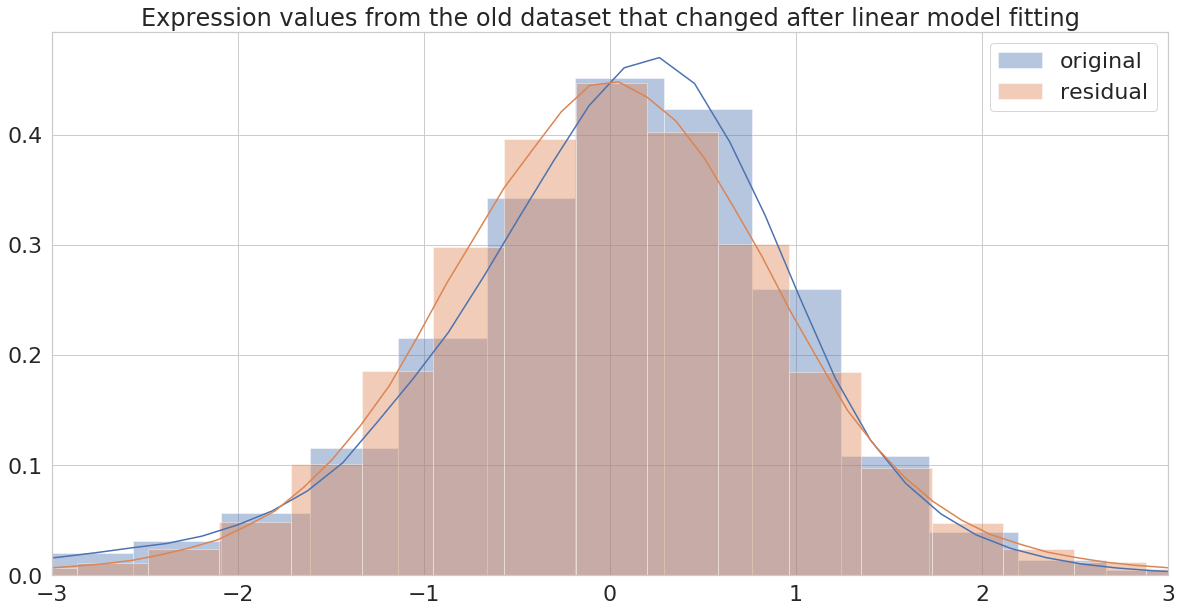

In [151]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(20, 10))
plt.title("Expression values from the old dataset that changed after linear model fitting")
# discrepancy_mask = nan_to_zero_then_scale(residual_expression_dataframe.values[:, 1:].astype(np.float32)) != expression_matrix
# print("Expression matrices differ in {} entries".format(np.sum(discrepancy_mask)))
plt.xlim((-3, 3))
sns.distplot(np.ravel(nan_to_zero_then_scale(expression_dataframe.values[:, 1:].astype(np.float32))), label="original")
sns.distplot(np.ravel(nan_to_zero_then_scale(residual_expression_dataframe.values[:, 1:].astype(np.float32))), label="residual")
plt.legend()
plt.show()
plt.close()

(375, 3)


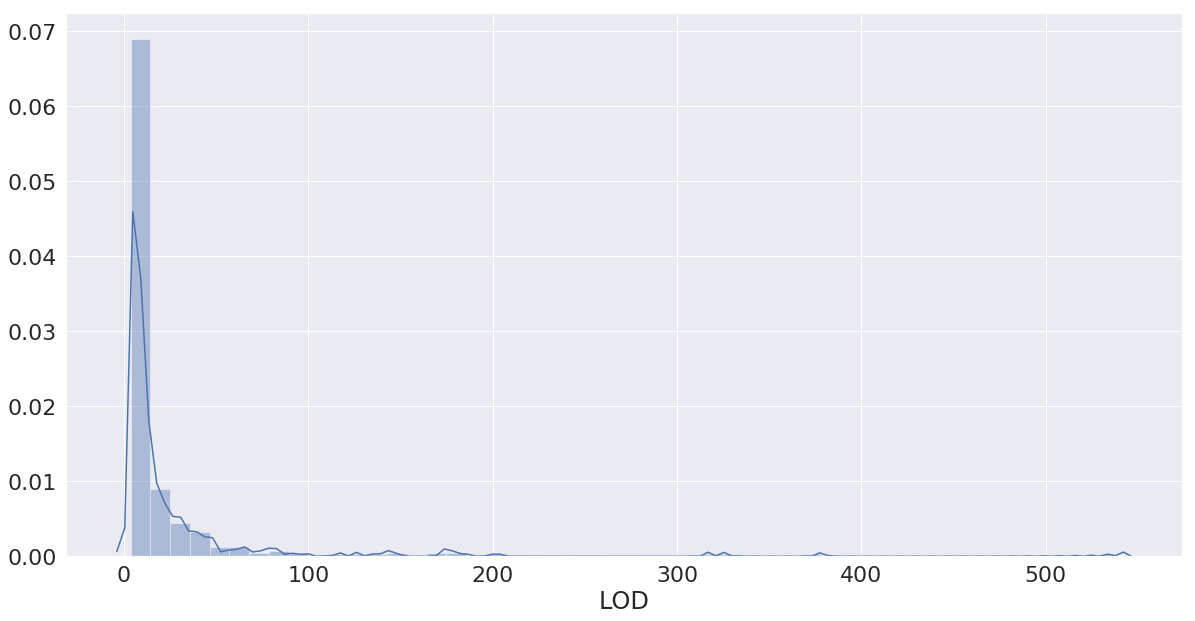

In [17]:
print(qtl_list.query("LOD >= 3.7").shape)
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.distplot(qtl_list.query("LOD >= 3.7")["LOD"])
plt.show()
plt.close()

In [33]:
pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]).to_csv("./data/eQTLs/qtls_new_recomputed.csv", sep='\t', index=False)

In [35]:
pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"])

,SNP,gene
0,chrXIII:304595_T/C,HMO1
1,chrVII:117825_A/G,YOR338W
2,chrIV:1350135_T/C,MOB1
3,chrXII:673886_G/A,FBA1
4,chrXIV:283562_A/G,YLL059C
5,chrXIV:376313_C/T,PHD1
6,chrXIV:605755_T/A,COS9
7,chrXIII:295950_G/A,SEC20
8,chrII:191281_A/G,PEP1
9,chrXV:139908_A/G,PMT2
